# Design of a 6th order finite difference Poisson solver

In [3]:
%reload_ext autoreload 
%autoreload 2 

<font color = "purple">The following notation is often used for brevity in the following notebook:

<ul>
<li> DBC = Dirichlet boundary condition
<li> NBC = Neumann boundary condition
<li> L = Left, e.g. LNBC = left Neumann boundary condition
<li> R = right, e.g. RDBC = right Dirichlet boundary condtion
</ul>

left means a boundary at $x_0$ where $x_0 < x_1 < x_2 < \ldots < x_{N-1}$, thus $x_{N-1}$ is a right boundary.</font>

# A. Motivation: bounded domains

Previously, we have provided a prescription to optimize a deterministic semi-Lagrangian strategem apt for the solution to the parabolic partial differential equation 

$$\partial_t g + k\partial_z g = 0, \qquad \qquad k\in\mathbb{R}, g = g(t,z)$$ 

to arbitrary order correctness. This procedure requires adding correction terms to incremental updates which in part depend on the accurate computation of $N-1$ derivatives of the state function $g$ to achieve a solution with a local truncation error (LTE) of order $N+1$. 

For non-open (closed or semi-open) systems, the boundaries break the periodicity and force our hand to consider alternate forms of computing the derivatives, the most obvious candidate being finite difference schemes. In a previous notebook ("Generation of families of explicit finite difference schemes for derivatives of any order of chosen LTE"), the details of obtaining arbitrary order accuracy estimates as explict finite differences for any order derivative with any degree of sidedness (e.g. centered, forward, all forward but one point backward, etc.) were worked through. The conclusions were coded into a series of scripts which compute explicit finite difference coefficient tables for the family of schemes for any derivative for user queried LTEs. In the context of DECSKS, these FD tables are used to compute the high order flux corrections to an evolving density that are employed in the remap step. In <code>DECSKS.lib.read</code> we read in the generated files for this particular application where we sample only on-grid points and do not restrict ourselves to the big three types: forward, centered, or backward differencing, but instead strive for mainintaing as centered a stencil as possible, as these give better representations of the function and thus its derivatives than sampling only one side. That application aside, we can also use the coded scripts to discern FD coefficients for any derivative for stencils of any degree of sidedness for any order of accuracy, which is where we find their use in this notebook as we will require high order finite difference coefficients for various derivatives with varying degrees of sidedness in their stencils.

We confess at the outset that we do not have motivation to pursue Poisson solvers of too high order, because finite difference based corrections on DECSKS cannot succeed when we get too high (greater than LTE order 10 or so). That is, recall in the notebook <a href = "../DECSKS-03%20--%20Convergence%20of%20FD%20formulation%20of%20high%20order%20CS/DECSKS-03%20--Convergence%20of%20FD%20formulation%20of%20high%20order%20CS.ipynb">Convergence of FD formulation of high order CS</a>. There, our pursuit of higher order was shown to not be achievable after a certain point as edge effects precluded higher accuracy. This was shown convincingly to be a consequence of the finite differenced derivatives being unable to converge near the edges (a consequence of the limited information available when at an edge we difference from one side more than the other). Thus, we note our provisional limit in the phase space remapping assignment is perhaps LTE order $O(\Delta z^{10})$, $z = \{x,v\}$.  

When addressing more involved physics (e.g. Vlasov, just below), the accuracy of our solution will <i>not</i> be controlled by the order of the CS solver incidentally, but ultimately by the choice of what is ultimately an expensive and lower order time splitting scheme used in the numerical stepthrough (e.g. time splitting schemes of LTE orders 3, 5, 7 are within the means of serial processing; however, pushing for more accurate schemes is both too intensive at this juncture, and it is unclear what a motivating context or test problem would need higher order), so we are not discouraged in the slightest. What we desire is a phase space remapping of an order $O(\Delta z^{N+1})$ LTE that is high enough to not further pollute the solution with respect to the limitations of the time splitting procedure, which scales with LTEs of order $O(\Delta t^3)$, $O(\Delta t^5)$, $O(\Delta t^7)$, $\ldots$. Since the CFL numbers are not constant, there is no obvious relationship between the mesh spacing $\Delta z$ and the time grid spacing $\Delta t$. 

<i>(We also point out to the reader that we never say "order" on its own as this is ambiguous and language is used both undiligently and inconsistently in literature (whether an "order $N$" method means "correct up to order $N$" (LTE order = $N+1$), or if someone means an "order $N$" method means the LTE is order $N$). Note, that we always say "LTE order" or "global error of order," or some variation in order to specify what it is we are speaking of. In this way, the point of bringing this to the reader's attention is that time splitting literature tends to favor labelling methods as $N$th order if they have an LTE of $N+1$ (i.e. the method is termed with the notion that it is correct <i>up to and including order $N$</i>), which is opposite to the preference in most PDE solver literature (an $N$th order method means the LTE itself is of order $N$, i.e. is correct <i>up to and including order $N-1$</i>). In this way, for the popular time splitting leapfrog scheme, it is often abbreviated as LF2, with mention that it is 2nd order, but this means its LTE is order 3. This is the opposite of how we speak of PDE solvers, e.g. a solver being of "order" 3 means the LTE is of order 3 in most publishings. Thus, it should be understood there is no conflict with the above LTEs reported for time splitting, e.g. Yoshida 4, aka Y4, has an LTE order of 5, because the convention used in its definition is just incompatible with the PDE solver literature norm. In order to not rely on the reader to "know" this common confusion, we make note that we will always specify LTE or GE (global error) when talking of "order."</i>

Moving on from an advection equation, we incorporate an acceleration term $a = a(t,x)$. In a plasma context we first consider only electrostatic interactions for cold ions (uniform background $n_0$ defined according to quasineutrality such that $n_e = n_0$) so that $a \sim E(t,x) = -\partial_x \phi(t,x)$. Hence, we consider the <i>Vlasov-Poisson system</i>:

$$\partial_t f + v\partial_x f + (\partial_x\phi) \partial_v f = 0$$
$${}$$
$$\partial_x^2 \phi = \int_v dv f(t,x,v) - n_0$$

Note, the units have been normalized (see dsirajud/Preliminary-Examination for details) and we take the case of hyrogenic atoms so that the charges are equal but opposite. At this juncture we do not address collisions but instead include only details pertaining to energy exchanges with the field and field particles. For periodic systems, we have benchmarked CS solutions against a two-stream instability and Landau damping test cases that show agreement among several solvers (DG, Eulerian, ...). The above equation can be solved numerically by time-splitting schemes (e.g. leapfrog).

For closed systems, <b>we consider CS at least at an LTE of order 6 given at best we aim to use an RKN time splitting scheme with an LTE of 7 (e.g. O11-6). Thus, in order to retain an LTE overall of order 6, we require a Poisson solver to have an LTE order of 6.</b> The subsequent excursions using these tools will likely investigate lower order time splitters as well (LF2, Y4, O6-4), which is of no further potential consequence from the CS solver or the Poisson solver provided we meet this minimum requirement of order 6. 

# B. Setup

## B.1. Motivation for Poisson vs. Gauss solver:

It is inviting to consider Gauss' law instead of Poisson's equation:

$$\partial_x E = n_i - n_e$$

The author was in fact very cordially invited by this temptation, in order to fuss with one order of derivative less; however, it was found after much convincing (and time spent) that there is not a way to make a 6th order scheme that produces a unique solution. In other words, the assembled matrix system for the above problem, no matter the choice of finite differences:

$$\underline{\underline{D}} \underline{E} = \underline{N}, \qquad \qquad \underline{N} = \underline{n}_i - \underline{n}_e$$

The matrix $\underline{\underline{D}}$ is always singular in the author's experience, in other words ostensibly no such matrix can be found that is diagonally dominant, or it can be said and shown in every such case that $D^{-1}$ does not exist. Humbly, the author notes this is probably why Poisson solvers are so often the topic of interest without any mention of Gauss law solvers for the equivalent plasma physics context (though does note at least one exception that Gauss solvers find footing in finite different solvers using Yee cells). As will be seen below, a Poisson solver can be designed with an appropriate coefficient matrix which produces unique solutions.

## B.2. Poisson's equation and grid

We consider the 1D elliptic equation:

$$\partial_x^2\phi = n_e - n_0, \qquad x\in [a,b], \qquad \phi = \phi(t,x)$$

where

$$n_e = n_e(t,x) = \int_v dv f_{\alpha}(t,x,v)$$

The scalar function $\phi = \phi (t,x)$is called the electric potential, whose definition is permitted by restricting the Maxwell equations to cases where the magnetic field is not involved. For our immediate plasma context, we define an electron density, $n_e = n_e(t,x)$ and a constant positive ion density $n_0$ (cold background); the constants $a$ and $b$ are arbitrary. The derivation in section C deal with this case to emphasize the details of the method without encumbering the process with extra terms, the result for non-constant ion density is obtained in exactly the same way as shown below, and the result is quoted for convenience, though the details are saved for the reader as the details only differ by a sign.

We approximate the continuous functions with grid functions whose cell-centered values correspond to each $x = x_i$, for $i = 0, 1, \ldots , N-1$, where Pythonic indexing is used, and we will define the domain as $x_0 = a$, $x_{N-1} = b$, with uniform spacing $\Delta x = L / (N_x - 1)$ for $N_x$ grid points over the domain of size $L = b - a$.

# C. Derivation of scheme: Dirichlet boundary conditions

## C.1. Strategy

The idea is to analytically derive high order estimations of $\partial_x^2 \phi (x_i)$ (we suppress the time dependence for brevity) whose finite difference operators sample only points on the grid (we evade employing ghost points to retain a general scheme). The solution to the set of $N$ equations provides the solution to $\phi$ for all $x_i$, $i = 0, 1, \ldots , N-1$ to $O(\Delta x^6)$.

The finite derivative estimates of $\partial_x^2\phi$ are obtained by straightforward Taylor expansion at a grid point $x_{i + k}, \, k\in\mathbb{Z}$ which necessarily incur a local truncation order that scales with $O(\Delta x^M)$. This FD estimate was obtained by considering <i>one</i> grid point $x_{i+k}$. In any case, this will yield an LTE that scales with $O(\Delta x^2)$. In order to make the FD estimate higher order, two options are available here:

<ol>
<li> <u>If there is no PDE</u>: and we consider the pure math problem of raising the LTE of the second derivative then the only manner in which the FD estimate of $\partial_x^2\phi (x_i)$ can be increased to higher order is by considering expanding $\phi (t, x_{i + k})$ for several other $k\in\mathbb{Z}$. Doing so, we develop a set of equations, that upon manipulation we have the latitude needed to eliminate orders by Gaussian elimination. This can be repeated for more points, and the algebra can be done so that higher and higher orders are killed off so that we achieve an overall highier LTE. Necessarily, this expands the stencil $\{k\}$ of the FD scheme. Such schemes are called explicit. Alternatively, the same result is obtained in recognition that linear combination of derivatives (expressed in terms of differences among the $\{\phi (x_{i+k})\}$ is ultimately what cancels high order terms. So, rather than astutely manipulate the equations as needed, instead the equivalent problem can be cast as an undetermined coefficients problem 

$$\sum_k c_k \phi(x_{i+k}) = O(\Delta x^M)$$

for a desired order $M$ (e.g. $M = 6$). In this way, we Taylor expand the left-hand sides after this statement has already been assembled, and construct order requirements that each order up to but not including the order $M$ vanish. This produces enough equations to solve for the equations uniquely in the explicit case. A second suboption here is to instead not put all the burden on the function $\phi$ itself at several grid points, but instead to put weights on the derivative itself 

$$a\phi '' (x_{i-1}) + b\phi '' (x_i) + c\phi '' (x_{i+1}) = e\phi (x_{i-1}) + h\phi (x_i) + \ell\phi(x_{i+1})$$ 

so we expand the right-hand side, and arrive at a set of coupled (on $\phi ''$) order conditions that require the orders $n < M$ vanish accordingly. Such schemes are hence <i>implicit</i>, and do not generally have unique solutions, but families of solutions by judicious choices of one coefficients ($a, b, c, e, h, \ell$) which give rise to well-known schemes such as the Padé scheme. Implicit schemes are computational more expensive than explicit, hence we do not consider this at the juncture, though later investigations may provide motivation to return to this issue given restricting the stencil size is a admittedly desirable. Hence, implicit schemes are often called <i>compact</i> because of their potential to restrict the stencil size as compared to explicit schemes.
$${}$$

<li> <u>If there <i>is</i> a PDE</u>: Rather than resorting to consider increasingly more grid points, we exploit the hand we are given by relating the derivative of $\phi$ appearing in the truncation term to a lower order derivative on the density $n$ which is related by the PDE itself. Differencing the density then raises the LTE upon substitution. <b>we pursue this strategy</b>
</ol>

## C.2. Designing the scheme

For convenience, we repeat the governing equation evaluated at a grid point $x_i$:

$$\partial_x^2 \phi_i = n_{e,i} - n_0, \qquad x\in [a,b]$$

Where the increasing sequence $(x_i)_{i=0}^{N-1} = (a = x_0, x_1, x_2, \ldots, x_{N-2}, x_{N-1} = b)$ represents centroids for a union of cells $C_i$ that constitute the continuous problem space $x\in [a,b]$. For $N$ grid points $(x_i)$, $i = 0, 1, 2, \ldots , N-1$ we require $N$ equations.

### C.2.1. Boundary conditions: 2 equations

For now, we consider Dirichlet boundary conditions: 

<ol>
<li> $\boxed{\phi (x_0) \equiv \phi_0 = \phi_a}$
<li> $\boxed{\phi (x_{N-1}) \equiv \phi_{N-1} = \phi_b}$ are specified.
</ol>

### C.2.2. Finite difference equations: $N-2$ equations total

We derive separate representations for the interior nodes vs. the edge nodes given so that the grid sampling requires only points within the domain itself.

An FD approximation for the second derivative is obtained as usual by expanding the function evaluated at the grid points $x_{i\pm 1} = x_i \pm 1\cdot\Delta x$, where the shorthand is used $\phi_i \equiv \phi (x_i)$, and so on.

$$\phi_{i+1} = \phi_i + \Delta x \phi_i^{(1)} + \frac{(\Delta x)^2}{2}\phi_i^{(2)} + \frac{(\Delta x)^3}{3!}\phi_i^{(3)} + \frac{(\Delta x)^4}{4!}\phi_i^{(4)} + \frac{(\Delta x)^5}{5!}\phi_i^{(5)} + \ldots$$

$$\phi_{i-1} = \phi_i - \Delta x \phi_i^{(1)} + \frac{(\Delta x)^2}{2}\phi_i^{(2)} - \frac{(\Delta x)^3}{3!}\phi_i^{(3)} + \frac{(\Delta x)^4}{4!}\phi_i^{(4)} - \frac{(\Delta x)^5}{5!}\phi_i^{(5)} + \ldots$$

It is clear the addition of the above two equations kill off the first derivative (and incidentally, all odd order derivatives), which allows us to solve for the second derivative as a function of higher order (even) derivatives:

$$\phi_i^{(2)} = \frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) - \frac{2}{4!}(\Delta x)^2\phi_i^{(4)} - \frac{2}{6!}(\Delta x)^4\phi_i^{(6)} + O(\Delta x^6)$$

Note, it is important to keep track of the sign of the terms here in order to properly combine them in subsequent steps. In this way, while we can either obtain from literature or otherwise (e.g. with scripts developed in the notebook <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-01%20--%20Generation%20of%20families%20of%20explicit%20finite%20difference%20schemes%20for%20derivatives%20of%20any%20order%20of%20chosen%20LTE/DECSKS-01%20--%20Generation%20of%20families%20of%20explicit%20finite%20difference%20schemes%20for%20derivatives%20of%20any%20order%20of%20chosen%20LTE.ipynb">DECSKS-01</a> come to know the difference coefficients, deriving this method does require us to know the details of the truncated terms as will be seen shortly, so it is unfortunately necessary to carry out the calculations as literature does not provide all the details we require for our purposes.

Inserting the FD derivative above into Poisson's equation, we have:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = n_{e,i} - n_0 + \frac{2}{4!}(\Delta x)^2\phi_i^{(4)} + \frac{2}{6!}(\Delta x)^4\phi_i^{(6)} + O(\Delta x^6), \qquad i\in\mathbb{N}_1^{N-2}$$

where the differencing already restricts the range of indices allowable (for example, inserting $i = 0$ into the above equation requires knowledge of $\phi_{i-1} = \phi_{-1}$). The numerical coefficients (i.e. excepting the factor of $(\Delta x)^{-2}$) are known as <i><b>finite difference coefficients</b></i>. Our goal is to achieve an LTE of order 6 overall. Rather than attempt to eliminate the derivatives $\partial_x^4 \phi$ and $\partial_x^6 \phi$ by considering other stencil points, we instead replace the derivatives in terms of derivatives on $n$ which we can express in terms of finite differences of low order (hence a smaller stencil as compared to higher derivatives that directly appear, such as $\partial_x^4\phi$ and $\partial_x^6\phi$). Since these terms are multiplied by the terms $(\Delta x)^2$ and $(\Delta x)^4$, we only require an FD scheme for each term to be accurate up to an LTE of $O(\Delta x^4)$ and $O(\Delta x^2)$ so that an effective $O(\Delta x^6)$ is achieved.

Hence, we see relate:

\begin{eqnarray*}
\partial_x^2\phi_i & = & n_{ei} - n_0\\[1em]
\Rightarrow \partial_x^4\phi_i & = & \partial_x^2 n_{e,i}, \qquad n_0 = \text{const} \\[1em]
\Rightarrow \partial_x^6\phi_i & = &\partial_x^4 n_{e,i}
\end{eqnarray*}

So, the above equation can be written as:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = (n_{e,i} - n_0) + \frac{2}{4!}(\Delta x)^2n_{e,i}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{e,i}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

We then require finite difference estimations with the LTE order requirements:

$$LTE[n_{e,i}^{(2)}] = O(\Delta x^4)$$

and

$$LTE[n_{e,i}^{(4)}] = O(\Delta x^2)$$

These schemes be obtained from literature (or otherwise derived or generated via script, cf. notebook "Generation of families of explicit finite difference schemes for derivatives of any order of chosen LTE", we elect to pursue this in the "edge nodes" subsection that follows). 

The left-hand side produces $N-2$ equations for $i = 1, 2, \ldots , N-3, N-2$ that couple the equations with the potential function values ranging the entire domain: from $\phi_{i-1}|_{i = 1} = \phi_0$ to $\phi_{i+1}|_{i = N-2} = \phi_{N-1}$. The right-hand side now requires differencing in the density function, which for both derivatives, independent of scheme handedness (forward, backward, central), involves a 6-point stencil. Since central differencing are generally more accurate (as observed time and time again), we aim to use central difference inasmuch as possible. For the edge nodes, the central scheme would require knowledge of function values outside the grid, thus forward/backward schemes are required. <b>There are then three versions of eq. (*), which differ only in how the right-hand side is casted (central, forward, or backward differencing)</b>, the following subsections develop these versions.

### C.2.2.1. interior nodes (central differencing)


\begin{eqnarray*}
n_{e,i}^{(2)} & = & \frac{1}{12(\Delta x^2)}\left[-n_{e,i-2} + 16n_{e,i-1} - 30n_{e,i} + 16n_{e,i+1} - n_{e,i+2}\right] + O(\Delta x^4)\\[1em]
n_{e,i}^{(4)} & = & \frac{1}{(\Delta x)^4}\left[n_{e,i-2} - 4n_{e,i-1} + 6n_{e,i} - 4n_{e,i+1} + n_{e,i+2}\right] + O(\Delta x^2)
\end{eqnarray*}

Substituting these into our current result above:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) & = & n_{e,i} - n_0\\[1em]
&& + \frac{2}{4!}(\Delta x)^2\left[\frac{1}{12(\Delta x^2)}(-n_{i-2} + 16n_{i-1} - 30n_i + 16n_{i+1} - n_{i+2}) + O(\Delta x^4)\right] \\[1em]
&& + \frac{2}{6!}(\Delta x)^4\left[\frac{1}{(\Delta x)^4}(n_{i-2} - 4n_{i-1} + 6n_i - 4n_{i+1} + n_{i+2}) + O(\Delta x^2)\right] + O(\Delta x^6)
\end{eqnarray*}

collecting terms,

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) & = & -n_0\\[1em]
&& + n_{e,i-2}\left(-\frac{2}{4!\,12}(1) + \frac{2}{6!}(1)\right) \\[1em]
&& + n_{e,i-1}\left(\frac{2}{4!\,12}(16) - \frac{2}{6!}(4)\right) \\[1em]
&& + n_{e,i}\left(-\frac{2}{4!\,12}(30) + \frac{2}{6!}(6) + 1\right) \\[1em]
&& + n_{e,i+1}\left(\frac{2}{4!\,12}(16) - \frac{2}{6!}(4)\right) \\[1em]
&& + n_{e,i+2}\left(-\frac{2}{4!\,12}(1) + \frac{2}{6!}(1)\right) + O(\Delta x^6)
\end{eqnarray*}

or

$$\boxed{\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = -n_0 - \frac{1}{240}n_{e,i-2} + \frac{1}{10}n_{e,i-1} + \frac{97}{120}n_{e,i} + \frac{1}{10}n_{e,i+1} - \frac{1}{240}n_{e,i+2} + O(\Delta x^6)}$$

$$\underline{\text{interior nodes equations}}: \quad i = 2, 3, \ldots, N-4, N-3$$

Where again, the restriction of the grid index is noted so that these equations do not require knowledge of any outside points. Thus, we have $N-4$ equations, 2 Dirichlet boundary conditions ($\phi_0 = \phi_a, \, \phi_{N-1} = \phi_b$), totalling $N-2$ equations in $N$ unknowns. The two missing equations are the edge versions at $i = 1$, where the left-hand side requires use of $\phi_{i-1} = \phi_0$ and $i = N-2$ which involves $\phi_{i+1} = \phi_{N-1}$. This amounts to developing a consistent formulation for the right-hand side.

We proceed in the same way but consider forward (backward) differencing for the left (right) edge grid points.

#### C.2.2.2. Left-edge node ('forward-1' differencing)

Considering eq. (*) is valid for $i = 1, 2, \ldots, N-2$, the left-edge node corresponds to $i = 1$ where the value $\phi_{i-1} = \phi_0$ is involved. Thus, for the differencing of $n$ we require using a 'forward-1' scheme, which samples grid points totally forward of the point $i = 1$ and one backward $i = 0$ (hence the nomenclature which has been used in previous in notebooks in abbreviated form (i.e. equivalent to 'forward 1'). We use the following script to generate the family of schemes required for the requisite LTE on $n$ (recall we require $LTE[n_{e,i}^{(2)} = O(\Delta x^4)$ and $LTE[n_{e,i}^{(4)}] = O(\Delta x^2)$)

In [1]:
cd pyfiles/bin/

/home/dsirajud/Work/IPython-notebooks/DECSKS-04 -- Design of a 6th order FD Poisson solver/pyfiles/bin


In [2]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE

generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 2, LTE = 4)
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 4, LTE = 2)

These produce the files 'f2_LTE_4_FD_coefficients.dat', and 'f4_LTE_2_FD_coefficients.dat'. Viewing the files, which contain all schemes for all degrees of handedness for the specified derivative order and LTE, we report the forward 1 difference as outputted (note, will likely not be viewed with the given table formatting on static snapshots of this notebook, e.g. nbviewer gists. The curious reader is invited to run the notebook on github dsirajud/IPython-notebooks/Design of ....) and view the files for themselves for verification, or otherwise view the outputs contained within ./pyfiles/etc/ .

    -------------------------
    f^(2): forward 1
    -------------------------
    (weights, stencil)
    0.83333, -1
    -1.25000,  0
    -0.33333,  1
    1.16667,  2
    -0.50000,  3
    0.08333,  4
    -------------------------

    -------------------------
    f^(4): forward 1
    -------------------------
    (weights, stencil)
    2.00000, -1
    -9.00000,  0
    16.00000,  1
    -14.00000,  2
    6.00000,  3
    -1.00000,  4
    -------------------------

Thus, we record the following schemes where we use the decimal representations outputted above whereafter we case these same numbers using the exact rational representations (the output above is truncated, we typically have access to 22 decimal places, which is sufficient to confidently converge on the exact fraction these numbers correspond to eitheir by inspection or through more intelligent engine lookup (e.g. Wolfram alpha). Also, for those obtainable in literature, we have tripled checked the rational representations are appropriate, though typically these schemes are not as available in literature as their pure forms (forward 0 scheme, etc.).

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}[ (0.833\ldots ) n_{e,i-1} - 1.25 n_{e,i} - 0.\bar{3} n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - 0.5n_{e,i+3} + 0.08\bar{3}n_{e,i+4}] + O(\Delta x^4)$$

or,

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}\left(\frac{5}{6}n_{e,i-1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - \frac{1}{2}n_{e,i+3} + \frac{1}{12}\bar{3}n_{e,i+4}\right) + O(\Delta x^4)$$

and, for the fourth derivative

$$n_{e,i}^{(4)} = \frac{1}{(\Delta x)^4}(2n_{e,i-1} - 9 n_{e,i} + 16n_{e,i+1} - 14n_{e,i+2} + 6n_{e,i+3} - n_{e,i+4}) + O(\Delta x^4)$$

Inserting these into eq. (*) and letting $i = 1$, we develop its left-edge node version, correct to an LTE order of 6:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}(\phi_2 - 2\phi_1 + \phi_0) & = & n_{e,1}- n_0 \\[1em]
&& + \frac{2}{4!}\left(\frac{5}{6}n_{e,i-1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - \frac{1}{2}n_{e,i+3} + \frac{1}{12}\bar{3}n_{e,i+4}\right) \\[1em]
&& + \frac{2}{6!}(2n_{e,i-1} - 9 n_{e,i} + 16n_{e,i+1} - 14n_{e,i+2} + 6n_{e,i+3} - n_{e,i+4}) + O(\Delta x^6) \\[1.5em]
& = & -n_0 \\[1em]
& & + n_{e,0}\left[\frac{2}{4!}\left(\frac{5}{6}\right) + \frac{2}{6!}(2)\right] \\[1em]
& & + n_{e,1}\left[1 + \frac{2}{4!}\left(-\frac{5}{4}\right) + \frac{2}{6!}(-9)\right] \\[1em]
& & + n_{e,2}\left[\frac{2}{4!}\left(-\frac{1}{3}\right) + \frac{2}{6!}(16)\right] \\[1em]
& & + n_{e,3}\left[\frac{2}{4!}(1.1\bar{6}) + \frac{2}{6!}(-14)\right] \\[1em]
& & + n_{e,4}\left[\frac{2}{4!}\left(-\frac{1}{2}\right) + \frac{2}{6!}(6)\right] \\[1em]
& & + n_{e,5}\left(\frac{2}{4!}\left(\frac{1}{12}\right) + \frac{2}{6!}(-1)\right] \\[1em]
& & + O(\Delta x^6)
\end{eqnarray*}

or,

$$\boxed{\frac{1}{(\Delta x)^2}(\phi_2 - 2\phi_1 + \phi_0) = -n_0 + \frac{3}{40}n_{e,0} + \frac{209}{240}n_{e,1} + \frac{1}{60}n_{e,2} + \frac{7}{120}n_{e,3} - \frac{1}{40}n_{e,4} + \frac{1}{240}n_{e,5} + O(\Delta x^6)}$$

$$\underline{\text{left-edge node equation}}$$


#### C.2.2.3. Right-edge node ('backward+1' differencing)

We now consider $i = N-2$ in eq. (*), which requires 'backward+1' schemes for the same derivatives. Reading the generated tables, we record the following difference coefficients for the relevant schemes needed:

    -------------------------
    f^(2): backward 1
    -------------------------
    (weights, stencil)
    0.08333, -4
    -0.50000, -3
    1.16667, -2
    -0.33333, -1
    -1.25000,  0
    0.83333,  1
    -------------------------
    
    -------------------------
    f^(4): backward 1
    -------------------------
    (weights, stencil)
    -1.00000, -4
    6.00000, -3
    -14.00000, -2
    16.00000, -1
    -9.00000,  0
    2.00000,  1
    -------------------------

Note, these are the same weights as in the forward scheme (this trend is true for all even number derivatives, for odd derivatives the weights can be seen to always be equal but opposite). Thus, we skip the decimal transcription and skip to the rational representations as above. Thus, relevant for $i = N-2$, we have:

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}\left(\frac{5}{6}n_{e,i+1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i-1} + 1.1\bar{6}n_{e,i-2} - \frac{1}{2}n_{e,i-3} + \frac{1}{12}\bar{3}n_{e,i-4}\right) + O(\Delta x^4)$$

and, for the fourth derivative

$$n_{e,i}^{(4)} = \frac{1}{(\Delta x)^4}(2n_{e,i+1} - 9 n_{e,i} + 16n_{e,i-1} - 14n_{e,i-2} + 6n_{e,i-3} - n_{e,i-4}) + O(\Delta x^4)$$

Inserting these into eq. (*), and writing $i = N-2$:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}(\phi_{N-1} - 2\phi_{N-2} + \phi_{N-3}) & = & n_{e,N-2}- n_0 \\[1em]
&& + \frac{2}{4!}\left(\frac{5}{6}n_{e,N-1} - \frac{5}{4}n_{e,N-2} - \frac{1}{3}n_{e,N-3} + 1.1\bar{6}n_{e,N-4} - \frac{1}{2}n_{e,N-5} + \frac{1}{12}\bar{3}n_{e,N-6}\right) \\[1em]
&& + \frac{2}{6!}(2n_{e,N-1} - 9 n_{e,N-2} + 16n_{e,N-3} - 14n_{e,N-4} + 6n_{e,N-5} - n_{e,N-6}) + O(\Delta x^6) \\[1.5em]
& = & -n_0 \\[1em]
& & + n_{e,N-1}\left[\frac{2}{4!}\left(\frac{5}{6}\right) + \frac{2}{6!}(2)\right] \\[1em]
& & + n_{e,N-2}\left[1 + \frac{2}{4!}\left(-\frac{5}{4}\right) + \frac{2}{6!}(-9)\right] \\[1em]
& & + n_{e,N-3}\left[\frac{2}{4!}\left(-\frac{1}{3}\right) + \frac{2}{6!}(16)\right] \\[1em]
& & + n_{e,N-4}\left[\frac{2}{4!}(1.1\bar{6}) + \frac{2}{6!}(-14)\right] \\[1em]
& & + n_{e,N-5}\left[\frac{2}{4!}\left(-\frac{1}{2}\right) + \frac{2}{6!}(6)\right] \\[1em]
& & + n_{e,N-6}\left(\frac{2}{4!}\left(\frac{1}{12}\right) + \frac{2}{6!}(-1)\right] \\[1em]
& & + O(\Delta x^6)
\end{eqnarray*}

or,

$$\boxed{\frac{1}{(\Delta x)^2}(\phi_{N-1} - 2\phi_{N-2} + \phi_{N-3}) = -n_0 + \frac{1}{240}n_{e,N-6} - \frac{1}{40}n_{e,N-5}  + \frac{1}{60}n_{e,N-3} + \frac{7}{120}n_{e,N-4} + \frac{209}{240}n_{e,N-2} + \frac{3}{40}n_{e,N-1} + O(\Delta x^6)}$$

$$\underline{\text{right-edge node equation}}$$

We note these coefficients are the same as obtained for the other boundary, but are flipped in order.

## C.3. Assembling the matrix equation for Dirichlet boundary conditions

With the $N-2$ finite difference equations + 2 boundary conditions that are known a priori, we write several equations for various indices $i$ in order to clearly see the matrix take form, where for $i = 1$ ($i = N-2$) we use the left (right) edge versions of the FD equations, and for $i\in [2, N-3]$ we use the central differencing equation. <b>We factor out $(\Delta x)^{-2}$ on the left-hand side here since almost every row has such a factor not shown below. We do this for convenience and clean communication, also to limit the number of times the same term must appear</b>:

\begin{eqnarray*}
i = 0: & (\Delta x)^2 \phi_0& = \phantom{-}\phi_a \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & = -n_0 + \frac{3}{40}n_{e,0} + \frac{209}{240}n_{e,1} + \frac{1}{60}n_{e,2} + \frac{7}{120}n_{e,3} - \frac{1}{40}n_{e,4} + \frac{1}{240}n_{e,5} \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = -n_0 - \frac{1}{240}n_{e,0} + \frac{1}{10}n_{e,1} + \frac{97}{120}n_{e,2} + \frac{1}{10}n_{e,3} - \frac{1}{240}n_{e,4} \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & = -n_0 - \frac{1}{240}n_{e,1} + \frac{1}{10}n_{e,2} + \frac{97}{120}n_{e,3} + \frac{1}{10}n_{e,4} - \frac{1}{240}n_{e,5} \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = -n_0 - \frac{1}{240}n_{e,N-6} + \frac{1}{10}n_{e,N-5} + \frac{97}{120}n_{e,N-4} + \frac{1}{10}n_{e,N-3} - \frac{1}{240}n_{e,N-2} \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = -n_0 - \frac{1}{240}n_{e,N-5} + \frac{1}{10}n_{e,N-4} + \frac{97}{120}n_{e,N-3} + \frac{1}{10}n_{e,N-2} - \frac{1}{240}n_{e,N-1} \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = -n_0 + \frac{1}{240}n_{e,N-6} - \frac{1}{40}n_{e,N-5} + \frac{7}{120}n_{e,N-4} + \frac{1}{60}n_{e,N-3} + \frac{209}{240}n_{e,N-2} + \frac{3}{40}n_{e,N-1} \\[1em]
i = N-1: & (\Delta x)^2\phi_{N-1} & = \phantom{-}\phi_b
\end{eqnarray*}

For example, the top equation is actually 

$$\text{row } i = 0: \quad (\Delta x)^{-2}[ (\Delta x)^2 \phi_0 ]= \phi_a \quad \text{or} \quad \phi_0 = \phi_a, \qquad \text{Dirichlet condition at } x = x_0$$

The second equation is actually 

$$\text{row } i = 1: \quad(\Delta x)^{-2}[\phi_0 -2\phi_1 + \phi_2]  = -n_0 + \frac{3}{40}n_{e,0} + \frac{209}{240}n_{e,1} + \frac{1}{60}n_{e,2} + \frac{7}{120}n_{e,3} - \frac{1}{40}n_{e,4} + \frac{1}{240}n_{e,5}$$

and so on. The final equation is 

$$\text{row } i = N-1: \quad(\Delta x)^{-2}[ (\Delta x)^2 \phi_{N-1} ]= \phi_b \quad \text{or} \quad \phi_{N-1} = \phi_b, \qquad \text{the Dirichlet boundary condition at } x = x_{N-1}$$

That is, we are aiming to write a matrix equation as:

$$\partial_x^2\phi = n_e - n_0 \qquad \longrightarrow \qquad \frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \text{ or } \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b}$$

where the differencing matrix $\underline{\underline{D}}$ (LH = "left-hand"),

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
i = 0: \, \text{Dirichlet BC at } x = x_0 \text{ LH coefficient: } (\Delta x)^2\cdot\phi_0 \\
i = 1: \, \text{central differencing FD coefficients on  } \{\phi_i\} \\
i = 2: \, \text{central differencing FD coefficients on  } \{\phi_i\} \\
i = 3: \, \text{central differencing FD coefficients on  } \{\phi_i\} \\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{central differencing FD coefficients on  } \{\phi_i\} \\
i = N-2: \, \text{central differencing FD coefficients on  } \{\phi_i\} \\
i = N-1: \, \text{Dirichlet BC at } x = x_{N-1} \text{ LH coefficient at: } (\Delta x)^2\cdot\phi_{N-1}
\end{array} \right)
= \left( \begin{array}{c c c c c c c c c}
(\Delta x)^2 & 0 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & (\Delta x)^2 
\end{array} \right)$$

The unknown potential vector $\underline{\phi}$:

$$\underline{\phi} = \underline{\phi}_{N\times 1} = (\phi_0, \phi_1, \ldots , \phi_{N-2}, \phi_{N-1})^T$$

and the vector $\underline{b}$ on the right-hand side we choose to write as:

$$\underline{b} = (\underline{\underline{B}}_e\underline{n}_e - \underline{n}_0) + \underline{\phi}_{DBC}$$

where the auxillary vector $\underline{\phi}_{DBC}$ is a 1D vector whose only nonzero entries are at the boundaries $i = 0$ and $i = N-1$, i.e. it is a vector that factors in the boundary conditions. Thus, we have

$$\underline{\phi}_{DBC} = \underline{\phi}_{DBC,N\times 1} = (\phi_a, 0, 0, \ldots, 0, 0, \phi_b)^T$$

The densities:

$$\underline{n}_0 = (0, n_0, n_0, n_0, \ldots n_0, n_0, 0)_{N\times 1}$$

$$\underline{n}_e = \underline{n}_{e,N\times 1} = (n_{e,0}, n_{e,1}, \ldots , n_{e,N-2}, n_{e,N-1})^T$$

We explain the background density $\underline{n}_0$ having zeros in the first and final rows in the next paragraph. The matrix $\underline{\underline{B}}_e$ has the coefficients as defined above at different grid function values of the density $n_e$. Recall that above, the factors of $(\Delta x)^s$ $s\in\mathbb{N}$ cancelled in the algebra on the $n_e$ terms, thus this matrix contains the rational number coefficients recorded just above.

Recall further, that the differencing on the density functions is for rows $i = 1$ to $i = N-2$, these correspond to the differencing on the left-hand side of Poisson's eqwuation for $\phi_1$ to $\phi_{N-2}$. The first row ($i = 0$) is the Dirichlet BC, as is the final row $i = N-1$, which are statements like $\phi_0 = a$ and $\phi_{N-1} = b$, i.e. independent of density. Thus, in the $i = 0$ and $i = N-1$ rows of the matrix $\underline{\underline{B}}_e$ can be set to rows of zeros in order to nix all density terms, and along with the same entries set to zero in the background density $\underline{n}_0$, we have the resulting equation is $\phi_0 = \phi_{DBC,0} = a$ and so on for the final row.

$$\underline{\underline{B}}_e = \underline{\underline{B}}_{e,N\times N} = \left( \begin{array}{c}
i = 0: \, \text{Dirichlet BC equation: } n_e \text{ not involved} \ldots = \underline{0} \\
i = 1: \, \text{left-edge node FD coefficients on } \{n_{e,j}\}\\
i = 2: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
i = 3: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
i = N-2: \, \text{right-edge node FD coefficients on }  \{n_{e,j}\} \\
i = N-1: \, \text{Dirichlet BC equation: } n_e \text{ not involved} \ldots = \underline{0}
\end{array} \right)
$$

so

$$\underline{\underline{B}}_e = \left( \begin{array}{c c c c c c c c c c c c c c}
0 &  0 &  0 &  0 &  0 &  0 &  0 &  \cdots &  \cdots & \cdots & 0\\
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots & \cdots & \cdots & 0 \\
 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0\\
\vdots & \vdots & \vdots & \vdots & 0 &  0 &  -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0 & 0 &  0&   0 &  0 &  0  &  0 &  0\\
\end{array} \right)$$

Thus, given this setup,

$$\underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b} \quad \longrightarrow \quad \underline{\underline{D}}\underline{\phi}  = (\Delta x)^2 [(\underline{\underline{B}}_e\underline{n}_e - \underline{n}_0) + \underline{\phi}_{DBC}]$$

the $i = 0$ row is

$$(\Delta x)^2\phi_0 = (\Delta x)^2 a \quad \Rightarrow \quad \Rightarrow \phi_0 = a$$

the $i = N-1$ row is

$$(\Delta x)^2\phi_{N-1} = (\Delta x)^2 b \quad \Rightarrow \quad \Rightarrow \phi_{N-1} = b$$

which are the Dirichlet BC equations. This was the point of disengaging the densisty vector from entering these equations. It also permits us to, if we like, remove the terms of $(\Delta x)^2$ from the matrix $i = 0$ and $i = N-1$ rows of both $\underline{\underline{D}}$ and $(\Delta x)^2 \underline{\phi}_{DBC}$, so that we can write

$$\boxed{\underline{\underline{D}}\underline{\phi}  = (\Delta x)^2 (\underline{\underline{B}}_e\underline{n}_e - \underline{n}_0) + \underline{\phi}_{DBC}} \quad \text{6th order Dirichlet Poisson matrix problem}$$

provided we replace the entries $(\Delta x)^2 \rightarrow 1$ in the difference matrix $\underline{\underline{D}}$ as 

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N}
= \left( \begin{array}{c c c c c c c c c}
1 & 0 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{array} \right)$$

Thus, we have a complete picture here of the solver.

<table "width = 85%">
<tr><td><b>Solubility</td></tr>
<tr><td>
The matrix $\underline{\underline{D}}$ is not strongly diagonally dominant ($\sum_{j\neq i} |d_{ij}| \ngtr |d_{ii}|$), but weakly diagonally dominant given the equality holds ($\sum_{j\neq i} |d_{ij}| = |d_{ii}|$ for all rows $i$ where the strict inequality is true for at least one other row.  Hence, the matrix is invertible (cf. Gershogorin circle theorem, zero is not an eigenvalue) and a unique solution exists. The matrix $\underline{\underline{D}}$ is Hermitian, which suggests Cholesky factorization as a means to find its inverse if desired, alternatively (and more commonly) the matrix equation can be solved without the inverse by direct LU factorization (e.g. numpy.linalg.solve).</td></tr>
</table>

## D. Numerical solution for Dirichlet boundary conditions when $n_i \neq \text{const}$

Now, suppose the ion density $n_i(t,x)$ evolves alongside $n_e(t,x)$ according to transport equations (e.g. Vlasov equations for each species)

$$\partial_t f_e + v\partial_x f_e = 0$$

$$\partial_t f_i + (m_e / m_i) v\partial_x f_i = 0$$

which are tied to the field (or potential) equation:

$$\partial_x^2\phi = n_e - n_i$$

where 

$$n_e = \int_v dv \, f_e(t,x,v), \quad n_i = \int_v dv \, f_i(t,x,v)$$

or, for compactness we can write

$$\partial_x^2\phi = n, \qquad \qquad n = n_e - n_i$$

The numerical solution to Poisson's equation takes the form:

$$\boxed{\underline{\underline{D}}\underline{\phi} = \underline{b}}$$

Where $\underline{\underline{D}}$, $\underline{\phi}$ are as defined in section C.3 for the case of Dirichlet boundary conditions (other forms to be included in a section F), but the right-hand side differs in that because the ion density is not constant, $n_i$ is differenced where its finite difference coefficients matrix $\underline{\underline{B}}_i = \underline{\underline{B}}_e \equiv \underline{\underline{B}}$ as defined above.

$$\underline{b} = (\Delta x)^2 (\underline{\underline{B}}_e\underline{n}_e - \underline{\underline{B}}_i\underline{n}_i) + \underline{\phi}_{DBC}$$

or

$$\boxed{\underline{b} = (\Delta x)^2 \underline{\underline{B}}(\underline{n}_e - \underline{n}_i) + \underline{\phi}_{DBC}}$$

for $\underline{\phi}_{DBC}$ as defined above in section C.3., and now $\underline{n}_i = \underline{n}_{i,N\times 1} = (n_{i,0}, n_{i,1}, \ldots , n_{i,N-2}, n_{i,N-1})^T$

Thus, it is a simple matter to move from a constant background ion density to a density which evolves alongside the electron density. We might instead like to cast the source term as one term $\underline{n} = \underline{n}_e - \underline{n}_i$, so that in its most compact form we can write:

$$\boxed{\underline{\underline{D}}\underline{\phi} =  (\Delta x)^2 \underline{\underline{B}}\underline{n} + \underline{\phi}_{DBC}}$$

The following is included as pyfiles/bin/Poisson_solver.py , we report the code here to be self-contained given the code cannot be long:

### Poisson_6th.py code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

def Poisson_6th_LDBC_RDBC(n, Nx = 24, a = 0, b = 1, LBC = 0, RBC = 0):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs
       over the domain x in [a,b]
       
    inputs:
    n -- (ndarray, ndim=1) density in Poisson's equation
    Nx -- (int) number of grid points
    phi_a -- (float) potential at left endpoint, x = a
    phi_b -- (float) potential at right endpoint, x = b
    
    outputs:
    phi -- (ndarray, ndim = 1) numerical solution to potential
    """
    # domain parameters
    dx = float(b - a) / (Nx - 1)
    
    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = B*n + phi_BC

    # Assemble FD coefficient matrix on phi: D
    D = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0 or i == Nx-1:
            D[i,i] = 1
        else:
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros([Nx,Nx])
    for i in range(Nx):
        # if i == 0: all zeros (to make row DBC equation independent of density n)
            
        if i == 1:
            B[i,i-1] = 3/40.
            B[i,i] = 209/240.
            B[i,i+1] = 1/60.
            B[i,i+2] = 7/120.
            B[i,i+3] = -1/40.
            B[i,i+4] = 1/240.

        elif i == Nx-1:
            B[i,i] = 0

        elif 1 < i < Nx-2:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:
            B[i,i-4] = 1/240.
            B[i,i-3] = -1/40.
            B[i,i-2] = 7/120.
            B[i,i-1] = 1/60.
            B[i,i] = 209/240.
            B[i,i+1] = 3/40.
            
        #elif i == Nx-1: all zeros (to make row DBC equation independent of density n)

    # Dirichlet boundary conditions (DBC) vector
    phi_DBC = np.zeros(Nx)
    phi_DBC[0] = LBC
    phi_DBC[-1] = RBC

    # label the RHS a b = dx ** 2 * B*n + phi_DBC
    b = dx ** 2 * B.dot(n) + phi_DBC

    # solve D*phi = b
    phi = LA.solve(D,b)

    return phi

# E. Convergence tests

To prove the above scheme is 6th order in LTE, we choose a solution:

$$\phi (x) = \sin (\pi^2 x),\qquad x\in [0,1]$$

Thus, the boundary values are 

<ol>
<li> $\phi (0) = \phi_a = 0$
<li> $\phi (1) = \phi_b = \sin (\pi^2)$
</ol> 

Poisson's equation provides the density:

$$\partial_x^2\phi = n, \qquad n = n_e - n_i$$

as the second derivative of this potential: $\partial_x^2\phi = \partial_x^2[\sin (\pi^2 x)] = -\pi^4 \sin (\pi^2 x)$, or $n = -\pi^4\sin (\pi^2 x)$

Thus, we assess the performance of the above solver to reproduce the chosen solution from the discrete problem:

$$\delta_x^2\phi_i = -\pi^4\sin (\pi^2 x_i), \quad x_i\in [0,1], \qquad i = 0, 1, \ldots , N_x-2, N_x-1$$

$$L = 1 - 0, \Delta x = L / (N_x - 1)$$

and measure the accuracy of the solution and computing an observed order of accuracy

$$\text{order} = \log_2 \frac{||\phi_{exact} - \phi||_{\ell^2,\Delta x}}{||\phi_{exact} - \phi||_{\ell^2,\Delta x/2}}$$

over meshes that are progressively halved, so that the the base-2 logarithm gives the order as $\Delta x \rightarrow 0$ as usual. Note, the $\ell^2$ norm is the discrete analog of the $L^2$ norm as usual.

set up problem domain and exact solution

In [31]:
import numpy as np

# grid setup
a = 0.
b = 1.
L = b - a

# the boundary values from phi_exact are seen to be:
phi_a = 0
phi_b = np.sin(np.pi**2)

A convergence routine is stepped through to assess the fidelity and accuracy of the solver. We anticipate the error to drop off with a slope whose absolute value is 6 on a $\log_2$ plot.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536]
num_grids = len(Nx)

error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = -np.pi**4 * np.sin(np.pi**2 * x)

    phi = Poisson_6th_LDBC_RDBC(n, Nx = Nx[grid], LBC = phi_a, RBC = phi_b)
    phi_exact = np.sin(np.pi**2 * x)
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 0.00123197       ----
Nx24        error = 2.57342e-06       order = 8.90306
Nx48        error = 3.33434e-08       order = 6.27014
Nx96        error = 5.07454e-10       order = 6.03798
Nx192        error = 7.68437e-12       order = 6.04521
Nx384        error = 1.1931e-13       order = 6.00914
Nx768        error = 3.31719e-14       order = 1.84668
Nx1536        error = 1.73946e-13       order = -2.39061




The scheme shows convergence for a range $48 < N_x \leq 384$, whereafter the error remains within very acceptable ranges ($10^{-13}$) for most anyone's needs. If we increasingly refine the mesh, as usual we will see the error increases on account of the finite precision of numerical arithmetic, this is expected and usual for finite difference schemes. 

For example, a mesh characterized by $N_x = 96$ is convergent, which produces a numerical approximation to the solution as follows:

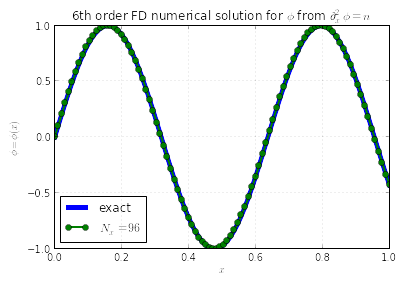

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 96
x = np.linspace(a,b,Nx)

n = -np.pi**4 * np.sin(np.pi**2 * x)

phi = Poisson_6th_LDBC_RDBC(n, Nx = Nx, LBC = 0, RBC = np.sin(np.pi**2))
phi_exact = np.sin(np.pi**2 * x)

plt.plot(x, phi_exact, label = 'exact', linewidth = 5)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = %d$' % Nx, marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

# F. Solvers for different boundary conditions

## F.1 Periodic boundary conditions (PBCs)

We consider the problem:

$$\partial_x^2\phi = n_e - n_i \equiv n, \quad x\in [a,b]\subset \mathbb{R}\times\mathbb{R}$$

the numerical solution can be modeled as a matrix problem similar to in section C.

$$\frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \Rightarrow \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2 \underline{b} \qquad (F.1)$$

where $\underline{\phi} = (\phi_0, \phi_1, \ldots , \phi_{N - 1})$, and the $N$ gridpoints $x_i$ constitute the mesh $\mathcal{M}_h = \{\cup_i x_i \,\colon \, x_i\in [a,b]\, \forall i \in \mathbb{Z}\}$ in our 0-base indexing. Given the periodicity, the differences equation $(*)$:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = n_i + \frac{2}{4!}(\Delta x)^2n_{i}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{i}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

can be applied for all nodal equations $i$ since off-grid quantities ($\phi_{-1}, \phi_N$) are related to on-grid data in a known way. Thus, in the above we do not require "edge" versions of finite differences to sidestep off-grid terms in our finite differencing, even for the right-hand side in differencing the density $n$. <b>That is to say, the interior nodes differencing equation at the conclusion of section C.2.2 can be used for all nodes in the domain in the periodic case</b> 

The aforementioned differenced equation from section C.2.2 is:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = -\frac{1}{240}n_{i-2} + \frac{1}{10}n_{i-1} + \frac{97}{120}n_{i} + \frac{1}{10}n_{i+1} - \frac{1}{240}n_{i+2} + O(\Delta x^6), \quad i = 0, 1, \ldots , N - 1$$

For a grid $i = 0, 1, \ldots , N-1$ ($N$ gridpoints) we understand we require only updating one of the endpoints (say, $i = 0$), the other endpoint is completed at each time step by periodic enforcement (at $i = N-1$). 

\begin{eqnarray*}
\phi_{N-1} & = & \phi_0\\
\text{and} &&\\
n_{N-1} & = & n_0
\end{eqnarray*}

Similarly,

\begin{eqnarray*}
\phi_{-1} & = & \phi_{N-2}\\
\phi_{N} & = & \phi_1\\
&& \\
n_{-2} & = & n_{N-3} \\
n_{-1} & = & n_{N-2} \\
n_N & = & n_1 \\
n_{N+1} & = & n_2 
\end{eqnarray*}

To clearly discern the forms of the matrices above, we write equations for several gridpoints. The following has $\underline{\underline{D}}$ on the left-hand side as the coefficients which act on each grid function value $\phi_i$, and on the right is the source term $(\Delta x)^2 \underline{b} = (\Delta x)^2 \underline{\underline{B}}\cdot \underline{n}$ as in eq. $(F.1)$. We will omit the factor of $(\Delta x)^{2}$ on the right-hand side here for brevity, but will incorporate it in the end

\begin{eqnarray*}
i = 0: & \phi_1 - 2\phi_0 + \phi_{N-2} & = -\frac{1}{240}n_{N-3} + \frac{1}{10}n_{N-2} + \frac{97}{120}n_{0} + \frac{1}{10}n_{1} - \frac{1}{240}n_{2}  \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & = -\frac{1}{240}n_{N-2} + \frac{1}{10}n_{0} + \frac{97}{120}n_{1} + \frac{1}{10}n_{2} - \frac{1}{240}n_{3}  \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = -\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4} \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & = -\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5} \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = -\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2} \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = -\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{0} \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{0} & = -\frac{1}{240}n_{N-4} + \frac{1}{10}n_{N-3} + \frac{97}{120}n_{N-2} + \frac{1}{10}n_{0} - \frac{1}{240}n_{1}
\end{eqnarray*}

The left-hand side reveals $\underline{\underline{D}}$:

$$\underline{\underline{D}}_{(N-1)\times (N-1)} = \left( \begin{array}{c c c c c c c c c}
-2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 1 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -2
\end{array} \right)$$

which is a <i>circulant</i> matrix, whose eigenvalues $\lambda_j$ ($j = 0, 1, \ldots , N-2 $) are given by:

$$\lambda_j = c_0 + c_{N-2}\omega_j + c_{N-3}\omega_j^2 + \ldots + c_1\omega_j^{N-2}$$

where $\omega_j = \exp (2\pi i j / (N-1) )$ is the $j$th root of unity and

$$c_j = \begin{cases}
-2 & j = 0\\
&\\
1 & j = N-2, 1\\
& \\
0 & \text{else}
\end{cases}
$$

so that the eigenvalues are 

$$\lambda_j = -2 + \omega_j + \omega_j^{N-2} = -2 + \exp \left(\frac{2\pi i j}{N-1}\right) + \exp \left(2\pi i j\frac{N - 2}{N - 1}\right)$$

Thus, zero is an eigenvalue ($j = 0$) and the matrix is not invertible, so there are infinitely many solutions to the equation and the solution must be solved through means that do not involve finding an explicit inverse of the matrix. The right-hand side can be casted similar to before:

$$\underline{b}_{(N-1)\times 1} = \underline{\underline{B}}_{(N-1)\times (N-1)}\underline{n}_{(N-1)\times 1}$$

then

$$\underline{\underline{B}}_{(N-1)\times (N-1)} = \left( \begin{array}{c c c c c c c c c c c c c c}
\frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 &  0 &  0 &    \cdots &  0 & -\frac{1}{240} & \frac{1}{10}\\
\frac{1}{10} & \frac{97}{120} & \frac{1}{10} & 0 & \cdots  & \cdots & \cdots & \cdots & 0 & -\frac{1}{240}\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
\vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & \cdots & 0 \\
\vdots  & \vdots  & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0\\
0 & \vdots & \vdots & \vdots &  0 &  -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
-\frac{1}{240} & \vdots & \vdots & \vdots & \vdots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} \\
\frac{1}{10} & -\frac{1}{240} & 0 & 0 &  0  & 0 & 0 &  -\frac{1}{240} &  \frac{1}{10} &  \frac{97}{120}  \\
\end{array} \right)$$

So, Poisson's equation for a density $n$ for is solved numerically according to the matrix equation in terms of the $N-1$ unknowns $i = 0, 1, \ldots , N-2$ per eq. $(F.1)$:

$$\underline{\underline{D}}_{(N-1)\times (N-1)} \underline{\phi}_{(N-1)\times 1} = (\Delta x)^2\underline{\underline{B}}_{(N-1)\times (N-1)}\cdot \underline{n}$$

for, e.g. $\underline{n} = \underline{n}_e - \underline{n}_i$, 

then we enforce 

$$\phi_{N-1} = \phi_0$$

per periodic boundary condition to complete the solution vector for all $N$ gridpoints after each time step. Note that since the potential is periodic, the inhomogeneity $\underline{\phi}_{DBC}$ is restricted only inasmuch as the definition $\phi_0 = \phi_{N-1}$, thus, we are free to set any value to these. We elect to assign the zero value, so that $\underline{\phi}_{DBC} = \underline{0}$.

## F.1.1 Convergence test

For the trial density: 

$$n_e - n_0 \equiv n = -4\pi^2 \sin (2\pi x), \quad x\in [0, 1]$$

Note, that as discussed before the periodic Poisson problem does not have a solution unless $\langle n \rangle = 0$, which is guaranteed by this choice of density. Assert the periodic boundary conditions (PBCs):

$$\phi (0) = \phi (1)$$

the exact solution per $\partial_x^2\phi = n$, is found as

\begin{eqnarray*}
\int dx \frac{\partial^2 \phi}{\partial x^2} & = & -\int dx \pi^2 \sin (2\pi x)   \\
&&\\
\partial_x\phi & = & 2\pi\cos (2\pi x) + C 
\end{eqnarray*}

so

\begin{eqnarray*}
\int dx \frac{\partial\phi}{\partial x} & = & \int dx \left( 2\pi\cos (2\pi x) + C\right) \\
\phi (x) & = & \sin (2 \pi x) + Cx + D \\
\end{eqnarray*}

Applying the boundary condition:

$$\phi (0) = D$$

and

$$\phi (1) = C + D$$

we have $\phi (0) = \phi (1)$ or $D = C + D \Rightarrow 0 = C$, thus $C = 0$. Thus, we have

$$\phi (x) = \sin (2\pi x) + D$$

where $D\in\mathbb{R}$ admits parameter family of solutions for any $D$. In this situation, we know since $\langle n \rangle = 0$, that $\langle \phi \rangle = 0$, i.e. $\langle \phi\rangle = \langle\sin (2\pi x) + D\rangle = 0 + D$, thus $D = 0$, so the final solution is:

$$\phi (x) = \sin (2\pi x)$$

This is also the situation in plasmas that we aim to simulate (quasineutrality). We use the above solver to see if the Poisson problem for the above density and periodic BCs can reproduce this solution adequately to the designed convergence rate (order 6).

## F.1.2 PBC 6th order Poisson solver code ($n_0 = \text{const}$)

### Poisson_6th_PBC.py

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def Poisson_6th_PBC(n, Nx = 24, a = 0, b = 1, LBC = None, RBC = None):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    n -- (ndarray, ndim=1), len(n) = Nx-1, i.e. size active domain 
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    error -- (float) L2 norm
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """
    # domain parameters
    L = float(b - a)
    dx = L / (Nx - 1)    
        
    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = B*n + phi_BC
    
    # Assemble FD coefficient matrix on phi: D
    D = np.zeros([Nx-1,Nx-1])
    for i in range(Nx-1):
        if i == 0:
            D[i,i] = -2
            D[i,i+1] = 1
            D[i,Nx-2] = 1
            
        elif i == Nx-2:
            D[i,i] = -2
            D[i,i-1] = 1
            D[i,0] = 1
        else:
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros([Nx-1,Nx-1])
    for i in range(Nx-1):
        if i == 0:
            B[i,Nx-3] = -1/240.
            B[i,Nx-2] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == 1:
            B[i,Nx-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif 1 < i < Nx-3:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-3:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,0] = -1/240.

        elif i == Nx-2:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,0] = 1/10.
            B[i,1] = -1/240.

    # label the RHS a b = dx ** 2 * B*n, here n[Nx-1] = n[0] not included so len(n) = Nx-1
    b = dx ** 2 * B.dot(n)

    # solve D*phi = b
    phi = LA.solve(D,b)
    phi_total = np.zeros(Nx)
    phi_total[:Nx-1] = phi
    
    # periodic BC
    phi_total[Nx-1] = phi[0]
    
    # PBCs do not produce unique solutions but a family of solutions with arbitrary integration constant
    # C = phi_avg over active region i = 0, 1, ... , Nx - 2
    
    phi_avg = np.sum(phi_total[:Nx-1])*dx / L 

    phi_total -= phi_avg

    return phi_total

## F.1.2.a Convergence test

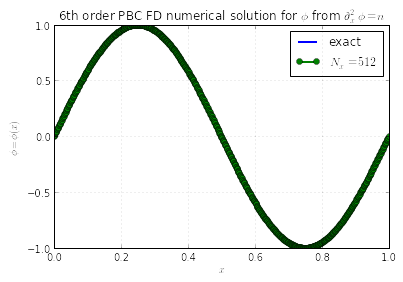

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 512
a,b = 0, 1
x = np.linspace(a,b,Nx)

n = -4*np.pi**2 * np.sin(2*np.pi * x[:Nx-1]) # excepting right endpoint, since n[Nx-1] = n[0]
phi_exact = np.sin(2*np.pi*x) # over all x

phi = Poisson_6th_PBC(n, Nx = Nx)
plt.plot(x, phi_exact, label = 'exact', linewidth = 2)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = %d$' % Nx, marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order PBC FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

Thus, the solve produces a periodic potential correct up to an additive constant. This is expected $\lambda = 0$ is an eigenvalue and the solution expressed in terms of its eigenbasis $\phi \sim \sum_k v_k e^{\lambda_k x}$ necessarily has an offset term at $\lambda_k = 0$ whose value is not uniquely enforced in the above through any boundary value, rather this value is only maintained to be equal to that of the other endpoint one period away from the other. Since this offset is unrestrained, the code chooses to center it about $\phi = 0$ by subtracting out the average value over the evolved gridpoints $i = 0, 1, \ldots , N-2$. Note, it is improper to subtract out the average over all gridpoints $i = 0, 1, \ldots, N-1$, as the final node does not strictly belong to the periodic cell, but is shared with the imagined adjacent cell (a full period spans $i = 0,1, \ldots , N -2$. That is, a periodic domain is extended over $(-\infty , \infty)$ by tesselating these cells and the period is $N - 1$ by construction, not $N$. This was a choice in the bookkeeping so that we can, for example, refer to $N$ nodes rather than $N+1$. The convention where $N+1$ nodes with period $N$ is also widely used throughout literature, perhaps even more often.

The convergence is shown as before:

Nx24        error = 1.50516e-07       ----
Nx48        error = 2.06842e-09       order = 6.18524
Nx96        error = 3.03337e-11       order = 6.09147
Nx192        error = 4.72383e-13       order = 6.00482
Nx384        error = 7.19179e-15       order = 6.03746
Nx768        error = 6.00248e-14       order = -3.06114
Nx1536        error = 3.88303e-13       order = -2.69355




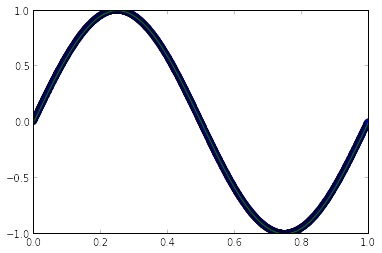

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA

Nx = [24, 48, 96, 192, 384, 768, 1536]
num_grids = len(Nx)

error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = -4*np.pi**2 * np.sin(2*np.pi * x[:Nx[grid]-1])

    phi = Poisson_6th_PBC(n, Nx = Nx[grid])
    phi_exact = np.sin(2 * np.pi * x)
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

plt.plot(x, phi, '-o')
plt.hold('on')
plt.plot(x,phi_exact)

## F.1.3 Periodic conditions applied with the Dirichlet Poisson solver: $\phi (a) = \phi (b)$

Here, we set the potential to be $\phi (0) = \phi (1) = 0$. If we wanted to match the FD solution just above we could enforce $\phi (0) = \phi (1) = 0.2$. We re-define the Dirichlet form just below to establish the same density as used above, and test the result:

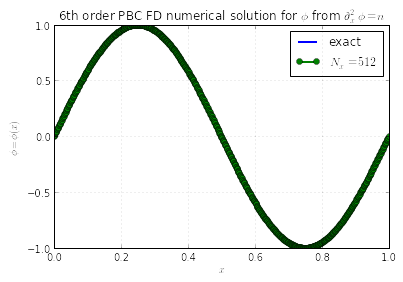

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 512
x = np.linspace(a,b,Nx)
n = -4*np.pi**2 * np.sin(2*np.pi * x)

phi_exact = np.sin(2*np.pi*x) # over all x
phi = Poisson_6th_LDBC_RDBC(n, Nx = Nx, LBC = 0, RBC = 0)

plt.plot(x, phi_exact, label = 'exact', linewidth = 2)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = %d$' % Nx, marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order PBC FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

## F.1.3.a Convergence tests

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)

error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = -4 * np.pi ** 2 * np.sin(2 * np.pi * x)

    phi = Poisson_6th_LDBC_RDBC(n, Nx = Nx[grid], LBC = 0, RBC = 0)
    phi_exact = np.sin(2 * np.pi * x)
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 1.05336e-05       ----
Nx24        error = 1.22653e-07       order = 6.42428
Nx48        error = 2.01851e-09       order = 5.92514
Nx96        error = 3.02425e-11       order = 6.06057
Nx192        error = 4.62274e-13       order = 6.03169
Nx384        error = 1.20113e-14       order = 5.26628
Nx768        error = 2.2936e-13       order = -4.25515
Nx1536        error = 4.06356e-13       order = -0.82513
Nx3072        error = 6.4988e-13       order = -0.67743




<b>Note</b>: it is obvious that the charge density $n_e - n_i$ must be consistent with the consequences of periodic boundary conditions on the potential. Failure to choose consistent densities $n_e$ and $n_i$ (e.g. choosing initial densities for the start of a simulation where they both evolve self-consistently) will cause the periodic BC solver to fail since, put in one way: subtracting out an "average" value does not center the density at zero so that integrating over $x$ does not give zero overall, but an offset persists, and the boundary conditions for $\phi$ that are purported to be periodic contradict the actual charge densities which are incapable of producing such periodicity in $\phi$.

### Consequences of periodicity and how to choose compatible densities $n_e$ and $n_i$

This has been stated above in the development noting that the matrix $\underline{\underline{D}}$ is circulant, but to wit consider the general multidimensional case:

$$\Delta \phi = f$$

where $f \equiv n_e - n_i$ is the source function. Numerically, we discretize the above to arrive at the equation

$$D\phi = b$$

where $D$ is a a discretization of the multidimensional Laplacian operator with accompanying Dirichlet boundary and $f$ is discretized straightforwardly. Note, that $A$ is positive definite, hence zero is not an eigenvalue and the matrix is nonsingular. Thus, there exists a solution for any $f$.

Now, consider $D$ as the disretization of the Laplacian withi periodic boundary. It was shown above this matrix is circulant, hence zero is an eigenvalue (matrix is positive <i>semi</i> definite), and the matrix is not invertible. There exists a kernel $K$ with solutions $\phi \equiv C = \text{const}$ belonging to the column space of $D$. Thus, $\text{range } D = K^{\perp}$ and $D\phi = f$ has no solution unless $1\cdot f = 0$, where $1 \equiv \underline{1}$ is the vector of all ones. Numerically, this statement is the solubility condition for the periodic Poisson problem. Analytically, it is perhaps easier to see. Consider $\phi \in C^2 (\Omega )$, we have

$$\Delta \phi = f$$

integrating over the domain, 

$$\int_{\Omega} \Delta \phi dV = \int_{\Omega} f dV$$


the left-hand side becomes

$$\int_{\Omega} \Delta \phi dV = \int_{\partial\Omega}\frac{\partial \phi}{\partial\vec{n}}dS = 0, \qquad \text{for a periodic boundary on } \phi$$

Thus, we have

$$0 = \int_{\Omega} f dV$$

(This is the same as $1\cdot f = 0$ in the numerical discussion above, i.e. the average value of $f$ must be zero).

In 1D over $x\in [a,b]$, for a source $f = n_e - n_i$ we have

$$0 = \int_a^b dx (n_e(x) - n_i(x))$$

#### Case 1: suppose $n_e = n_e(x)$ is chosen, $n_i(x) = \text{const}$ to be found consistently for periodic BCs$

The above gives

$$0 = \int_a^b dx n_e(x) - \int_a^b dx n_i$$

or

$$(b - a)n_i = \int_a^b dx n_e(x) \quad \Rightarrow \quad \boxed{n_i = \frac{\int_a^b dx n_e(x)}{b - a}}$$

#### Case 2: suppose $n_e = n_e(x)$ is chosen, $n_i = n_i(x)$ to be selected consistently for periodic BCs$

It is easy to see the above requirement amounts to:

$$\int_a^b dx n_i (x) = \int_a^b dx n_e(x)$$

or

$$\langle n_i \rangle_x = \langle n_e \rangle_x$$

Which restates what was just said, the average values must be hte same (so that the source $\langle f\rangle  = \langle n_e - n_i\rangle = 0$. Hence, it does not matter the shape of the functions so long as averages are the same.



# G. The Neumann-Dirichlet problem

Here we consider the conditions such as a Neumann boundary condition (NBC) on the left ($i = 0$), i.e. LNBC, paired with a Dirichlet boundary condition (DBC) on the right ($i = N-1$), i.e. RDBC, or the opposite: LDBC and RNBC. The general problem of two NBCs will be explored thereafter, though it is obvious that a unique solution may not be tractable in that case given the conditions do not uniquely specify one solution.

## G.1 General remarks on Neumann boundary condition (NBC) setup

With the motivation that centered differences provide higher fidelity derivative estimates to smooth functions as compared to sided differences, we note at the edge we can stagger the stencil somewhat beyond the left edge ($i = 0$) to make it "more" centered; however, we cannot do this too much to make it completely centered; the more centered we make it the more off-grid (ghost) points in $\phi_i$ ($i < 0$) are involved, which introduce extra unknowns.

At most, it turns out to be possible to include one ghost point easily (but no more) at each boundary we have an NBC at, e.g. at the boundary $i = 0$, if we write the NBC involving the ghost point $i = -1$ ($\phi_{-1}$), we can eliminate it by writing a statement of Poisson's equation centered at the gridpoint $i = 0$ (i.e. the LHS of $\partial_x^2\phi = n$ is $LHS \sim \phi_{-1} - 2\phi_0 + \phi_1$). Similarly if we had an NBC at the right edge $i = N-1$, we can involve the ghost point $\phi_N$ in the statement of the NBC at $i = N-1$, and eliminate it by a statement of Poisson's equation at the grid point $N-1$ (i.e. the LHS of $\partial_x^2\phi = n$ is $LHS \sim \phi_{N-2} - 2\phi_{N-1} + \phi_{N}$). 

If we try to be even more centered by estimating the Neumann condition using more points on the left (e.g. $\phi_{-2,}, \phi_{-3}, \ldots $), we do not have the required extra equations to eliminate these new unknowns so we emphasize again that the most centered we can be for differencing the Neumann condition without using extrapolation is an asymmetry by one grid point (forward-1 scheme for a left boundary or a backward+1 scheme for a right boundary) determine these values. 

Thus, we summarize the above thoughts:

<table "width = 100%">
<tr><td><b>Requirement 1:</b> Neumann boundary condition</td></td>
<tr><td>For a left boundary, estimate the first derivative according to
$${}$$
$$\text{LTE}[\delta_x\phi_0] = O(\Delta x^6)$$ 
$${}$$
using an explicit stencil involving $\{-1,0,1,2, \ldots \}$, i.e. a "forward-1" scheme.
$${}$$
or, for a right boundary
$${}$$
$$\text{LTE}[\delta_x\phi_{N-1}] = O(\Delta x^6)$$ 
$${}$$
using an explicit stencil involving $\{\ldots , N-3, N-2, N-1, N\}$, i.e. a "backward+1" scheme.
</td></tr>
</table>

As concerns the RHS of Poisson's euation (differencing in density, recall that higher order derivatives in $\phi$ were traded for lower orders in $n$), if we do not wish to use extrapolation methods, we must difference with only on-grid points for density (there exist no additional equations to eliminate ghost points of $n$ like there were for $\phi$ ghost points). Thus, since introducing a ghost point at either edge for $\phi$ required an additional Poisson equation centered about each edge node, the RHS of such statements must be sided (differencing density at the $i= 0$ or $i = N-1$ Poisson equation with forward 0 scheme or backward 0 scheme, respectively). Note, we cannot write down a Poisson's equation as it is not generally true that Poisson's equation governs the values of the fictive ghost point values $\phi_i, i < -1$. The requirement is framed as:

<table "width = 100%">
<tr><td><b>Requirement 2:</b> Differenced Poisson's equation at $i = 0$</td></td>
<tr><td>For a left boundary, estimate the density derivatives according to
$${}$$
$$LTE[n_{0}^{(2)}] = O(\Delta x^4)$$
$${}$$
$$LTE[n_{0}^{(4)}] = O(\Delta x^2)$$
$${}$$
Using <u>forward 0</u> schemes (completely forward differencing)
$${}$$
or, for a right boundary, require 
$${}$$
$$LTE[n_{N-1}^{(2)}] = O(\Delta x^4)$$
$${}$$
$$LTE[n_{N-1}^{(4)}] = O(\Delta x^2)$$
$${}$$
Using <u>backward 0</u> (completely backward differencing).
</td></tr>
</table>


# H. LNBC/RDBC solver

We consider the boundary conditions:

<ol>
<li> $\boxed{\partial_x\phi (a) = \phi_a'}, \phi_a'\in \mathbb{R}$
<li> $\boxed{\phi (b) \equiv \phi_{N-1} = \phi_b}$ are specified.
</ol>

for a bounded domain $x\in [a, b]$.

In our context in DECSKS-18 part 3, we use the lower (Neumann) boundary condition in order to enforce a symmetry condition ($\partial_x \phi (0) = 0$). We derive the general case here. The latter condition we have some Dirichlet context in mind (e.g. absorbing wall/charge collecting, or even a biased wall at constant potential)

We do not have work to do on the upper boundary, as the equations remain the same. As concerns the Neumann (lower) boundary, we require estimating this to adequate accuracy, that is to LTE order $O(\Delta x^6)$:

$$\text{requirement: } \qquad \delta_x \phi_0 = \partial_x\phi_a + O(\Delta x^6)$$

where as usual, $\delta_x$ is a finite difference operator compared to the continuous analog $\partial_x$.

To meet this requirement on the NBC, we generate the finite difference table needed for the first derivative at LTE order 6 and we use the forward-1 scheme

In [3]:
# wd: pyfiles/bin/

import generate_tables_of_finite_difference_schemes_for_a_given_LTE
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 1, LTE = 6)

This produces the file <code>f1_LTE_6_FD_coefficients.dat</code> for all schemes, the relevant scheme for our case is:

    f^(1): LTE = O(z^6)
    =========================
    f^(1): forward 1
    -------------------------
    (weights, stencil)
    -0.16667, -1
    -1.28333,  0
     2.50000,  1
    -1.66667,  2
     0.83333,  3
    -0.25000,  4
     0.03333,  5
    -------------------------

Or, equivalently we write each weight in $\mathbb{Q}$ as:

$$\text{stencil} = \{-1, 0, 1, 2, 3, 4, 5\}$$
$$\text{weights} = \{-\tfrac{1}{6}, -\tfrac{77}{60}, \tfrac{5}{2}, -\tfrac{5}{3}, \tfrac{5}{6}, -\tfrac{1}{4}, \tfrac{1}{30}\}$$

which is used to difference $\phi_0$ for the first derivative:

$$\phi^{(1)}_0 = \frac{1}{\Delta x}\left(-\frac{1}{6}\phi_{-1} - \frac{77}{60}\phi_0 + \frac{5}{2}\phi_1 - \frac{5}{3}\phi_2 + \frac{5}{6}\phi_3 - \frac{1}{4}\phi_4 + \frac{1}{30}\phi_5\right) + O(\Delta x^6)$$

Invoking the Neumann boundary condition, we have that $\phi_0^{(1)} = \phi_a'$, that is,

$$\frac{1}{\Delta x}\left(-\frac{1}{6}\phi_{-1} - \frac{77}{60}\phi_0 + \frac{5}{2}\phi_1 - \frac{5}{3}\phi_2 + \frac{5}{6}\phi_3 - \frac{1}{4}\phi_4 + \frac{1}{30}\phi_5\right) = \phi_a'$$

As promised, this differencing produces an off-grid unknown value of $\phi_{-1}$. Here, we solve for $\phi_{-1}$, and plan on using its result to elminate its present in the Poisson's equation statement centered at $i = 0$ (see below).

Solving for the ghost point:

\begin{eqnarray*}
\frac{1}{6}\phi_{-1} & = & -\frac{77}{60}\phi_0 + \frac{5}{2}\phi_1 - \frac{5}{3}\phi_2 + \frac{5}{6}\phi_3 - \frac{1}{4}\phi_4 + \frac{1}{30}\phi_5 -(\Delta x) \phi_a' \\
\end{eqnarray*}

or

$$\boxed{\phi_{-1} =  -\frac{77}{10}\phi_0 + 15\phi_1 - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5 -6(\Delta x) \phi_a'}$$

We now investigate the form of Poisson's equation centered at the node $i = 0$, which also will involve $\phi_{-1}$. The general statement, as usual, is given by a form of eq. $(*)$:

$$\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \phi_{-1}\right) = n_{0} + \frac{2}{4!}(\Delta x)^2n_{0}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{0}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

Note, here we write $n_{i} \, (i = 0)$ as the $i$th point of the total density $n$ for generality, that is $n_i = n_{e,i} - n_{i,i}$, it is not to be confused with the ion density itself.

Recall on the right-hand side we have traded higher order derivatives of $\phi$ (wider stencils if explicit differencing) for lower order derivatives in $n$. Noting that we do not have information regarding the density at ghost points, we require sided differences. 

We do not wish to use extrapolation methods here, hence we need difference the density involving only on-grid locations. We could do this implicitly or explicitly, we choose the latter to reduce considerations here as well as perhaps the more intensive computational solution (which may not be a fair reason, this is a claim made from shallow observation). 

For the density derivatives, we generate the following forward 0 schemes from the generating scripts:

In [4]:
# wd: pyfiles/bin/

import generate_tables_of_finite_difference_schemes_for_a_given_LTE

generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 2, LTE = 4)
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 4, LTE = 2)

The output creates the data files <code>f2_LTE_4_FD_coefficients.dat</code> and <code>f4_LTE_2_FD_coefficients.dat</code> which give the finite difference coefficients and corresponding stencils of all schemes. The relevant schemes for us include:

    =========================
    f^(2): LTE = O(z^4)
    =========================
    
    f^(2): forward 0
    -------------------------
    (weights, stencil)
     3.75000,   0
    -12.83333,  1
     17.83333,  2
    -13.00000,  3
     5.08333,   4
    -0.83333,   5
    -------------------------

or, 

$$\text{stencil} = \{0, 1, 2, 3, 4, 5\}$$
$$\text{weights} = \{\tfrac{15}{4}, -\tfrac{77}{6}, \tfrac{107}{6}, -13, \tfrac{61}{12}, -\tfrac{5}{6}\}$$

in terms of $n$, we have

$$n_0^{(2)} = \frac{1}{(\Delta x)^2}\left(\frac{15}{4}n_0 -\frac{77}{6}n_1 + \frac{107}{6}n_2 -13n_3 + \frac{61}{12}n_4 -\frac{5}{6}n_5\right)  + O(\Delta x^4)$$

and

    =========================
    f^(4): LTE = O(z^2)
    =========================
    
    f^(4): forward 0
    -------------------------
    (weights, stencil)
     3.00000,   0
    -14.00000,  1
     26.00000,  2
    -24.00000,  3
     11.00000,  4
    -2.00000,   5
    -------------------------
    
or, 

$$\text{stencil} = \{0, 1, 2, 3, 4, 5\}$$
$$\text{weights} = \{3, -14, 26, -24, 11, -2\}$$

in terms of $n$, we have

$$n_0^{(4)} = \frac{1}{(\Delta x)^4}\left(3n_0 -14 n_1 + 26 n_2  - 24 n_3 + 11n_4 -2 n_5\right) + O(\Delta x^2)$$



Putting this altogether in eq. $(*)$

$$\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \phi_{-1}\right) = n_{0} + \frac{2}{4!}(\Delta x)^2n_{0}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{0}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * , \,\text{revisited} )$$

we have

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \phi_{-1}\right) & = & n_{0} + \frac{2}{4!}(\Delta x)^2n_{0}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{0}^{(4)} + O(\Delta x^6)\\
&&\\
& = & n_{0} + \frac{2}{4!}(\Delta x)^2\left\{\frac{1}{(\Delta x)^2}\left(\frac{15}{4}n_0 -\frac{77}{6}n_1 + \frac{107}{6}n_2 -13n_3 + \frac{61}{12}n_4 -\frac{5}{6}n_5\right)  + O(\Delta x^4)\right\} + \frac{2}{6!}(\Delta x)^4\left\{\frac{1}{(\Delta x)^4}\left(3n_0 -14 n_1 + 26 n_2  - 24 n_3 + 11n_4 -2 n_5\right) + O(\Delta x^2)\right\} + O(\Delta x^6) \\
&&\\
& = & n_{0} + \frac{2}{4!}\left\{\left(\frac{15}{4}n_0 -\frac{77}{6}n_1 + \frac{107}{6}n_2 -13n_3 + \frac{61}{12}n_4 -\frac{5}{6}n_5\right)\right\} + \frac{2}{6!}\left\{\left(3n_0 -14 n_1 + 26 n_2  - 24 n_3 + 11n_4 -2 n_5\right)\right\} + O(\Delta x^6) \\
&&\\
& = & \left[1 + \frac{2}{4!}\left(\frac{15}{4}\right) + \frac{2}{6!}(3)\right]n_{0} \\
&& + \left[\frac{2}{4!}\left(-\frac{77}{6}\right) + \frac{2}{6!}(-14)\right]n_1 \\
&& + \left[\frac{2}{4!}\left(\frac{107}{6}\right) + \frac{2}{6!}(26)\right]n_2 \\
&& + \left[\frac{2}{4!}(-13) + \frac{2}{6!}(-24)\right]n_3 \\
&& + \left]\frac{2}{4!}\left(\frac{61}{12}\right) + \frac{2}{6!}(11)\right]n_4 \\
&& + \left[\frac{2}{4!}\left(-\frac{5}{6}\right) + \frac{2}{6!}(-2)\right]n_5 \\
&& + O(\Delta x^6)
&&\\
\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \phi_{-1}\right)  & = & \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + O(\Delta x^6)
\end{eqnarray*}

Recalling that

$$\phi_{-1} =  -\frac{77}{10}\phi_0 + 15\phi_1 - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5 -6(\Delta x) \phi_a'$$

we eliminate the unknown ghost point by insertion into the above equation:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \phi_{-1}\right)  & = & \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + O(\Delta x^6) \\
&&\\
\frac{1}{(\Delta x)^2}\left(\phi_{1} - 2\phi_0 + \left[-\frac{77}{10}\phi_0 + 15\phi_1 - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5 -6(\Delta x) \phi_a'\right]\right)  & = & \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + O(\Delta x^6) \\ 
&& \\
\frac{1}{(\Delta x)^2}\left(-\frac{97}{10}\phi_0 + 16\phi_{1} - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5 -6(\Delta x) \phi_a'\right)  & = & \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + O(\Delta x^6) \\ 
\end{eqnarray*}

or

$$\boxed{\frac{1}{(\Delta x)^2}\left(-\frac{97}{10}\phi_0 + 16\phi_{1} - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5\right)  =  \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + \frac{6}{\Delta x} \phi_a'}\qquad \text{Poisson's equation at } i = 0$$ 


That completes the additional equations required for the Neumann condition. We now move onto assembling the matrix problem.

## H.1 Assembling the matrix problem (NBC/DBC)

With the $N-1$ differenced Poisson's equations (for nodes $i = 0, 1, 2, \ldots N-2$) + 1 Dirichlet boundary condition that are known a priori, we have $N$ equations for $N$ unknowns ($\phi_i, \, i = 0, 1, 2, \ldots N-1$). We write several equations for various indices $i$ in order to clearly see the matrix take form. We wish to set up the discrete problem as follows:

$$\partial_x^2\phi = n \qquad \longrightarrow \qquad \frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \text{ or } \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b} \qquad (H.1)$$

The left-hand side ($\partial_x^2 \phi \simeq \underline{\underline{D}}\underline{\phi})$ has the factor of $(\Delta x)^2$ brought to the right-hand side. With this understanding, we have the following set of scalar equations to organize: 

$$-\frac{97}{10}\phi_0 + 16\phi_{1} - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5  =  (\Delta x)^2\left[\frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5\right] + 6 (\Delta x) \phi_a'$$

\begin{eqnarray*}
i = 0: & \phi_{-1} - 2\phi_0 + \phi_{1} & = \phantom{-}(\Delta x)^2\left[\frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5\right] \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & =  \phantom{-}(\Delta x)^2\left[\frac{3}{40}n_{0} + \frac{209}{240}n_{1} + \frac{1}{60}n_{2} + \frac{7}{120}n_{3} - \frac{1}{40}n_{4} + \frac{1}{240}n_{5}\right] \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = (\Delta x)^2\left[-\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4}\right] \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & =  (\Delta x)^2\left[-\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5}\right] \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2}\right] \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{N-1}\right] \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = \phantom{-}(\Delta x)^2\left[\frac{1}{240}n_{N-6} - \frac{1}{40}n_{N-5} + \frac{7}{120}n_{N-4} + \frac{1}{60}n_{N-3} + \frac{209}{240}n_{N-2} + \frac{3}{40}n_{N-1}\right] \\[1em]
i = N-1: & (\Delta x)^2\phi_{N-1}  & = \phantom{-}(\Delta x)^2\phi_b
\end{eqnarray*}


We choose to partition the density matrices and the boundary values as follows, by writing:

$$\underline{b} = \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + \frac{1}{(\Delta x)^2} \underline{\phi}_{BC}$$

So that the above becomes 

$$\underline{\underline{D}}_{N\times N}\cdot\underline{\phi}_{N\times 1} = (\Delta x)^2\cdot \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + (\underline{\phi}_{BC})_{N\times 1}$$

Notice that reviewing the $i = N-1$ equation allows us to omit the factors of $(\Delta x)^2$ as they appear on both sides of the equation provided that the matrix $\underline{\underline{B}}$ contains a row of zeros for the last row so as to make the $i = N-1$ equation independent of density as above. 

Along similar reasoning, the $i = 0$ equation shows we can have the first entry of the auxillian $\underline{\phi}$ be $6(\Delta x)\phi_a'$. Thus, we have form the following objects:

Where 

$$(\underline{\phi}_{BC})_{N\times 1} = [(6(\Delta x) \phi_a', 0 , 0, \ldots , 0 , \phi_b)^T]_{(N+1)\times 1}$$

the density vector 

$$\underline{n}_{N\times 1} = (n_0, n_1, n_2, \ldots , n_{N-2}, n_{N-1})^T$$

the difference matrix $\underline{\underline{D}}$ then takes the form  (LHS = "left-hand side"):

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
i = 0: \, \text{central differencing on } \{\phi_i\}  \text{ with $\phi_{-1}$ ghost point eliminated by NBC} \\
i = 1: \, \text{central differencing FD coefficients on }  \{\phi_i\}\\
i = 2: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = 3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = N-2: \, \text{central differencing FD coefficients on }   \{\phi_j\}\\
i = N-1: \, \text{Dirichlet BC LHS coefficient of: } 1\cdot\phi_{N-1} = \phi_b 
\end{array} \right)$$

which takes the form,

 $$\underline{\underline{D}} = \left( \begin{array}{c c c c c c c c c}
-\frac{97}{10} & 16 & -10 &  5 & -\frac{3}{2} & \frac{1}{5} & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{array} \right)$$


<table "width = 85%">
<tr><td><b>Solubility</b></td></tr>
<tr><td>
The determinant $\text{det}(\underline{\underline{D}}) = -6$ of the matrix $\underline{\underline{D}}$ is nonzero and thus invertible, hence a unique solution exists.
</td></tr>
</table>

Similarly, by reviewing the above set of scalar equations, we show the form of the matrix $\underline{\underline{B}}_{N\times N}$:

$$\underline{\underline{B}} = \left( \begin{array}{c}
i = 0 \text{, Neumann boundary condition factored in with auxillary vector, } \underline{\phi}_{BC} \text{ forward 0 differencing scheme on density} \\
i = 1 \text{, forward-1 differencing scheme} \\
i = 2 \text{, central differencing scheme} \\
i = 3 \text{, central differencing scheme} \\
\vdots \\
i = N-3 \text{, central differencing scheme} \\
i = N-2 \text{, backward+1 differencing scheme} \\
i = N-1 \text{, Dirichlet boundary condition factored in with auxillary vector, } \underline{\phi}_{BC}, \text{ density not involved } \ldots = \underline{0} \\
\end{array} \right)_{(N+1)\times (N+1)}
=  \left( \begin{array}{c c c c c c c c c c c c c c}
\frac{317}{240} & -\frac{133}{120} & \frac{187}{120} & -\frac{23}{20}  & \frac{109}{240}  & - \frac{3}{40} & 0 & \cdots & \cdots  &0 \\ 
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots  & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0  \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots  & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots  & 0\\
\vdots & \vdots & 0 & \ddots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0 &  0&   0 &  0 &  0  &  0 &  0\\
\end{array} \right)_{N\times N}$$

## H.2 Implementation

### Poisson_6th_LNBC_RDBC.py

At some point we will consolidate these routines. Here, LNBC = Left Neumann boundary condition, RDBC = Right Dirichlet boundary condition

In [41]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_6th_LNBC_RDBC(n, Nx = 24, a = 0., b = 1., LBC = 0., RBC = 1.):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx)

    # assemble differencing matrix
   
    D = np.zeros((Nx,Nx))
    
    # LNBC row
    D[0,0] = -97/10. 
    D[0,1] = 16.
    D[0,2] = -10
    D[0,3] = 5.
    D[0,4] = -3/2. 
    D[0,5] = 1/5.
    
    # RDBC row
    D[-1,-1] = 1.
    
    # Poisson's equation rows
    for i in range(1,Nx-1):
        D[i,i-1] = 1
        D[i,i] = -2
        D[i,i+1] = 1


    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx,Nx))
    for i in range(B.shape[0]):
        if i == 0:
            B[i,i] = 317 / 240.
            B[i,i+1] = -133/120.
            B[i,i+2] = 187 / 120.
            B[i,i+3] = -23 / 20.
            B[i,i+4] = 109 / 240.
            B[i,i+5] = -3/40.

        elif i == 1:

            B[i, i-1] = 3 / 40.
            B[i, i] = 209 / 240.
            B[i,i+1] = 1 / 60.
            B[i,i+2] = 7 / 120.
            B[i,i+3] = -1 / 40.
            B[i,i+4] = 1 / 240.

        elif 2 <= i <= Nx-3:

            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:

            B[i,i+1] = 3 / 40.
            B[i,i] = 209 / 240.
            B[i,i-1] = 1 / 60.
            B[i,i-2] = 7 / 120.
            B[i,i-3] = -1 / 40.
            B[i,i-4] = 1 / 240.

        # else i == Nx-1: row of zeros

    phi_BC = np.zeros(Nx)

    phi_BC[0] = 6 * dx * LBC
    phi_BC[-1] = RBC

    b = dx ** 2 * B.dot(n) + phi_BC
    phi = LA.solve(D,b)

    return phi

## H.3 Convergence tests

We consdider the Poisson problem,

$$\partial_x^2 \phi = n, \qquad n = \cos (2\pi x) + x$$

where

$$\partial_x\phi (0) = 0, \,\,\phi (1) = \frac{1}{6}$$

Whose exact solution is

$$\phi_{exact}(x) \frac{1}{4\pi^2}\left[1 - \cos (2\pi x)\right] + \frac{1}{6}x^3$$

For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{2\pi} \sin (2\pi x) + \frac{1}{2}x^2$$

Which can be noticed to satisfy the left edge Neumann condition, whereas the Dirichlet condition is clearly met by the right edge.

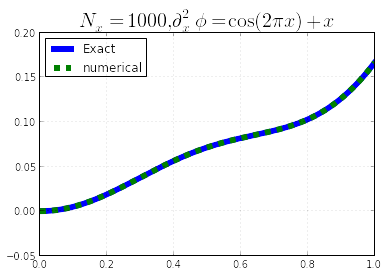

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x) + x

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
phi = Poisson_6th_LNBC_RDBC(n, Nx, a, b, LBC = 0., RBC = 1/6.)

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x) + x$', fontsize = 20)
plt.legend(loc = 'best')

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x) + x
    phi = Poisson_6th_LNBC_RDBC(n, Nx[grid], a, b, LBC = 0., RBC = 1/6.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 6.60477e-05       ----
Nx24        error = 4.63165e-07       order = 7.15584
Nx48        error = 3.20388e-09       order = 7.17556
Nx96        error = 2.29182e-11       order = 7.12718
Nx192        error = 1.69894e-13       order = 7.07572
Nx384        error = 3.20751e-15       order = 5.72703
Nx768        error = 2.17774e-14       order = -2.76331
Nx1536        error = 5.40695e-14       order = -1.31198
Nx3072        error = 6.11828e-14       order = -0.178312




Thus, we recover an order of 7 (somehow).

If we were to change the differencing scheme on the Neumann condition to be first order:

$$\partial_x\phi (0) \simeq \frac{\phi_0 - \phi_{-1}}{\Delta x}$$

i.e. the stencil is $\{-1,1\}$, so that we write in the difference matrix:

    D[0,0] = -1 * dx
    D[0,1] = 1 * dx
    
Whose action is on the $\phi$ vector, i.e. $D_{0,0}\phi_{-1} + D_{0,1}\phi_0 + D_{0,2}\phi_1 + \ldots$ where $D_{0,j \neq 0,1} = 0$, we would retrieve significantly less accuracy (obviously, but we would like to juxtapose the difference here):

#### Comparison with a first order Neumann boundary

In [50]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_1st_LNBC_RDBC(n, Nx = 24, a = 0., b = 1., phi_LNBC = 0., phi_RDBC = 1.):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx+1)
    N[1:] = n

    # assemble differencing matrix
    D = np.zeros((Nx+1,Nx+1))
    D[0,0] = -1 * dx
    D[0,1] = 1 * dx
    D[-1,-1] = 1.
    
    for i in range(1,D.shape[0]-1):
        D[i,i-1] = 1
        D[i,i] = -2
        D[i,i+1] = 1


    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx+1,Nx+1))
    for i in range(B.shape[0]):
        if i == 1:
            B[i,i] = 317 / 240.
            B[i,i+1] = -133/120.
            B[i,i+2] = 187 / 120.
            B[i,i+3] = -23 / 20.
            B[i,i+4] = 109 / 240.
            B[i,i+5] = -3/40.

        elif i == 2:

            B[i, i-1] = 3 / 40.
            B[i, i] = 209 / 240.
            B[i,i+1] = 1 / 60.
            B[i,i+2] = 7 / 120.
            B[i,i+3] = -1 / 40.
            B[i,i+4] = 1 / 240.

        elif 3 <= i <= Nx-2:

            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-1:

            B[i,i+1] = 3 / 40.
            B[i,i] = 209 / 240.
            B[i,i-1] = 1 / 60.
            B[i,i-2] = 7 / 120.
            B[i,i-3] = -1 / 40.
            B[i,i-4] = 1 / 240.

        # else i == N: row of zeros

    phi_BC = np.zeros(Nx+1)

    phi_BC[0] = dx * phi_LNBC
    phi_BC[-1] = phi_RDBC

    b = dx ** 2 * B.dot(N) + phi_BC
    phi = LA.solve(D,b)
    
    # contains values phi_{-1}, phi_0, phi_1, ... , phi_{N-1}, return only on-grid values [0, N-1]

    return phi[1:]

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x) + x
    phi = Poisson_1st_LNBC_RDBC(n, Nx[grid], a, b, phi_LNBC = 0., phi_RDBC = 1/6.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 0.0264694       ----
Nx24        error = 0.012692       order = 1.0604
Nx48        error = 0.00618641       order = 1.03675
Nx96        error = 0.0030508       order = 1.01991
Nx192        error = 0.00151454       order = 1.01031
Nx384        error = 0.000754523       order = 1.00524
Nx768        error = 0.000376571       order = 1.00264
Nx1536        error = 0.000188113       order = 1.00133
Nx3072        error = 9.40131e-05       order = 1.00066




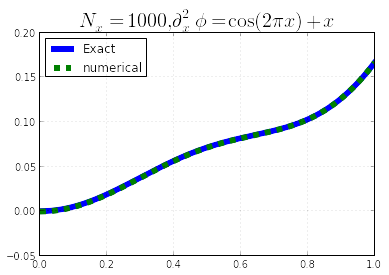

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x) + x

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
phi = Poisson_1st_LNBC_RDBC(n, Nx, a, b, phi_LNBC = 0., phi_RDBC = 1/6.)

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x) + x$', fontsize = 20)
plt.legend(loc = 'best')

Which shows a clear difference in errors for each grid size; we need to have as fine a mesh as $N_x = 3072$ on the first order solver to approach an error $\sim 10^{-5}$ which the 6th order solver achieves with as course a mesh as $N_x < 12$. Thus, the benefit of our high order difference is clear.

<font color = "blue">We now work thorugh several permutations of the above boundary conditions in efforts to afterwards unify them into a single routine</font>

# I. LDBC/RNBC solver

We consider the opposite boundary conditions

<ol>
<li>$\boxed{\phi (x_0) = \phi_a}$
<li>$\boxed{\partial_x  \phi (x_{N-1})  = \phi_b'}$
</ol>

The changes require adding a ghost point now pertaining to the value $\phi_{N}$ (grid values are between $0\leq i \leq N-1$). Thus, we also require one more equation which is Poisson's equation at the previously unused gridpoint, $i = N_x-1$, which we require backward+1 differencing at an LTE order 6 for differencing of the potential function, as well as completely backward differencing at the required LTE for each density derivative that shows up.

### Additional equations involved

Recall requirement 1:

<table "width = 100%">
<tr><td><b>Requirement 1:</b> Neumann boundary condition</td></td>
<tr><td>Estimate the first derivative according to
$${}$$
$$\text{LTE}[\delta_x\phi_{N_x-1}] = O(\Delta x^6)$$ 
$${}$$
using an explicit stencil involving $\{\ldots , -2, -1, 0, 1\}$, i.e. a "backward+1" scheme.
</td></tr>
</table>

Which can be produced from the generating scripts:

In [47]:
# wd: pyfiles/bin/

import generate_tables_of_finite_difference_schemes_for_a_given_LTE
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 1, LTE = 6)

We obtain the following table of weights, we paste the previously used forward-1 difference for the LNBC section just above for juxtaposition:

    f^(1): LTE = O(z^6)
    =========================
    f^(1): backward 1
    -------------------------
    (weights, stencil)
    -0.03333, -5
    0.25000, -4
    -0.83333, -3
    1.66667, -2
    -2.50000, -1
    1.28333,  0
    0.16667,  1
    -------------------------
    f^(1): forward 1
    -------------------------
    (weights, stencil)
    -0.16667, -1
    -1.28333,  0
    2.50000,  1
    -1.66667,  2
    0.83333,  3
    -0.25000,  4
    0.03333,  5
    -------------------------
    
So we can see the backward+1 difference schemes shares the same magnitude of the weights in the forward-1 scheme, just they are in reverse order and the signs themselves are opposite. Thus, we can write down for the backward+1 scheme, which we need for our RNBC case as:

Or, equivalently we write each weight in $\mathbb{Q}$ as:

$$\text{stencil} = \{-5, -4, -3, -2, -1, 0, 1\}$$
$$\text{weights} = \{-\tfrac{1}{30},\tfrac{1}{4}, -\tfrac{5}{6}, \tfrac{5}{3}, -\tfrac{5}{2}, \tfrac{77}{60}, \tfrac{1}{6}\}$$

which upon enforcing the boundary value $\phi_b'$ becomes

$$\phi^{(1)}_{N_x-1} = \frac{1}{\Delta x}\left(-\frac{1}{30}\phi_{N_x-6} + \frac{1}{4}\phi_{N_x-5} - \frac{5}{6}\phi_{N_x-4} + \frac{5}{3}\phi_{N_x-3} - \frac{5}{2}\phi_{N_x-2} + \frac{77}{60}\phi_{N_x-1} + \frac{1}{6}\phi_{N_x}\right) = \phi_b'$$

Solving for the off-grid value $\phi_{N_x}$:

$$\boxed{\phi_{N_x} = 6(\Delta x)\phi_b' + \frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 15\phi_{N_x-2} - \frac{77}{10}\phi_{N_x-1}}$$

Which we will use in the Poisson statement at $i = N_x-1$:

$$\frac{1}{(\Delta x)^2}\left(\phi_{N_x} - 2\phi_{N_x-1} + \phi_{N_x-2}\right) = n_{N_x-1} + \frac{2}{4!}(\Delta x)^2n_{N_x-1}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{N_x-1}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

Before eliminating $\phi_{N_x}$, we discern the right-hand side:

<table "width = 100%">
<tr><td><b>Requirement 2:</b> Differenced Poisson's equation at $i = N_x-1$</td></td>
<tr><td>Estimate the density derivatives according to
$${}$$
$$LTE[n_{N_x-1}^{(2)}] = O(\Delta x^4)$$
$${}$$
$$LTE[n_{N_x-1}^{(4)}] = O(\Delta x^2)$$
$${}$$
Using <u>backward 0</u> schemes (completely backward differencing)
</td></tr>
</table>

For the differencing on $n$, we generate the tables again for our review:

In [27]:
# wd: pyfiles/bin/

import generate_tables_of_finite_difference_schemes_for_a_given_LTE

generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 2, LTE = 4)
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 4, LTE = 2)

As before, we paste the forward schemes for comparison, which were used in the previous section for a LNBC


    f^(2): LTE = O(z^4)
    =========================
    f^(2): forward 0
    -------------------------
    (weights, stencil)
    3.75000,  0
    -12.83333,  1
    17.83333,  2
    -13.00000,  3
    5.08333,  4
    -0.83333,  5
    -------------------------
    f^(2): backward 0
    -------------------------
    (weights, stencil)
    -0.83333, -5
    5.08333, -4
    -13.00000, -3
    17.83333, -2
    -12.83333, -1
    3.75000,  0
    -------------------------
        
        f^(4): LTE = O(z^2)
    =========================
    f^(4): forward 0
    -------------------------
    (weights, stencil)
    3.00000,  0
    -14.00000,  1
    26.00000,  2
    -24.00000,  3
    11.00000,  4
    -2.00000,  5
    -------------------------
    f^(4): backward 0
    -------------------------
    (weights, stencil)
    -2.00000, -5
    11.00000, -4
    -24.00000, -3
    26.00000, -2
    -14.00000, -1
    3.00000,  0
    -------------------------
    
Thus, we see the same coefficients are used in both schemes, but they run in reverse, and the same signs are used. This was previously found in other notebooks that the ostensible trend for one scheme vs. its backward scheme is a minus sign to the power of its derivative, i.e. odd derivatives have schemes with coefficients that run backwards and are of opposite sign $(-1)^{2q+1} = -1$, whereas even derivatives have schemes with coefficients that run backwards and are of the same sign $(-1)^{2q} = 1$.

Thus, we can write down the stencils and differences straightforwardly as in the previous section. The coefficients for each derivative in eq. $(*)$ above have been worked through in section J, they remain unchanged numerically, 

$$\frac{1}{(\Delta x)^2}\left(\phi_{-1} - 2\phi_0 + \phi_{1}\right) = \frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5 + O(\Delta x^6) \qquad i = 0 \quad \text{from section I}$$

we just have them running in the opposite direction (from $i = N_x-1$ down to $i = N_x-6$), there is no changes to the left-hand side's second order difference for $\phi$ (recall that the terms that appear on the right hande side *are* equivalent representations of $\phi$ derivatives which have been traded for $n$ derivatives per the PDE):

$$\frac{1}{(\Delta x)^2}\left(\phi_{N_x-2} - 2\phi_{N_x-1} + \phi_{N_x}\right) = \frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6} + O(\Delta x^6)$$

Using the NBC to eliminate the ghost value $\phi_{N_x}$:

$$\frac{1}{(\Delta x)^2}\left(\phi_{N_x-2} - 2\phi_{N_x-1} + \left[6(\Delta x)\phi_b' + \frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 15\phi_{N_x-2} - \frac{77}{10}\phi_{N_x-1}\right]\right) = \frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6} + O(\Delta x^6)$$

or
<table "width = 95%">
<tr><td>
$${}$$
$$\frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 16\phi_{N_x-2} - \frac{97}{10}\phi_{N_x-1} = (\Delta x)^2\left(\frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6}\right) - 6(\Delta x)\phi_b'$$
$${}$$
</td></tr>
</table>

## I.1 Assembling the matrix problem (DBC/NBC)

We proceed as in section I. With the $N-1$ differenced Poisson's equations (for nodes $i = 1, 2, \ldots N-1$) + 1 Dirichlet boundary condition that are known a priori at $i = 0$, we have $N$ equations for $N$ unknowns ($\phi_i, \, i = 0, 1, 2, \ldots N-1$). We write several equations for various indices $i$ in order to clearly see the matrix take form. We wish to set up the discrete problem as follows:

$$\partial_x^2\phi = n \qquad \longrightarrow \qquad \frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \text{ or } \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b} \qquad (H.1)$$

The left-hand side ($\partial_x^2 \phi \simeq \underline{\underline{D}}\underline{\phi})$ has the factor of $(\Delta x)^2$ brought to the right-hand side. With this understanding, we have the following set of scalar equations to organize: 

\begin{eqnarray*}
i = 0: & (\Delta x)^2\phi_{0}  & = \phantom{-}(\Delta x)^2\phi_a \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & =  \phantom{-}(\Delta x)^2\left[\frac{3}{40}n_{0} + \frac{209}{240}n_{1} + \frac{1}{60}n_{2} + \frac{7}{120}n_{3} - \frac{1}{40}n_{4} + \frac{1}{240}n_{5}\right] \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = (\Delta x)^2\left[-\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4}\right] \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & =  (\Delta x)^2\left[-\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5}\right] \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2}\right] \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{N-1}\right] \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = \phantom{-}(\Delta x)^2\left[\frac{1}{240}n_{N-6} - \frac{1}{40}n_{N-5} + \frac{7}{120}n_{N-4} + \frac{1}{60}n_{N-3} + \frac{209}{240}n_{N-2} + \frac{3}{40}n_{N-1}\right]
\end{eqnarray*}

and at $i = N-1$:

$$\frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 16\phi_{N_x-2} - \frac{97}{10}\phi_{N_x-1} = (\Delta x)^2\left(\frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6}\right) - 6(\Delta x)\phi_b'$$

We choose to partition the density matrices and the boundary values as follows, by writing:

$$\underline{b} = \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + \frac{1}{(\Delta x)^2} \underline{\phi}_{BC}$$

So that the above becomes 

$$\underline{\underline{D}}_{N\times N}\cdot\underline{\phi}_{N\times 1} = (\Delta x)^2\cdot \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + (\underline{\phi}_{BC})_{N\times 1}$$

Notice that reviewing the $i = 0$ equation allows us to omit the factors of $(\Delta x)^2$ as they appear on both sides of the equation provided that the matrix $\underline{\underline{B}}$ contains a row of zeros for the first row so as to make the $i = 0$ equation independent of density as above. 

Along similar reasoning, the $i = N-1$ equation shows we can have the first entry of the auxillian $\underline{\phi}$ be $-6(\Delta x)\phi_b'$ (note, this is the opposite sign as compared to when we had an NBC at the left boundary). Thus, we have form the following objects:

$$(\underline{\phi}_{BC})_{N\times 1} = [(\phi_a', 0 , 0, \ldots , 0 , -6(\Delta x)\phi_b)^T]_{(N+1)\times 1}$$

the density vector 

$$\underline{n}_{N\times 1} = (n_0, n_1, n_2, \ldots , n_{N-2}, n_{N-1})^T$$

the difference matrix $\underline{\underline{D}}$ then takes the form  (LHS = "left-hand side"):

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
i = 0: \, \text{Dirichlet BC LHS coefficient of: } 1\cdot\phi_{0} = \phi_a  \\
i = 1: \, \text{central differencing FD coefficients on }  \{\phi_i\}\\
i = 2: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = 3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = N-2: \, \text{central differencing FD coefficients on }   \{\phi_j\}\\
i = N-1: \, \text{central differencing on } \{\phi_i\}  \text{ with $\phi_{N}$ ghost point eliminated by NBC} \\
\end{array} \right)$$

which takes the form,

 $$\underline{\underline{D}} = \left( \begin{array}{c c c c c c c c c}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 &  0 & \frac{1}{5} & -\frac{3}{2} & 5 & -10 & 16 & -\frac{97}{10}  \\
\end{array} \right)$$

<table "width = 85%">
<tr><td<font size = 24><b>Solubility</b></font></td></tr>
<tr><td>
The determinant $\text{det}(\underline{\underline{D}}) = -6$ of the matrix $\underline{\underline{D}}$ is nonzero and thus invertible, hence a unique solution exists.
</td></tr>
</table>

Similarly, by reviewing the above set of scalar equations, we show the form of the matrix $\underline{\underline{B}}_{N\times N}$:

$$\underline{\underline{B}} = \left( \begin{array}{c}
i = 0 \text{, Dirichlet boundary condition factored in with auxillary vector, } \underline{\phi}_{BC}, \text{ density not involved } \ldots = \underline{0} \\
i = 1 \text{, forward-1 differencing scheme} \\
i = 2 \text{, central differencing scheme} \\
i = 3 \text{, central differencing scheme} \\
\vdots \\
i = N-3 \text{, central differencing scheme} \\
i = N-2 \text{, backward+1 differencing scheme} \\
i = N-1 \text{, Neumann boundary condition factored in with auxillary vector, } \underline{\phi}_{BC} \text{ backward 0 differencing scheme on density}
\end{array} \right)_{(N+1)\times (N+1)}
=  \left( \begin{array}{c c c c c c c c c c c c c c}
0 & 0 & 0 & 0 &  0&   0 &  0 &  0  &  0 &  0\\
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots  & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0  \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots  & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots  & 0\\
\vdots & \vdots & 0 & \ddots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0  & - \frac{3}{40}  & \frac{109}{240}  & -\frac{23}{20} & \frac{187}{120} & -\frac{133}{120}  & \frac{317}{240}\\ 
\end{array} \right)_{N\times N}$$

The solution of this matrix problem gives values for $\phi_0, \phi_1, \ldots, \phi_{N-1}$ for all on-grid values as well as one ghost value $\phi_N$. In the implementation we return only on grid values $i\in [0,N-1]$.

We now test the above setup:

## I.2 Implementation

### Poisson_6th_LDBC_RNBC.py

In [55]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_6th_LDBC_RNBC(n, Nx = 24, a = 0., b = 1., LBC = 0., RBC = 1.):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    phi -- (ndarray, ndim = 1) numerical solution to potential
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx)

    # assemble differencing matrix
   
    D = np.zeros((Nx,Nx))
    
    # RDBC row
    D[0,0] = 1.
    
    # LNBC row
    D[-1,-1] = -97/10. 
    D[-1,-2] = 16.
    D[-1,-3] = -10
    D[-1,-4] = 5.
    D[-1,-5] = -3/2. 
    D[-1,-6] = 1/5.
      
    # Poisson's equation rows
    for i in range(1,Nx-1):
        D[i,i-1] = 1
        D[i,i] = -2
        D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx,Nx))
    for i in range(B.shape[0]):
        # i == 0 row contains all zeros

        if i == 1:

            B[i, i-1] = 3 / 40.
            B[i, i] = 209 / 240.
            B[i,i+1] = 1 / 60.
            B[i,i+2] = 7 / 120.
            B[i,i+3] = -1 / 40.
            B[i,i+4] = 1 / 240.

        elif 2 <= i <= Nx-3:

            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:

            B[i,i+1] = 3 / 40.
            B[i,i] = 209 / 240.
            B[i,i-1] = 1 / 60.
            B[i,i-2] = 7 / 120.
            B[i,i-3] = -1 / 40.
            B[i,i-4] = 1 / 240.
            
        if i == Nx-1:
            B[i,i-5] = -3/40.
            B[i,i-4] = 109 / 240.
            B[i,i-3] = -23 / 20.
            B[i,i-2] = 187 / 120.  
            B[i,i-1] = -133/120.
            B[i,i] = 317 / 240.

    phi_BC = np.zeros(Nx)

    phi_BC[0] = LBC
    phi_BC[-1] = -6 * dx * RBC
    b = dx ** 2 * B.dot(n) + phi_BC
    phi = LA.solve(D,b)

    return phi

## I.3 Convergence tests

We consdider the flipped Poisson problem as compared to section H

$$\partial_x^2 \phi = n, \qquad n = \cos (2\pi x) + x$$

where

$$\phi (0) = \frac{1}{6}, \,\, \partial_x\phi (1) = 0$$

Whose exact solution is

$$\phi_{exact}(x) \frac{1}{4\pi^2}\left[1 - \cos (2\pi x)\right] + \frac{1}{6}(x^3 + 1) - \frac{1}{2}x$$

For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{2\pi} \sin (2\pi x) + \frac{1}{2}(x^2 - 1)$$

Which can be noticed to satisfy the right edge Neumann condition, whereas the Dirichlet condition is clearly met by the left edge.


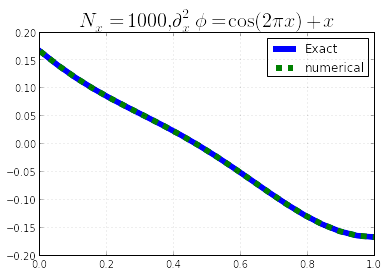

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 20
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x) + x

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * (x ** 3 + 1) - 1/2. * x
phi = Poisson_6th_LDBC_RNBC(n, Nx, a, b, LBC = 1/6., RBC = 0)

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x) + x$', fontsize = 20)
plt.legend(loc = 'best')

In [58]:
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x) + x
    phi = Poisson_6th_LDBC_RNBC(n, Nx[grid], a, b, RBC = 0.,LBC = 1/6.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * (x ** 3 + 1) - 1/2. * x
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 6.60477e-05       ----
Nx24        error = 4.63165e-07       order = 7.15584
Nx48        error = 3.20388e-09       order = 7.17556
Nx96        error = 2.2927e-11       order = 7.12663
Nx192        error = 1.74795e-13       order = 7.03524
Nx384        error = 3.78216e-14       order = 2.20838
Nx768        error = 7.92467e-14       order = -1.06714
Nx1536        error = 4.97852e-13       order = -2.65129
Nx3072        error = 7.50344e-13       order = -0.591836




### Convergence test 2

We can consider the Poisson problem

$$\partial_x^2 \phi = n, \qquad n = \cos (2\pi x) + x$$

where boundary conditions are not flipped, but chosen so that we get the same exact solution as in section H, i.e.

$$\phi (0) = 0, \,\, \partial_x\phi (1) = \frac{1}{2}$$

i.e. this produces (as before):

$$\phi_{exact}(x) = \frac{1}{4\pi^2}\left[1 - \cos (2\pi x)\right] + \frac{1}{6}x^3$$

For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{2\pi} \sin (2\pi x) + \frac{1}{2}x^2$$

Which can be noticed to satisfy the right edge Neumann condition, whereas the Dirichlet condition is clearly met by the left edge.


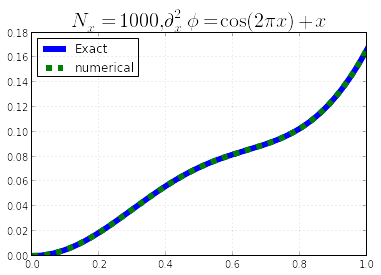

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x) + x

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
phi = Poisson_6th_LDBC_RNBC(n, Nx, a, b, LBC = 0, RBC = 1/2.)

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x) + x$', fontsize = 20)
plt.legend(loc = 'best')


In [61]:
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x) + x
    phi = Poisson_6th_LDBC_RNBC(n, Nx[grid], a, b, LBC = 0., RBC = 1/2.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 6.60477e-05       ----
Nx24        error = 4.63165e-07       order = 7.15584
Nx48        error = 3.20388e-09       order = 7.17556
Nx96        error = 2.29129e-11       order = 7.12752
Nx192        error = 1.60795e-13       order = 7.15479
Nx384        error = 3.96136e-14       order = 2.02115
Nx768        error = 8.48784e-14       order = -1.0994
Nx1536        error = 4.59885e-13       order = -2.43781
Nx3072        error = 8.50915e-13       order = -0.88774




This also gave us an opportunity to try out the solver for an nonhomogeneous NBC, which checks as shown above in the convergence analysis $\checkmark$. We can check out a situation where we have both nonhomogeneous just for completeness.

### Convergence test 3

We can consider the Poisson problem

$$\partial_x^2 \phi = n, \qquad n = \cos (2\pi x) + x$$

where boundary conditions are not flipped, but chosen so that we get the same exact solution as in section H, i.e.

$$\phi (0) = 1, \,\, \partial_x\phi (1) = \frac{1}{2}$$

i.e. this produces (as before):

$$\phi_{exact}(x) = \frac{1}{4\pi^2}\left[1 - \cos (2\pi x)\right] + \frac{1}{6}x^3 + 1$$

For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{2\pi} \sin (2\pi x) + \frac{1}{2}x^2$$

Which can be noticed to satisfy the right edge Neumann condition, whereas the Dirichlet condition is clearly met by the left edge.


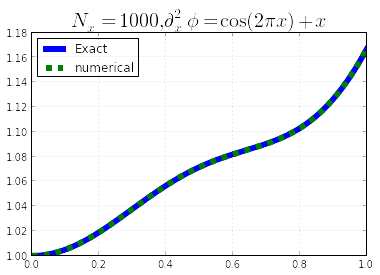

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x) + x

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3 + 1
phi = Poisson_6th_LDBC_RNBC(n, Nx, a, b, LBC = 1., RBC = 1/2.)

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x) + x$', fontsize = 20)
plt.legend(loc = 'best')


In [64]:
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x) + x
    phi = Poisson_6th_LDBC_RNBC(n, Nx[grid], a, b, RBC = 1/2., LBC = 1.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 6. * x ** 3 + 1
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 6.60477e-05       ----
Nx24        error = 4.63165e-07       order = 7.15584
Nx48        error = 3.20388e-09       order = 7.17556
Nx96        error = 2.28874e-11       order = 7.12913
Nx192        error = 1.31293e-13       order = 7.44562
Nx384        error = 3.42857e-13       order = -1.38482
Nx768        error = 3.16572e-13       order = 0.115073
Nx1536        error = 3.46431e-12       order = -3.45196
Nx3072        error = 9.01397e-12       order = -1.37959




All good!

# J. LNBC/RNBC solvers

## J.1 Solubility and well-posedness of the PDE

Considering the Poisson problem:

$$\partial_x \phi (t,x) = \sum_{\alpha = e,i} q_{\alpha}\int dv_x f_{\alpha}(t,x,v_x), \qquad x\in [a,b]$$

We integrate once to reveal a solubility constraint:

\begin{eqnarray*}
\int_a^b dx\, \partial_x^2\phi (t,x)  & = & \sum_{\alpha = e,i} q_{\alpha}\,\int_a^b dx \,\int dv_x f_{\alpha}(t,x,v_x) \\
&&\\
\partial_x\phi (t, b) - \partial_x\phi (t,a) & = & \sum_{\alpha = e,i} q_{\alpha}\,\int_a^b dx \,\int dv_x f_{\alpha}(t,x,v_x) 
\end{eqnarray*}

so the relationship that must be met among the first derivatives

$$\boxed{\partial_x\phi (t,b) - \partial_x\phi (t,a) = \sum_{\alpha = e,i} q_{\alpha}\,\int_a^b dx \,\int dv_x f_{\alpha}(t,x,v_x)} \qquad \underline{\text{Solubility constraint on Poisson's equation}}$$

For example, in a plasma system we have $n(t,x)$ being collected at thick conducting walls, and have conditions:

$$\partial_x\phi(t,a) = -\sigma_{Lw}(t,a)$$
$$\partial_x\phi(t,b) = \sigma_{Rw}(t,a)$$

where $\sigma$ is the surface charge density at either the left wall ($Lw$) or right wall ($Rw$). In 1D1V the surface charge density has units of charge, i.e. it is the total charge accumulated at a single point where the walls are and hence sometimes we call this quantity in the specialized case of 1D1V as $Q$ (total charge).

Thus, in our test cases below we must mind this condition (this condition is met for quasineutral plasmas for thick conductors, where we are correct in our expectation of the above two boundary values for $\partial_x\phi \equiv -E$, which is shown explicitly in a later section). The interpretation of this constraint is most obvious in special cases, consider Laplace's equation where we have no source term, $\Delta \phi = \vec{\nabla}\cdot \vec{\Gamma} = 0$ where the flux $\vec{\Gamma} = \vec{\nabla}\phi$. More relatably, take the function $\phi$ to be a temperature-like object, so that the object $\vec{\Gamma} = \vec{\nabla}\phi$ is a heat-like flux. If the flux of the flux is zero ($\vec{\nabla}\cdot\vec{\Gamma} = 0$), there is no heat-like flow, i.e. the system is at equilibrium (Laplace's equation is a PDE which gives the equilbrium distribution, is the heat equation with $\partial_t\rightarrow 0$).

If the Neumann boundary conditions are homogeneous, then we have no outflow from the system. In Laplace's equation, the diffusion of the quantity $\phi$ causes it to spread evenly so that it approaches a constant value $\phi (t\rightarrow \infty, x) = c$; however, any such $c$ also satisfies Laplaces equations along with the boundary conditions. Thus, there are an infinity of solutions.

If we have Poisson's equation with homogeneous Neumann boundary conditions, we have no outflow of the quantity $\phi$; however, we have injection of a source at a rate $n(t,x)$, if this were a temperature it would produce the solution where the temperature keeps rising with no means of escape, there exists no solution.

The general trend is that either there is no solution to the two NBC 1D problem, or if the right-hand side of the discrete Poisson problem happens to lie within the column space of the differencing matrix, such ill-posed problems will produce singular matrices in the differencing matrix that approximates the self-adjoint operator $\partial_x^2$. The way to fix a unique condition is only possible if the above boxed condition is met.

## J.1.1 Comparison with the Dirichlet problem: uniqueness 

Consider the equation in 3D:

$$\nabla^2\phi (\vec{x}) = f(\vec{x}), \quad \vec{x}\in V, \text{ with bounding surface } S$$

<u>Proof by contradiciton</u>:

Suppose there are two solutions $\phi_1$ and $\phi_2$ such that they satisfy the same Dirichlet boundary conditions

$$\phi_1 (\vec{x}) = \phi_2 (\vec{x}), \quad \vec{x}\in S$$

and solve the same Poisson equation:

$$\nabla^2\phi_1 (\vec{x}) = f(\vec{x})$$
$$\nabla^2\phi_2 (\vec{x}) = f(\vec{x})$$

Subtracting both equations we define $\Phi = \phi_1 - \phi_2$, and notice that the error function $\Phi$ must satisfy the Laplace equation:

$$\nabla^2\Phi = 0, \quad \vec{x}\in V$$

Since $\phi1$ and $\phi_2$ must satisfy the same boundary condition on $S$ to satisfy the Dirichlet problem, we have the corresponding boundary condition on the error function 

$$\Phi(\vec{x}\in S) = \phi_1(\vec{x}\in S) - \phi_2(\vec{x}\in S) = 0$$

One limitation is already clear; the two candidate solutions $\phi_1(\vec{x}\in V)$ and $\phi_2(\vec{x}\in V)$ cannot be different by only a constant $c$ as incidentally this implies that $\Phi(\vec{x}) \equiv 0 \Rightarrow \phi_1(\vec{x}) = \phi_2(\vec{x})$, which contradicts the claim in the Dirichlet problem. Thus, if it is possible to have two distinct solutions $\phi_1$ and $\phi_2$ that solve the same Poisson problem described by the same Dirichlet boundary conditions, then such a difference would have to be manifest with higher order variation than a constant offset.

To make progress, note the the following identity: $\Phi \underbrace{(\nabla^2\Phi)}_{=\, 0} = \vec{\nabla}\cdot (\Phi \vec{\nabla}\Phi) - (\vec{\nabla}\Phi)^2  \Rightarrow  (\vec{\nabla}\Phi)^2 = \vec{\nabla}\cdot (\Phi \vec{\nabla}\Phi)$, where the first term is zero due to satisfying Laplace's equation. thus we consider the related integral:

$$J = \int (\vec{\nabla}\Phi)^2 dV = \int \vec{\nabla}\cdot (\Phi \vec{\nabla}\Phi) dV = \oint_S \hat{n}\cdot (\Phi \vec{\nabla}\Phi) dS = 0$$

which follows from the boundary condition on $\Phi (\vec{x}\in S) = 0$. This implies $J = \int dV (\vec{\nabla}\Phi)^2 = 0 \Rightarrow \Phi = c$ in $\vec{x}\in V$, but it was just discussed that $\Phi (\vec{x}) = c$ implies $c = 0$ which means $\phi_1$ and $\phi_2$ are the same. Which contradicts the original claim that they were distinct. Thus, we see the solution to the Dirichlet Poisson problem is unique. 


## J.1.2 Non-uniqueness of the Neumann problem

Just as before we posit the existence of two unique solutions and discern if such a circumstance is possible. Introduce two candidate solutions of the Poisson problem $\phi_1(\vec{x})$ and $\phi_2(\vec{x})$ that satisfy the same Neumann boundary condition:

$$\frac{\partial \phi_1}{\partial n} = \frac{\partial \phi_2}{\partial n}, \quad \vec{x}\in S$$

as before we have the error function $\Phi(\vec{x}) = \phi_1(\vec{x}) - \phi_2(\vec{x})$ which satisfies the homogeneous boundary condition

$$\frac{\partial \Phi}{\partial n}  = \frac{\partial \phi_1}{\partial n} = \frac{\partial \phi_2}{\partial n} = 0, \quad \vec{x}\in S$$

which correspondingly satisfies the Laplace equation  $\nabla^2\Phi = 0$. We examine again the related integral and work in the Neumann boundary condition, i.e. consider

$$J = \int (\vec{\nabla}\Phi)^2 dV = \int \vec{\nabla}\cdot (\Phi \vec{\nabla}\Phi) dV = \oint_S \hat{n}\cdot (\Phi \vec{\nabla}\Phi) dS = \oint_S (\Phi\frac{\partial \Phi }{\partial n}) = 0$$

where this time it is the Neumann condition that produces the zero result. Recalling that $J = \int (\vec{\nabla}\Phi)^2 dV$ this implies that $\vec{\nabla}\Phi = 0 \Rightarrow \Phi (\vec{x}) = c$ for $\vec{x}\in V$ for $c\in \mathbb{R}$. But, note there is no restriction on the function value $\Phi (\vec{x}\in S)$, we rather only require $\partial\Phi / \partial n = 0$ on $S$, thus this time our conclusion $\Phi = c$ is permissible and we can note $\Phi = \phi_1 - \phi_2 = c$ to have the general relationshiop $\phi_1(\vec{x}) = \phi_2(\vec{x}) + c$ and by differentiating this equation we still have the condition $\partial \phi_1(\vec{x}\in S)/ \partial n = \partial\phi_2(\vec{x}\in S) / \partial n$. Thus, the uniqueness condition on the Neumann problem is a non-uniqueness condition, it is possible to have $\phi_1(\vec{x}) = \phi_2(\vec{x}) + c$. <b>Thus, the Neumann problem has infinitely many solutions.</b>

# J.2 The straightforward approach (LNBC/RNBC)

Here, we provide the details to try and set up the problem based on the work done in previous sections where now there are two Neumann conditions, one on each edge. <b>We will see the details of this validates the above ideas, it produces a singular matrix which is emblematic of there either being no solution or an infinite number, and we cannot proceed.</b> We end up converging on an equivalent casting of this problem in section J.3 which permits us to solve for NBCs that are consistent for such problems which satisfy the above solubility condition by enforcing Cauchy data at one edge, and then having the other NBC be satisfied as a consequence without direct enforcement. This restricts the problems we can solve, i.e. must satisfy the solubility condition. This will permit us to generate one of the infinite number of solutions for such problems by our selection of the DBC in the Cauchy data set. In our plasma context, since what we are solving for is a potential and what determines the evolution of the plasma particles is a difference in potential, not absolute value, this workaround comes at no consequence and is seen to accomplish the goal nicely.

## J.2 setting up the matrix problem

Minding the above, suppose have two conditions:

we consider the following compatible boundary conditions for the general (non-plasma) context:

<ol>
<li>$\boxed{\partial_x\phi (x_0) = \phi_a'}$
<li>$\boxed{\partial_x \phi (x_{N-1}) = \phi_a' + \int_a^b n(t,x) \equiv \phi_b'}$
</ol>

The set of scalar equations required are a consolidation of those in sections H and I. After this section we will be in a place to generalize or otherwise just have different routines for each case which can be toggled by <code>eval</code> of a string handle generated in a constructor in DECSKS. For such a system, we have the following set of equations

at $i = 0$:

$$-\frac{97}{10}\phi_0 + 16\phi_{1} - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5  =  (\Delta x)^2\left[\frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5\right] + 6 (\Delta x) \phi_a'$$

for $1 \leq i \leq N-2$:

\begin{eqnarray*}
i = 1: & \phi_0 -2\phi_1 + \phi_2 & =  \phantom{-}(\Delta x)^2\left[\frac{3}{40}n_{0} + \frac{209}{240}n_{1} + \frac{1}{60}n_{2} + \frac{7}{120}n_{3} - \frac{1}{40}n_{4} + \frac{1}{240}n_{5}\right] \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = -(\Delta x)^2\left[\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4}\right] \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & =  -(\Delta x)^2\left[\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5}\right] \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = -(\Delta x)^2\left[\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2}\right] \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = -(\Delta x)^2\left[\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{N-1}\right] \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = \phantom{-}(\Delta x)^2\left[\frac{1}{240}n_{N-6} - \frac{1}{40}n_{N-5} + \frac{7}{120}n_{N-4} + \frac{1}{60}n_{N-3} + \frac{209}{240}n_{N-2} + \frac{3}{40}n_{N-1}\right] \\[1em]
\end{eqnarray*}

and at $i = N-1$:

$$\frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 16\phi_{N_x-2} - \frac{97}{10}\phi_{N_x-1} = (\Delta x)^2\left(\frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6}\right) - 6(\Delta x)\phi_b'$$



We choose to partition the density matrices and the boundary values as follows, by writing:

$$\underline{b} = \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + \frac{1}{(\Delta x)^2} \underline{\phi}_{BC}$$

So that the above becomes 

$$\underline{\underline{D}}_{N\times N}\cdot\underline{\phi}_{N\times 1} = (\Delta x)^2\cdot \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + (\underline{\phi}_{BC})_{N\times 1}$$

Where 

$$(\underline{\phi}_{BC})_{N\times 1} = [(6(\Delta x) \phi_a', 0 , 0, \ldots , 0 , -6(\Delta x)\phi_b')^T]_{N\times 1}$$

the density vector 

$$\underline{n}_{N\times 1} = (n_0, n_1, n_2, \ldots , n_{N-2}, n_{N-1})^T$$

the difference matrix $\underline{\underline{D}}$ then takes the form  (LHS = "left-hand side"):

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
i = 0: \, \text{central differencing on } \{\phi_i\}  \text{ with $\phi_{-1}$ ghost point eliminated by NBC} \\
i = 1: \, \text{central differencing FD coefficients on }  \{\phi_i\}\\
i = 2: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = 3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{central differencing FD coefficients on }   \{\phi_i\}\\
i = N-2: \, \text{central differencing FD coefficients on }   \{\phi_j\}\\
i = 0: \, \text{central differencing on } \{\phi_i\}  \text{ with $\phi_{N}$ ghost point eliminated by NBC} 
\end{array} \right)$$

which takes the form,

 $$\underline{\underline{D}} = \left( \begin{array}{c c c c c c c c c}
-\frac{97}{10} & 16 & -10 &  5 & -\frac{3}{2} & \frac{1}{5} & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 &  0 & \frac{1}{5} & -\frac{3}{2} & 5 & -10 & 16 & -\frac{97}{10}  \\
\end{array} \right)$$


<table "width = 85%">
<tr><td><b>Solubility</b></td></tr>
<tr><td>
The determinant $\text{det}(\underline{\underline{D}}) = 0$ of the matrix $\underline{\underline{D}}$. This is not a numerical coincidence but a reflection of the problem not being well-posed (two Neumann boundary conditions). Either there is no solution or there are an infinite number of solutions provided the above solubility constraint is met ont the two NBCs.
</td></tr>
</table>




Similarly, by reviewing the above set of scalar equations, we show the form of the matrix $\underline{\underline{B}}_{N\times N}$:

$$\underline{\underline{B}} = \left( \begin{array}{c}
i = 0 \text{, Neumann boundary condition factored in with auxillary vector, } \underline{\phi}_{BC} \text{ forward 0 differencing scheme on density} \\
i = 1 \text{, forward-1 differencing scheme} \\
i = 2 \text{, central differencing scheme} \\
i = 3 \text{, central differencing scheme} \\
\vdots \\
i = N-3 \text{, central differencing scheme} \\
i = N-2 \text{, backward+1 differencing scheme} \\
i = 0 \text{, Neumann boundary condition factored in with auxillary vector, } \underline{\phi}_{BC} \text{ backward 0 differencing scheme on density} 
\end{array} \right)_{N\times N}
=  \left( \begin{array}{c c c c c c c c c c c c c c}
\frac{317}{240} & -\frac{133}{120} & \frac{187}{120} & -\frac{23}{20}  & \frac{109}{240}  & - \frac{3}{40} & 0 & \cdots & \cdots  &0 \\ 
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots  & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0  \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots  & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots  & 0\\
\vdots & \vdots & 0 & \ddots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0  & - \frac{3}{40}  & \frac{109}{240}  & -\frac{23}{20} & \frac{187}{120} & -\frac{133}{120}  & \frac{317}{240}\\ 
\end{array} \right)_{N\times N}$$


Which completely defines the problem.

## J.3 Implementation

### Poisson_6th_LNBC_RNBC.py

In [65]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_6th_LNBC_RNBC(n, Nx = 24, a = 0., b = 1., LBC = 0., RBC = 1.):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    phi -- (ndarray, ndim = 1) numerical solution to potential
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx)

    # assemble differencing matrix
   
    D = np.zeros((Nx,Nx))
    
    # LNBC row
    D[0,0] = -97/10. 
    D[0,1] = 16.
    D[0,2] = -10
    D[0,3] = 5.
    D[0,4] = -3/2. 
    D[0,5] = 1/5.
    
    # LNBC row
    D[-1,-1] = -97/10. 
    D[-1,-2] = 16.
    D[-1,-3] = -10
    D[-1,-4] = 5.
    D[-1,-5] = -3/2. 
    D[-1,-6] = 1/5.
      
    # Poisson's equation rows
    for i in range(1,Nx-1):
        D[i,i-1] = 1
        D[i,i] = -2
        D[i,i+1] = 1


    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx,Nx))
    for i in range(B.shape[0]):
        if i == 0:
            B[i,i] = 317 / 240.
            B[i,i+1] = -133/120.
            B[i,i+2] = 187 / 120.
            B[i,i+3] = -23 / 20.
            B[i,i+4] = 109 / 240.
            B[i,i+5] = -3/40.

        if i == 1:
            B[i, i-1] = 3 / 40.
            B[i, i] = 209 / 240.
            B[i,i+1] = 1 / 60.
            B[i,i+2] = 7 / 120.
            B[i,i+3] = -1 / 40.
            B[i,i+4] = 1 / 240.

        elif 2 <= i <= Nx-3:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:
            B[i,i+1] = 3 / 40.
            B[i,i] = 209 / 240.
            B[i,i-1] = 1 / 60.
            B[i,i-2] = 7 / 120.
            B[i,i-3] = -1 / 40.
            B[i,i-4] = 1 / 240.
            
        if i == Nx-1:
            B[i,i-5] = -3/40.
            B[i,i-4] = 109 / 240.
            B[i,i-3] = -23 / 20.
            B[i,i-2] = 187 / 120.  
            B[i,i-1] = -133/120.
            B[i,i] = 317 / 240.
 

    phi_BC = np.zeros(Nx)

    phi_BC[0] = 6 * dx * LBC
    phi_BC[-1] = -6 * dx * RBC
    b = dx ** 2 * B.dot(n) + phi_BC
    phi = LA.solve(D,b)

    return phi

In practice, we cannot apply this algorithm, though we can set it up as shown just above!

Instead, we arrive the non-unique solution by exploitng this non-uniqueness. That is, we are free to choose a <b>Dirichlet</b> boundary condition, and for such problems where a solution exists (i.e. which satisfy the solubility condition: $\partial_x\phi (b) = \partial_x \phi (a) + \int_a^b dx\, n(t,x)$), if we specify one Neumann boundary condition, then the other will be fulfilled by consequence. That is, we choose one <b>Cauchy</b> boundary condition at one edge, and understand if the context is appropriate the other Neumann condition will be fulfilled. Thus, we would like to have a scheme that applies the Cauchy data at one boundary. We could just use either the LNBC/RDBC or LDBC/RNBC schemes above if desired, but it is thought of as more natural to assert Cauchy data at one boundary.

# K. Poisson solver with Cauchy boundary condition at $x = a$ to achieve the effect of two Neumann BCs

We cast the problem:

<ol>
<li>$\partial_x\phi (x_0) = \phi_a'$
<li>$\partial_x \phi (x_{N-1}) = \phi_a' + \int_a^b n(t,x) \equiv \phi_b'$
</ol>

and the equivalent Cauchy problem is given by

<ol>
<li>$\boxed{\phi (x_0) = \phi_a}$
<li>$\boxed{\partial_x  \phi (x_0)  = \phi_a'}$
<li> and $\partial_x \phi (x_{N-1}) = \phi_a' + \int_a^b n(t,x) \equiv \phi_b'$ will not be enforced, but will be satisfied by consequence if this solubility condition is true (e.g. as in quasineutral plasmas)
</ol>

We proceed as in previous sections. With the $N-1$ differenced Poisson's equations (for nodes $i = 0, 1, 2, \ldots N-2$) + 1 Dirichlet boundary condition that are known a priori at $i = 0$, we have $N$ equations for $N$ unknowns ($\phi_i, \, i = 0, 1, 2, \ldots N-1$). The ghost value $\phi_{-1}$ that appears in the differenced $i = 0$ equation has been eliminated using the Neumann boundary condition, hence the stencil is reaches further right than the centered stencil $\{1,-2,1\}$ on $\phi_0$ by the same amount that its reach extends beyond this on the differenced estimation of $\delta_x\phi_0 = \text{LTE}[O(\Delta x^6)]$. We write several equations for various indices $i$ in order to clearly see the matrix take form. We wish to set up the discrete problem as follows:

$$\partial_x^2\phi = n \qquad \longrightarrow \qquad \frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \text{ or } \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b} \qquad (K.1)$$

The left-hand side ($\partial_x^2 \phi \simeq \underline{\underline{D}}\underline{\phi})$ has the factor of $(\Delta x)^2$ brought to the right-hand side. With this understanding, we have the following set of scalar equations to organize: 


We choose to label the grid points by $i$, and the equation number by $k = 0, 1, \ldots , N-1$ for our $N$ equations. We differentiate because before each equation $k$ would correspond to each node $i$ with the exception of the first or the last row which we made note of. Here, we will tack on two boundary conditions as the first two equations (first two rows of our matrix system) $k = 0,1,$, but these do not refer to nodes per se. However, equations (rows) $k = 2, 3, \ldots , N-1$ do correspond to differenced Poisson's equations centered at nodes $i = 0,1,2, \ldots N-2$, respectively. Note in this matrix problem organization, we have the relationship between the $i$th node equation ($i\in [0,1,2,\ldots , N-2]$) being $k = i -1$ if $k\in [1,2, 3, \ldots , N-1]$. This just makes obvious which matrix row $k$ contains which nodal equation $i$.

$$k = 0 : \qquad (\Delta x)^2\phi_{0}  = \phantom{-}(\Delta x)^2\phi_a$$

The $i = 0$ equation is the Neumann boundary condition where the ghost point $\phi_{-1}$ has been eliminated by using the differenced Poisson's equation at $i = 0$. 

$$k = 1 : \qquad -\frac{97}{10}\phi_0 + 16\phi_{1} - 10\phi_2 + 5\phi_3 - \frac{3}{2}\phi_4 + \frac{1}{5}\phi_5  =  (\Delta x)^2\left[\frac{317}{240}n_0 - \frac{133}{120}n_1 + \frac{187}{120}n_2 - \frac{23}{20}n_3  + \frac{109}{240}n_4 - \frac{3}{40}n_5\right] + 6 (\Delta x) \phi_a'$$

And, for $1\leq i \leq N-2$, we

\begin{eqnarray*}
i = 1 \,(k = 2): & \phi_0 -2\phi_1 + \phi_2 & =  \phantom{-}(\Delta x)^2\left[\frac{3}{40}n_{0} + \frac{209}{240}n_{1} + \frac{1}{60}n_{2} + \frac{7}{120}n_{3} - \frac{1}{40}n_{4} + \frac{1}{240}n_{5}\right] \\[1em]
i = 2 \,(k = 3): & \phi_1 -2\phi_2 + \phi_3 & = (\Delta x)^2\left[-\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4}\right] \\[1em]
i = 3 \,(k = 4): & \phi_2 -2\phi_3 + \phi_4 & =  (\Delta x)^2\left[-\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5}\right] \\[2em]
\vdots \\[2em]
i = N-4 \,(k = N-3): & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2}\right] \\[1em]
i = N-3 \,(k = N-2): & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{N-1}\right] \\[1em]
i = N - 2 \,(k = N-1): & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = \phantom{-}(\Delta x)^2\left[\frac{1}{240}n_{N-6} - \frac{1}{40}n_{N-5} + \frac{7}{120}n_{N-4} + \frac{1}{60}n_{N-3} + \frac{209}{240}n_{N-2} + \frac{3}{40}n_{N-1}\right]
\end{eqnarray*}

Which altogether provide the required $N$ equations for $N$ unknowns in the fashion of specifying Cauchy data at $i = 0$, which if the solubility condition for Neumann boundaries are met, then will give the non-unique solution to the double NBC problem, equivalently.

We choose to partition the density matrices and the boundary values as follows, by writing:

$$\underline{b} = \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + \frac{1}{(\Delta x)^2} \underline{\phi}_{BC}$$

So that the above becomes 

$$\boxed{\underline{\underline{D}}_{N\times N}\cdot\underline{\phi}_{N\times 1} = (\Delta x)^2\cdot \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + (\underline{\phi}_{BC})_{N\times 1}}$$

Notice that reviewing the $k = 0$ equation allows us to omit the factors of $(\Delta x)^2$ as they appear on both sides of the equation provided that the matrix $\underline{\underline{B}}$ contains a row of zeros for the first row so as to make the $k = 0$ equation independent of density as above.  We define the auxillary vector for the boundary terms:

$$(\underline{\phi}_{BC})_{N\times 1} = [(\phi_a, 6(\Delta x)\phi_a', 0 , 0, \ldots , 0 , 0)^T]_{N+\times 1}$$

the density vector 

$$\underline{n}_{N\times 1} = (n_0, n_1, n_2, \ldots , n_{N-2}, n_{N-1})^T$$


the difference matrix $\underline{\underline{D}}$ then takes the form  (LHS = "left-hand side"):

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
k = 0: \, \text{Dirichlet BC LHS coefficient of: } 1\cdot\phi_{0} = \phi_a  \\
k = 1: \, \text{Neumann BC LHS coefficient of: } \delta_x\cdot\phi_{0} = \phi_a'  \\
k = 2: \, \text{central differencing FD coefficients on } i = 1, \,\, \{\phi_i\}\\
k = 3: \, \text{central differencing FD coefficients on } i = 2, \,\,  \{\phi_i\}\\
\vdots \\
\vdots \\
\vdots \\
k = N-3: \, \text{central differencing FD coefficients on } i = N-4, \,\,  \{\phi_i\}\\
k = N-2: \, \text{central differencing FD coefficients on } i = N-3, \,\,  \{\phi_j\}\\
k = N-1: \, \text{central differencing FD coefficients on } i = N-2, \,\,  \{\phi_i\}
\end{array} \right)$$

which takes the form,

 $$\underline{\underline{D}} = \left( \begin{array}{c c c c c c c c c}
1 & 0 & 0 &  0 & 0 & 0 & 0 & \cdots & 0 \\
-\frac{97}{10} & 16 & -10 &  5 & -\frac{3}{2} & \frac{1}{5} & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
\end{array} \right)$$


Similarly, by reviewing the above set of scalar equations, we show the form of the matrix $\underline{\underline{B}}_{N\times N}$:

$$\underline{\underline{B}} = \left( \begin{array}{c}
k = 0 \text{, Dirichlet boundary condition at } i = 0 \text{ factored in with auxillary vector, } \underline{\phi}_{BC} \ldots \underline{0} \\
k = 1 \text{, Neumann boundary condition at } i = 0 \text{ factored in with auxillary vector, } \underline{\phi}_{BC} \text{ forward 0 differencing scheme on density} \\
k = 2 \text{, forward-1 differencing scheme} \\
k = 3 \text{, central differencing scheme} \\
k = 4 \text{, central differencing scheme} \\
\vdots \\
k = N-2 \text{, central differencing scheme} \\
k = N-1 \text{, backward+1 differencing scheme} \\
\end{array} \right)_{N\times N}
=  \left( \begin{array}{c c c c c c c c c c c c c c}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots  &0 \\ 
\frac{317}{240} & -\frac{133}{120} & \frac{187}{120} & -\frac{23}{20}  & \frac{109}{240}  & - \frac{3}{40} & 0 & \cdots & \cdots  &0 \\ 
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots  & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0  \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots  & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots  & 0\\
\vdots & \vdots & \vdots & 0 & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
\end{array} \right)_{N\times N}$$


## K.2 Implementation

### Poisson_LDBC_LNBC_6th.py

In [68]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_6th_LDBC_LNBC(n, Nx = 24, a = 0., b = 1., LDBC = 0., LNBC = 1.):
    """6th order LTE finite difference Poisson solver for two Neumann conditions
    for a suitably well-posed problem. The conditions are enforced as Cauchy
    data at the left boundary, where the second Neumann condition on the right
    hand side will be satisfied by consequence provided the problem meets the
    Neumann solubility condition on the Poisson equation

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    phi -- (ndarray, ndim = 1) numerical solution to potential
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx)

    # assemble differencing matrix
   
    D = np.zeros((Nx,Nx))

    # LDBC row, (row 0)
    D[0,0] = 1.
    
    # LNBC row, (row 1)
    D[1,0] = -97/10. 
    D[1,1] = 16.
    D[1,2] = -10
    D[1,3] = 5.
    D[1,4] = -3/2. 
    D[1,5] = 1/5.
      
    # Poisson's equation rows
    for i in range(2,Nx):
        D[i,i-2] = 1
        D[i,i-1] = -2
        D[i,i] = 1


    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx,Nx))
    for i in range(1,B.shape[0]):
        if i == 1:
            B[i,i-1] = 317 / 240.
            B[i,i] = -133/120.
            B[i,i+1] = 187 / 120.
            B[i,i+2] = -23 / 20.
            B[i,i+3] = 109 / 240.
            B[i,i+4] = -3/40.

        if i == 2:
            B[i, i-2] = 3 / 40.
            B[i, i-1] = 209 / 240.
            B[i,i] = 1 / 60.
            B[i,i+1] = 7 / 120.
            B[i,i+2] = -1 / 40.
            B[i,i+3] = 1 / 240.

        elif 3 <= i <= Nx-2:
            B[i,i-3] = -1/240.
            B[i,i-2] = 1/10.
            B[i,i-1] = 97/120.
            B[i,i] = 1/10.
            B[i,i+1] = -1/240.
            
        elif i == Nx-1:
            B[i,i-5] = 1/240.
            B[i,i-4] = -1/40.
            B[i,i-3] = 7/120.
            B[i,i-2] = 1/60.  
            B[i,i-1] = 209/240.
            B[i,i] = 3/40.
 

    phi_BC = np.zeros(Nx)

    phi_BC[0] = LDBC
    phi_BC[1] = 6 * dx * LNBC
    b = dx ** 2 * B.dot(n) + phi_BC
    phi = LA.solve(D,b)

    return phi

<table "width = 85%">
<tr><td<font size = 24><b>Solubility</b></font></td></tr>
<tr><td>
The determinant $\text{det}(\underline{\underline{D}}) = 6$ of the matrix $\underline{\underline{D}}$ is nonzero and thus invertible, hence a unique solution exists for this DBC/NBC problem.
</td></tr>
</table>


### Convergence test

We can consider the Poisson problem

$$\partial_x^2 \phi = n(x), \qquad n(x) = \cos (2\pi x), \qquad x\in [0,1]$$

where we enforce the following Cauchy data:

$$\phi (0) = 1, \,\, \partial_x\phi (0) = \frac{1}{2}$$

Noting that we note that $\int_0^1 dx\, n(x) = 0$, we have the following relationship given by the solubility constraint:

$$\partial_x\phi (1) = \partial_x\phi (0) + \int_0^1 dx\, n(x) = \partial_x\phi (0) = \frac{1}{2}$$

We will analyze the numerical solution vs. the exact solution and should there be sufficient agreement we will be able to agree that the Neumann condition at $x = 1$ must also be met without having to take the numerical solution, then difference it at the edges and see if the derivative value agrees. Additionally, we plot the line of constant slope 1/2, which should be the values of $\partial_x\phi$ at either edge, so visually we will have an easy comparison.

The exact solution is:
;
$$\phi_{exact} (x) = \frac{1}{4\pi^2}\left(1 - \cos (2\pi x) \right) + \frac{1}{2} x + 1$$

For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{2\pi} \sin (2\pi x) + \frac{1}{2}$$

We can see at $x = 0$ and $x = 1$ we have $\partial_x\phi = 1/2$ which was what we anticipated would be satisfied above.

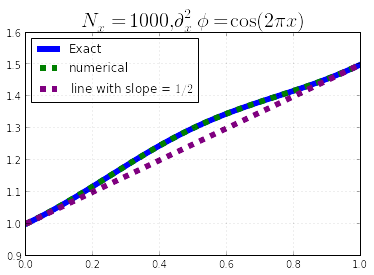

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x)

phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1/2.*x + 1.

phi = Poisson_6th_LDBC_LNBC(n, Nx, a, b, LDBC = 1., LNBC = 1/2.)

NBC_line = 1/2.*x + 1

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.plot(x, NBC_line, linewidth = 6, linestyle = '--', color = 'purple', label = r'line with slope = $1/2$')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x)$', fontsize = 20)
plt.legend(loc = 'best')


In [72]:
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x)
    phi = Poisson_6th_LDBC_LNBC(n, Nx[grid], a, b, LDBC = 1., LNBC = 1/2.)
    phi_exact = 1 / (4 * np.pi ** 2) * (1 - np.cos(2*np.pi * x)) + 1 / 2. * x  + 1
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'

Nx12        error = 6.74513e-05       ----
Nx24        error = 4.76614e-07       order = 7.14488
Nx48        error = 3.34742e-09       order = 7.15363
Nx96        error = 2.4824e-11       order = 7.07517
Nx192        error = 1.78243e-13       order = 7.12175
Nx384        error = 1.37404e-13       order = 0.375416
Nx768        error = 3.69313e-13       order = -1.42642
Nx1536        error = 4.84432e-13       order = -0.39145
Nx3072        error = 9.29766e-13       order = -0.940576




Which also checks out.

# L. Poisson solver with Cauchy boundary condition at $x = b$ to achieve the effect of two Neumann BCs

For the Poisson equation $\partial_x^2\phi (t,x) = n(t,x)$, we have the following two Neumann boundary conditions, where we now specify the NBC on the right-edge instead of the left.

<ol>
<li>$\partial_x\phi (x_{N-1}) = \phi_b'$
<li>$\partial_x \phi (x_0) = \phi_b' - \int_a^b n(t,x) \equiv \phi_a'$
</ol>

and the equivalent Cauchy problem is given by

<ol>
<li>$\boxed{\phi (x_{N-1}) = \phi_b}$
<li>$\boxed{\partial_x  \phi (x_{N-1})  = \phi_b'}$
<li> and $\partial_x \phi (x_{0}) = \phi_b' - \int_a^b n(t,x) \equiv \phi_b'$ will not be enforced, but will be satisfied by consequence if this solubility condition is true (e.g. as in quasineutral plasmas)
</ol>

We proceed as in previous sections. With the $N-1$ differenced Poisson's equations (for nodes $i = 1, 2, \ldots N-1$) + 1 Dirichlet boundary condition that are known a priori at $i = N-1$, we have $N$ equations for $N$ unknowns ($\phi_i, \, i = 0, 1, 2, \ldots N-1$). Note the ghost value $\phi_N$ that appears in the differenced $i = N-1$ equation has been eliminated by using the Neumann condition; hence the stencil on $\phi_{N-1}$ extends further left than the other rows as this correpsonds to the reach that the sided difference on the Neumann condition that was used to replace this unknown ghost value. 

We write several equations for various indices $i$ in order to clearly see the matrix take form. We wish to set up the discrete problem as follows:

$$\partial_x^2\phi = n \qquad \longrightarrow \qquad \frac{1}{(\Delta x)^2}\underline{\underline{D}}\underline{\phi} = \underline{b} \quad \text{ or } \quad \underline{\underline{D}}\underline{\phi} = (\Delta x)^2\underline{b} \qquad (L.1)$$

The left-hand side ($\partial_x^2 \phi \simeq \underline{\underline{D}}\underline{\phi})$ has the factor of $(\Delta x)^2$ brought to the right-hand side. With this understanding, we have the following set of scalar equations to organize: 

We choose to label the grid points by $i$, and the equation number by $k = 0, 1, \ldots , N-1$ for our $N$ equations. We differentiate because before each equation $k$ would correspond to each node $i$ with the exception of the first or the last row which we made note of. Here, we will tack on two boundary conditions as the final two equations (final two rows of our matrix system) $k = N-2, N-1,$, but these do not refer to nodes in the same context (though arguably the $N-2$ equation does correspond to the differenced Poisson equation at $i = N-1$, it just has been combined with the Neumann condition so we say perhaps it might be regarded as not exactly the same as the other equations). However, equations (rows) $k = 0, 1,2 , \ldots , N-3$ do correspond to differenced Poisson's equations centered at nodes $i = 1,2, \ldots N-2$, respectively. Note in this matrix problem organization, we have the relationship between the $i$th node equation ($i\in [1,2,\ldots , N-1]$) being $k = i + 1$ if $k\in [0,1,2, \ldots , N-3]$. This just makes obvious which matrix row $k$ contains which nodal equation $i$.



The $i = 0$ equation is the Neumann boundary condition where the ghost point $\phi_{-1}$ has been eliminated by using the differenced Poisson's equation at $i = 0$. 



And, for $1\leq i \leq N-3$, we

\begin{eqnarray*}
i = 1 \,(k = 0): & \phi_0 -2\phi_1 + \phi_2 & =  \phantom{-}(\Delta x)^2\left[\frac{3}{40}n_{0} + \frac{209}{240}n_{1} + \frac{1}{60}n_{2} + \frac{7}{120}n_{3} - \frac{1}{40}n_{4} + \frac{1}{240}n_{5}\right] \\[1em]
i = 2 \,(k = 1): & \phi_1 -2\phi_2 + \phi_3 & = (\Delta x)^2\left[-\frac{1}{240}n_{0} + \frac{1}{10}n_{1} + \frac{97}{120}n_{2} + \frac{1}{10}n_{3} - \frac{1}{240}n_{4}\right] \\[1em]
i = 3 \,(k = 2): & \phi_2 -2\phi_3 + \phi_4 & =  (\Delta x)^2\left[-\frac{1}{240}n_{1} + \frac{1}{10}n_{2} + \frac{97}{120}n_{3} + \frac{1}{10}n_{4} - \frac{1}{240}n_{5}\right] \\[2em]
\vdots \\[2em]
i = N-4 \,(k = N-5): & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-6} + \frac{1}{10}n_{N-5} + \frac{97}{120}n_{N-4} + \frac{1}{10}n_{N-3} - \frac{1}{240}n_{N-2}\right] \\[1em]
i = N-3 \,(k = N-4): & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = (\Delta x)^2\left[-\frac{1}{240}n_{N-5} + \frac{1}{10}n_{N-4} + \frac{97}{120}n_{N-3} + \frac{1}{10}n_{N-2} - \frac{1}{240}n_{N-1}\right] \\[1em]
i = N - 2 \,(k = N-3): & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = \phantom{-}(\Delta x)^2\left[\frac{1}{240}n_{N-6} - \frac{1}{40}n_{N-5} + \frac{7}{120}n_{N-4} + \frac{1}{60}n_{N-3} + \frac{209}{240}n_{N-2} + \frac{3}{40}n_{N-1}\right]
\end{eqnarray*}

and for $k = N-2$:

$$\frac{1}{5}\phi_{N_x-6} - \frac{3}{2}\phi_{N_x-5} + 5\phi_{N_x-4} - 10\phi_{N_x-3} + 16\phi_{N_x-2} - \frac{97}{10}\phi_{N_x-1} = (\Delta x)^2\left(\frac{317}{240}n_{N_x-1} - \frac{133}{120}n_{N_x-2} + \frac{187}{120}n_{N_x-3} - \frac{23}{20}n_{N_x-4}  + \frac{109}{240}n_{N_x-5} - \frac{3}{40}n_{N_x-6}\right) - 6(\Delta x)\phi_b'$$

finally, for $k = N-1$

$$\qquad (\Delta x)^2\phi_{0}  = \phantom{-}(\Delta x)^2\phi_b$$



Which altogether provide the required $N$ equations for $N$ unknowns in the fashion of specifying Cauchy data at $i = 0$, which if the solubility condition for Neumann boundaries are met, then will give the non-unique solution to the double NBC problem, equivalently.

We choose to partition the density matrices and the boundary values as follows, by writing:

$$\underline{b} = \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + \frac{1}{(\Delta x)^2} \underline{\phi}_{BC}$$

So that the above becomes 

$$\boxed{\underline{\underline{D}}_{N\times N}\cdot\underline{\phi}_{N\times 1} = (\Delta x)^2\cdot \underline{\underline{B}}_{N\times N}\cdot \underline{n}_{N\times 1} + (\underline{\phi}_{BC})_{N\times 1}}$$

Notice that reviewing the $k = 0$ equation allows us to omit the factors of $(\Delta x)^2$ as they appear on both sides of the equation provided that the matrix $\underline{\underline{B}}$ contains a row of zeros for the first row so as to make the $k = 0$ equation independent of density as above.  We define the auxillary vector for the boundary terms:

$$(\underline{\phi}_{BC})_{N\times 1} = [(0 , 0, \ldots , -6(\Delta x)\phi_b' , \phi_b)^T]_{N\times 1}$$

the density vector 

$$\underline{n}_{N\times 1} = (n_0, n_1, n_2, \ldots , n_{N-2}, n_{N-1})^T$$





the difference matrix $\underline{\underline{D}}$ then takes the form  (LHS = "left-hand side"):

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
k = 0: \, \text{central differencing FD coefficients on } i = 1, \,\, \{\phi_i\}\\
k = 1: \, \text{central differencing FD coefficients on } i = 2, \,\,  \{\phi_i\}\\
\vdots \\
\vdots \\
\vdots \\
k = N-5: \, \text{central differencing FD coefficients on } i = N-4, \,\,  \{\phi_i\}\\
k = N-4: \, \text{central differencing FD coefficients on } i = N-3, \,\,  \{\phi_j\}\\
k = N-3: \, \text{central differencing FD coefficients on } i = N-2, \,\,  \{\phi_i\} \\
k = N-2: \, \text{Neumann BC LHS coefficient of: } \delta_x\cdot\phi_{N-1} = \phi_a' \text{ combined with central FD coefficients on } \phi_{N-1} \\
k = N-1: \, \text{Dirichlet BC LHS coefficient of: } 1\cdot\phi_{N-1} = \phi_a  \\
\end{array} \right)$$


which takes the form,

 $$\underline{\underline{D}} = \left( \begin{array}{c c c c c c c c c}
1 & -2 & 1  & 0 & \cdots & \cdots & \cdots &  \cdots &  \cdots & 0 \\
 0 & 1 & -2 & 1 & 0 & \cdots &  \cdots  & \cdots &  \cdots &  0 \\
\vdots & 0 & 1 & -2 & 1 & 0 & \cdots &  \cdots &  \cdots & 0\\
\vdots & \vdots & 0 & 1 & -2 & 1 & 0 &  \cdots &  \cdots & 0\\
\vdots & \vdots & \vdots & 0 &  1 & -2 & 1 & 0 &  \cdots  & 0\\
\vdots & \vdots & \vdots & \vdots  & 0 & \ddots & \ddots &  \ddots &  0 & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots  & 0 & \ddots  & \ddots &  \ddots &  0\\
\vdots & \vdots & \vdots & \vdots & \vdots &  \vdots &  0  & 1 & -2 & 1 \\
0 & 0 & 0 &  0 & 0 & 0 &  0 &  0 &  \cdots & 1 \\
0 & 0 & 0 &  0 & \frac{1}{5} & -\frac{3}{2} & 5 & -10 & 16 & -\frac{97}{10}  \\
\end{array} \right)$$


<table "width = 85%">
<tr><td<font size = 24><b>Solubility</b></font></td></tr>
<tr><td>
The determinant $\text{det}(\underline{\underline{D}}) = 6$ of the matrix $\underline{\underline{D}}$ is nonzero and thus invertible, hence a unique solution exists for this DBC/NBC problem.
</td></tr>
</table>

Similarly, by reviewing the above set of scalar equations, we show the form of the matrix $\underline{\underline{B}}_{N\times N}$:

$$\underline{\underline{B}} = \left( \begin{array}{c}
k = 0 (i=1)\text{, forward-1 differencing scheme} \\
k = 1 (i=2)\text{, central differencing scheme} \\
k = 2 (i=3)\text{, central differencing scheme} \\
\vdots \\
k = N-4 (i=N-3)\text{, central differencing scheme} \\
k = N-3 (i=N-2)\text{, backward+1 differencing scheme} \\
k = N-2 (i=N-1)\text{, Neumann boundary condition at } i = 0 \text{ factored in with auxillary vector, } \underline{\phi}_{BC} \text{ forward 0 differencing scheme on density} \\
k = N-1 \text{, Dirichlet boundary condition at } i = 0 \text{ factored in with auxillary vector, } \underline{\phi}_{BC} \ldots \underline{0} \\
\end{array} \right)_{N\times N}
=  \left( \begin{array}{c c c c c c c c c c c c c c}
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & 0\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & 0 & \cdots  & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0  \\
\vdots & 0  & \ddots  & \ddots & \ddots & \ddots & \ddots & \ddots  & 0 & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots  & 0\\
\vdots & \vdots & 0 & \ddots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & 0 & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0  & - \frac{3}{40}  & \frac{109}{240}  & -\frac{23}{20} & \frac{187}{120} & -\frac{133}{120}  & \frac{317}{240}\\ 
0 & 0 & 0 & \cdots & 0  & 0 & 0 & 0  & 0 & 0\\ 
\end{array} \right)_{N\times N}$$



## L.2 Implementation

### Poisson_RDBC_RNBC_6th.py

In [6]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

def Poisson_6th_RDBC_RNBC(n, Nx = 24, a = 0., b = 1., RDBC = 0., RNBC = 1.):
    """6th order LTE finite difference Poisson solver for two Neumann conditions
    for a suitably well-posed problem. The conditions are enforced as Cauchy
    data at the left boundary, where the second Neumann condition on the right
    hand side will be satisfied by consequence provided the problem meets the
    Neumann solubility condition on the Poisson equation

    inputs:
    n -- (ndarray, ndim = 1) density vector
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
                          
    outputs:
    phi -- (ndarray, ndim = 1) numerical solution to potential
    """

    L = float(b - a)
    dx = L / (Nx - 1)
    
    # augmented density vector N = (0, n), shape = (N+1,)
    
    N = np.zeros(Nx)

    # assemble differencing matrix
   
    D = np.zeros((Nx,Nx))

    # LDBC row, (row 0)
    D[-1,-1] = 1.
    
    # LNBC row, (row 1)
    D[-2,-1] = -97/10. 
    D[-2,-2] = 16.
    D[-2,-3] = -10
    D[-2,-4] = 5.
    D[-2,-5] = -3/2. 
    D[-2,-6] = 1/5.
      
    # Poisson's equation rows
    for i in range(Nx-2):
        D[i,i] = 1
        D[i,i+1] = -2
        D[i,i+2] = 1


    # Assemble FD coefficient matrix on n: B
    B = np.zeros((Nx,Nx))
    for i in range(B.shape[0]):
        if i == 0:
            B[i,i] = 3/40.
            B[i,i+1] = 209/240.
            B[i,i+2] = 1/60.
            B[i,i+3] = 7/120.
            B[i,i+4] = -1/40.
            B[i,i+5] = 1/240.
                      
        if 1 <= i < Nx-3:
            B[i,i-1] = -1/240.
            B[i,i] = 1/10.
            B[i,i+1] = 97/120.
            B[i,i+2] = 1/10.
            B[i,i+3] = -1/240.
            
        elif i == Nx-3:
            B[i,i-3] = 1/240.
            B[i,i-2] = -1/40.
            B[i,i-1] = 7/120.
            B[i,i] = 1/60.  
            B[i,i+1] = 209/240.
            B[i,i+2] = 3/40.
            
        elif i == Nx-2:
            B[i,i+1] = 317 / 240.
            B[i,i] = -133/120.
            B[i,i-1] = 187 / 120.
            B[i,i-2] = -23 / 20.
            B[i,i-3] = 109 / 240.
            B[i,i-4] = -3/40.
            
        # elif i == Nx - 1: all zeros


    phi_BC = np.zeros(Nx)

    phi_BC[-1] = RDBC
    phi_BC[-2] = -6 * dx * RNBC
    b = dx ** 2 * B.dot(n) + phi_BC
    phi = LA.solve(D,b)

    return phi

### Convergence test

We can consider the Poisson problem

$$\partial_x^2 \phi = n(x), \qquad n(x) = \cos (2\pi x), \qquad x\in [0,1]$$

where we enforce the following Cauchy data at the right boundary:

$$\phi (1) = 1, \,\, \partial_x\phi (0) = \frac{1}{4\pi^2}$$

Noting that we note that $\int_0^1 dx\, n(x) = 0$, we have the following relationship given by the solubility constraint:

$$\partial_x\phi (0) = \partial_x\phi (1) - \int_0^1 dx\, n(x) = \partial_x\phi (1) = \frac{1}{4\pi^2}$$

We will analyze the numerical solution vs. the exact solution and should there be sufficient agreement we will be able to agree that the Neumann condition at $x = 0$ must also be met without having to take the numerical solution, then difference it at the edges and see if the derivative value agrees. Additionally, we plot the line of constant slope $1/4\pi^2$, which should be the values of $\partial_x\phi$ at either edge, so visually we will have an easy comparison.

The exact solution is:

$$\phi_{exact} (x) = \frac{1}{4\pi^2}\left(x - \cos (2\pi x) \right) + 1$$

It is easy to see that at $x = 1$, the DBC is uph3eld. For reference, we provide the first derivative:

$$\partial_x\phi_{exact}(x) = \frac{1}{4\pi^2} + \frac{1}{2\pi}\sin (2\pi x)$$

We can see at $x = 1$ the NBC is upheld.

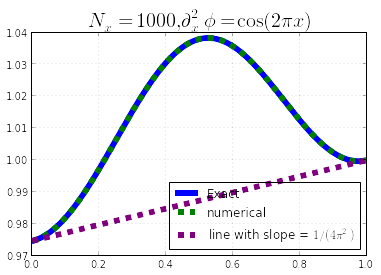

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 1000
a, b = 0., 1.
x = np.linspace(a, b, Nx)

n = np.cos(2*np.pi * x)

phi_exact = 1 / (4 * np.pi ** 2) * (x - np.cos(2*np.pi * x)) + 1.

phi = Poisson_6th_RDBC_RNBC(n, Nx, a, b, RDBC = 1., RNBC = 1/(4*np.pi**2))

NBC_line = 1/(4*np.pi ** 2) * x + (1 - 1 / (4*np.pi ** 2) * (1 - 0))

plt.plot(x, phi_exact, linewidth = 6, label = 'Exact')
plt.hold('on')
plt.plot(x, phi, linewidth = 6, linestyle = '--', label = 'numerical')
plt.plot(x, NBC_line, linewidth = 6, linestyle = '--', color = 'purple', label = r'line with slope = $1/(4\pi^2)$')
plt.hold('off')
plt.grid()
plt.title(r'$N_x = 1000, \partial_x^2 \phi = \cos (2\pi x)$', fontsize = 20)
plt.legend(loc = 'best')

It is a little hard to see that the right Neumann boundary condition (slope) is fulfilled. We show a zoomed in plot below:

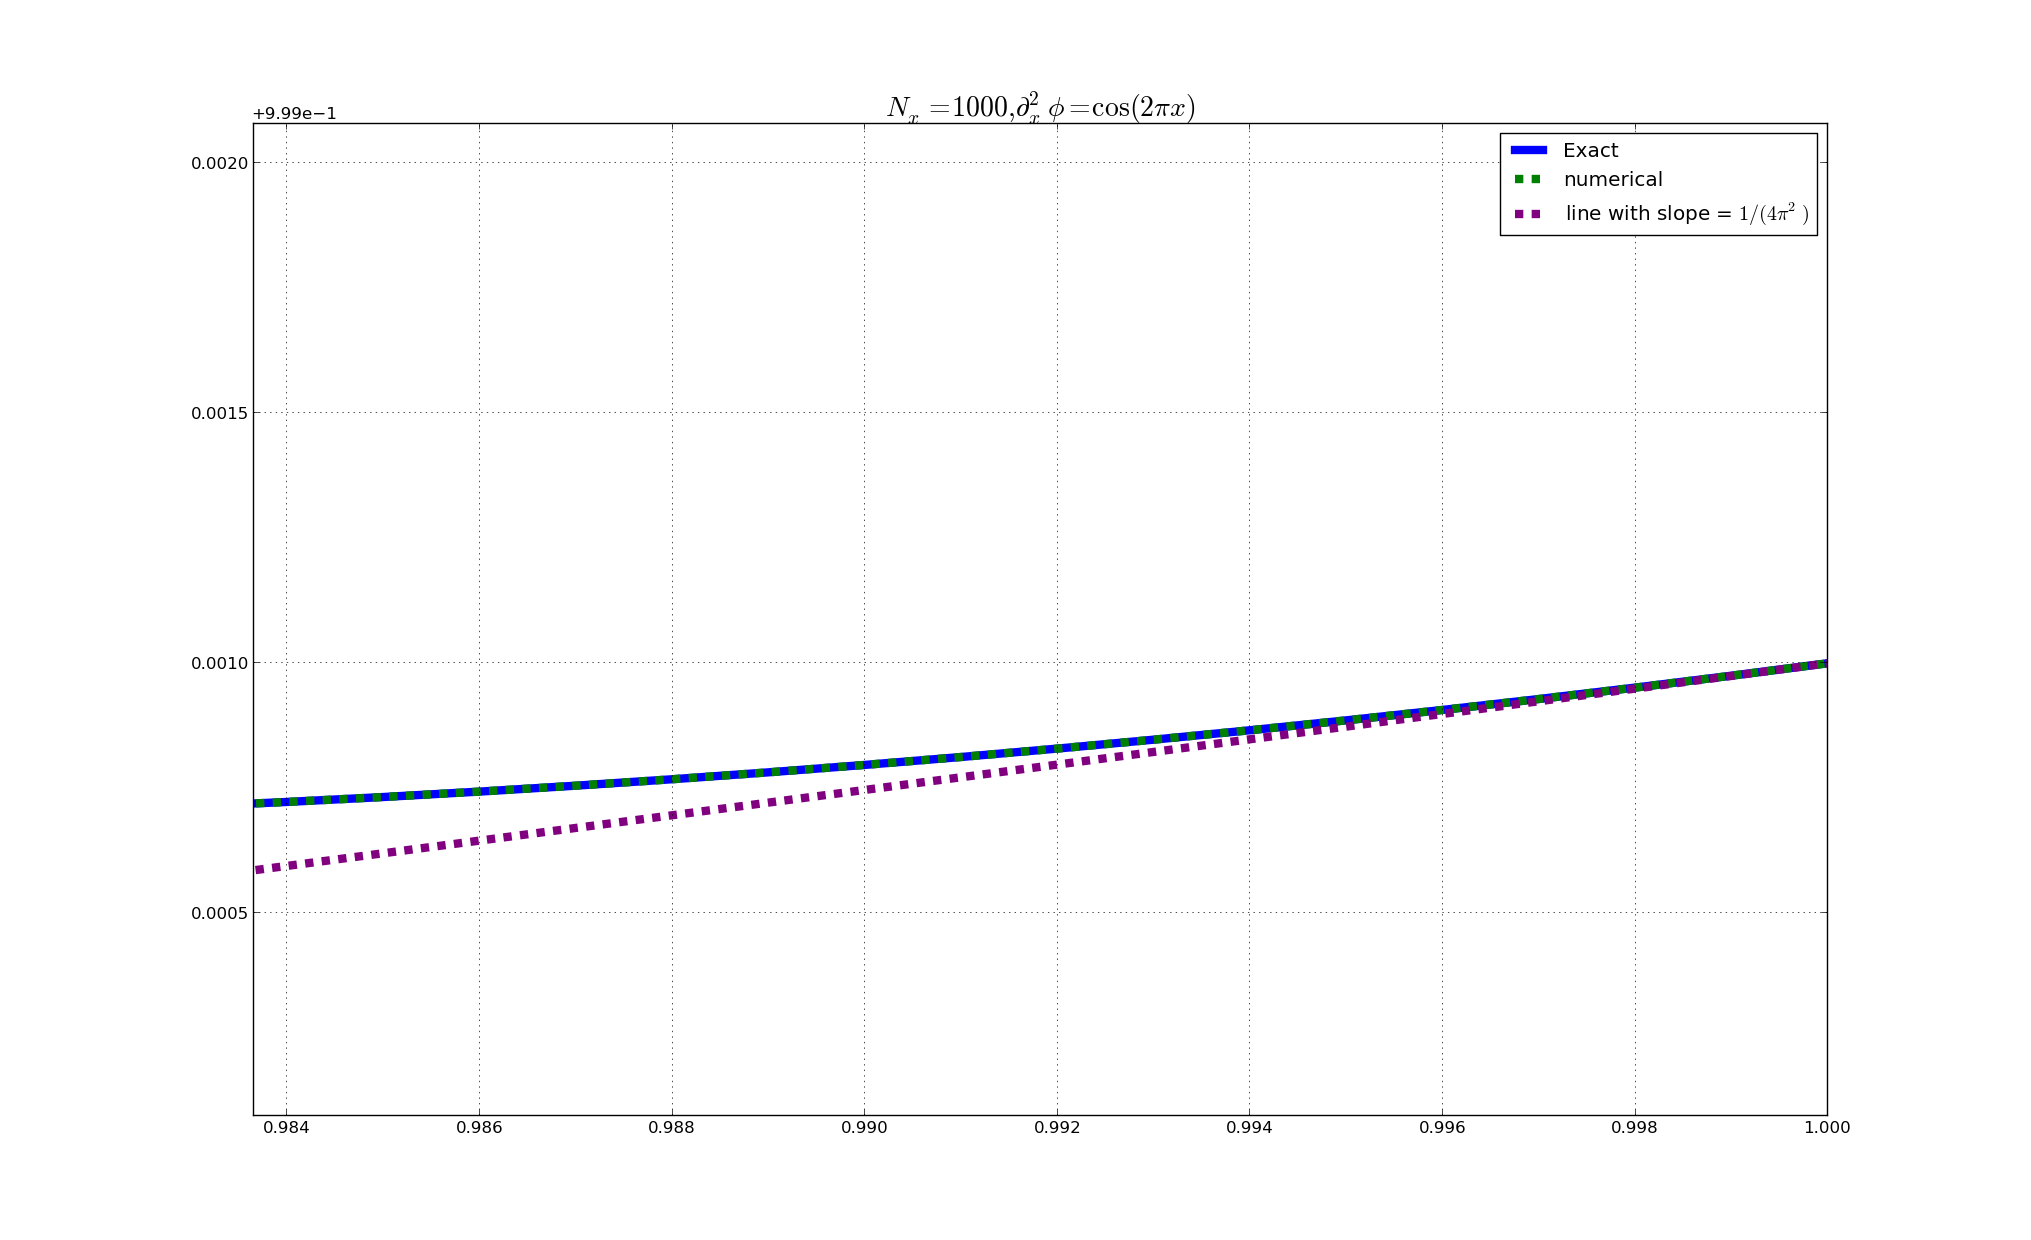

In [11]:
from IPython.display import Image
Image(filename='./fig/RNBC_closeup.png')

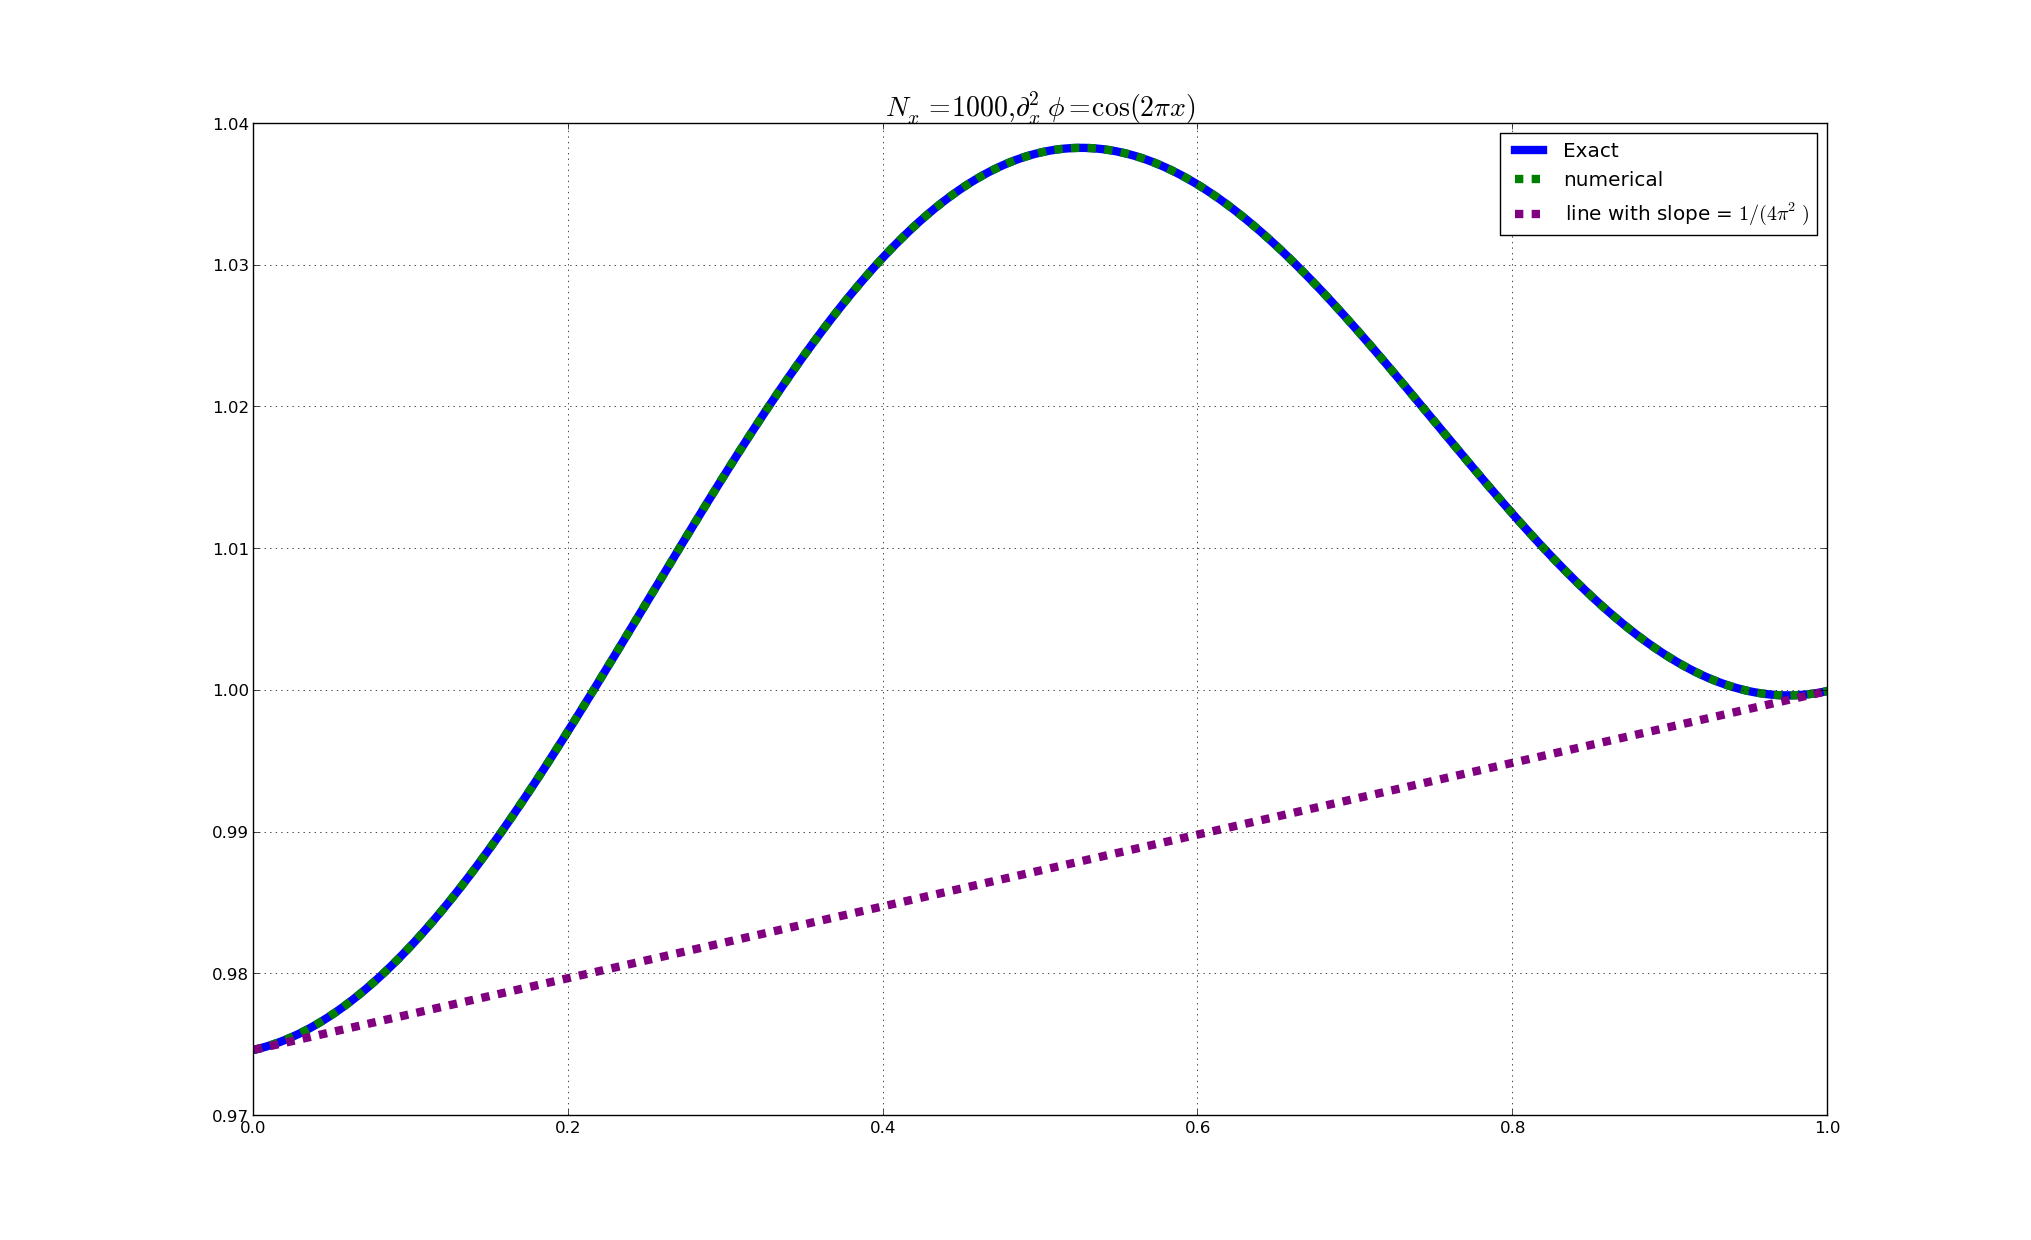

In [13]:
from IPython.display import Image
Image(filename='./fig/RDBC_RNBC_full.png')

In [14]:
import numpy as np

Nx = [12, 24, 48, 96, 192, 384, 768, 1536, 3072]
num_grids = len(Nx)
a, b = 0., 1.
L = b - a
error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for grid in range(num_grids):
    # grid dependent parameters
    dx = L / (Nx[grid] - 1)
    x = np.linspace(a, b, Nx[grid]) # spacing dx = (b - a ) / (Nx - 1)
    n = np.cos(2*np.pi * x)
    phi = Poisson_6th_RDBC_RNBC(n, Nx[grid], a, b, RDBC = 1., RNBC = 1/(4*np.pi**2))
    phi_exact = 1 / (4 * np.pi ** 2) * (x - np.cos(2*np.pi * x)) + 1.
    error_norm[grid] = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if grid == 0:
        print "Nx%d        error = %g       ----" % (Nx[grid], error_norm[grid])
    else:
        orders[grid] = np.log2(error_norm[grid-1] / error_norm[grid])
        print "Nx%d        error = %g       order = %g" % (Nx[grid], error_norm[grid], orders[grid])
        
print '\n'


Nx12        error = 6.74513e-05       ----
Nx24        error = 4.76614e-07       order = 7.14488
Nx48        error = 3.34736e-09       order = 7.15365
Nx96        error = 2.47655e-11       order = 7.07855
Nx192        error = 8.94516e-14       order = 8.11301
Nx384        error = 2.50357e-13       order = -1.48481
Nx768        error = 7.94629e-13       order = -1.6663
Nx1536        error = 3.00376e-12       order = -1.91842
Nx3072        error = 5.13882e-12       order = -0.774666




Which confirms the order of accuracy as being $\geq O(\Delta x^6)$ as required.

# The non-consequence of choosing a reference potential

When treating NBC/NBC problems, it was discussed that the equivalent problem can be casted in terms of an NBC/DBC pair, where the unenforced NBC that is neglected in the recast will be fulfilled automatically by virtue of the solubility condition. However, it is arbitrary which boundary where we apply this DBC. We step through an analytical example to show the differences, and then show why it does not matter in the context of quasineutral plasmas where what determines the electrostatic forces is what difference in potential, not its absolute value.

Consider the problem,

$$\partial_x^2\phi = \cos (2\pi x), \qquad x\in [0,1]$$

<ol>
<li>$\partial_x\phi (0) = a$
<li>$\partial_x\phi (1) = a$
</ol>

Recast as the equivalent problems, we consider several options:

<u>Option 1</u>

<ol>
<li>$\partial_x\phi (0) = a$
<li>$\phi (0) = 0$
</ol>


<u>Option 2</u>

<ol>
<li>$\partial_x\phi (0) = a$
<li>$\phi (1) = 0$
</ol>


<u>Option 3</u>

<ol>
<li>$\partial_x\phi (0) = a$
<li>$\phi (0) = b$
</ol>


<u>Option 4</u>

<ol>
<li>$\partial_x\phi (0) = a$
<li>$\phi (1) = b'$
</ol>


<u>Option 5</u>

<ol>
<li>$\partial_x\phi (1) = a$
<li>$\phi (0) = 0$
</ol>

we solve for the general solution for options 1 - 5 (note that the general solution for all are the same, even nif the NBC is applied as in option 5, at the opposite end of the boundary, this is unique to our problem as the solubility condition requires an equality in both NBCs given the source function integrates to zero): 

\begin{eqnarray*}
\partial_x^2\phi & = & \cos (2\pi x) \\
\Rightarrow \partial_x\phi & = & \frac{1}{2\pi} \sin (2 \pi x) + A \\
\Rightarrow \partial_x \phi (0) & = & a  =  0 + A \quad \Rightarrow \quad A = a \\
\Rightarrow \partial_x\phi (x) & = & \sin (2 \pi x) + a \\
&&\\
\Rightarrow \phi (x) & = & -\frac{1}{4\pi^2}\cos (2\pi x) + ax + B \\
\end{eqnarray*}

Enforcing the conditions for options 1 - 5, we have the following solutions labelled by option number:

<ol>
<li>$\phi (x)  =  -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
<li>$\phi (x)  =  -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} - a$
<li>$\phi (x)  =  -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} + b$
<li>$\phi (x)  =  -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} + b' - a$
<li>$\phi (x)  = -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
</ol>

Notice that option 1 and 5 have the exact same solution, as expected.

In a plasma, what will matter is the potential difference at a particular point $\phi (x)$. For example, consider the difference between the potential at $x$ and $x = 0$, we have the following differences $\Delta \phi (x) = \phi (x) - \phi (0)$ for each option:

<ol>
<li>$\Delta \phi (x)  =  \left[-\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}\right] - 0 = -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
<li>$\Delta \phi (x)  =  \phi (x) - \phi (0) = \left[-\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} - a\right] - [-\frac{1}{4\pi^2} + 0 + \frac{1}{4\pi^2} - a] = -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
<li>$\Delta \phi (x) = \phi (x) - \phi (0) =  \left[-\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} + b\right] - \left[-\frac{1}{4\pi^2} + 0 + \frac{1}{4\pi^2} + b\right] = -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
<li>$\Delta \phi (x) = \phi (x) - 0  =  \left[-\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2} + b' - a\right] - \left[-\frac{1}{4\pi^2} + 0 + \frac{1}{4\pi^2} + b' - a\right] = -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
<li>$\Delta \phi (x) = \phi (x) \phi (0) = \left[-\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}\right] - \left[-\frac{1}{4\pi^2} + 0 + \frac{1}{4\pi^2}\right]= -\frac{1}{4\pi^2}\cos (2\pi x) + ax + \frac{1}{4\pi^2}$
</ol>



Which shows through several example that a choice of reference datum for a potential function will not affect the field at a point $E(x) = -\partial_x \phi (x) \sim \Delta \phi (x)$. Thus, the same accelerations in the Vlasov equation $\vec{a} = q_{\alpha}\vec{E} / m_{\alpha}$ will be felt given the same $E$ is computed no matter our choice of reference. Thus, it does not matter in the transformation of an NBC/NBC problem to NBC/DBC, which boundary has the DBC at the reference potential, or even which NBC we decide to be the "one" that we enforce out of the original two: the posed problem will fulfill both NBCs according to the solubility condition. If the unenforced value happens to require $\partial_x\phi (x_{\ell w}) = Q_{\ell w}(t)$, and we enforce right hand values $\partial_x\phi (x_{rw})$, then this will happen for a well-posed problem. If we require $\partial_x\phi (x_{\ell w}) = 0$ (symmetry boundary), and we require $\partial_x \phi (x_{rw}) = Q_{rw}(t)$, then either will happen if we enforce one or the other provided that we enforce the corresponding symmetry conditions on the density function as well. So, this is all arbitrary. If we have a DBC/DBC or DBC/NBC problem then we set up the problem obviously, if we have an NBC/NBC problem then we arbitrarily enforce a combination of NBC/DBC values, where we often take the DBC enforcement to be $\phi = 0$ at the boundary as the reference potential (but as emphasized above and shown in five examples, this does not matter in the end since what matters is $\Delta \phi$ in contexts such as electrostatic systems).

# M. Application to quasineutral plasma systems

We step through an example to verify the Neumann problem is well-posed.

## M.1 two charge collecting walls (1D1V) 

Charge collecting walls is realized as transferring all such charges accounted for in the distribution function $f$ that reach the wall to a total charge density tally $\sigma (t,x = \text{const})$, that is, we remove the charges from $f$ that reach the walls (they are absorbed), but keep track of the surplus of charges that accumulate.

We shift notation a bit to make clear the role of all objects, the Poisson equation takes the form:

$$\partial_x^2\phi (t,x) = -\rho, \qquad \rho = q_i n_i - q_e n_e, \qquad n_{e,i} = \int dv_x f_{e,i}(t,x,v_x)$$

Recall in 1D1V, we work with objects like $f_{\alpha}(t,x,v_x) = \int d^2\vec{x}\int d^2\vec{v}_{\perp} f(t,\vec{x}, \vec{v} = \mathrm{[\frac{1}{m\cdot (m/s)}]\,\, (SI)}$ or in our normalized units:


$$f_{\alpha}(t,x, v_x) = \mathrm{\left[\frac{1}{(multiples \,\,of\, \,\lambda_D) \cdot (multiples\,\, of\,\,v_{Te})}\right]}$$

so that 

$$\int dv_x f_{\alpha}(t,x,v_x) = n_{\alpha}(t,x) = \mathrm{\left[\frac{1}{(multiples\,\, of\,\, \lambda_D)}\right]}$$

and recalling that the normalized charge that we usually write as $q_{\alpha} = \pm 1$ is technically $q_{\alpha} / |q_{\alpha}|$, which is still interpreted the total charge of sign $\alpha$

$$\rho_{\alpha}(t,x) = q_{\alpha}n_{\alpha}(t,x,v_x) = \mathrm{\left[\frac{total \,\,charge}{(Debye\,\, length)}\right]}$$

The total particle number of type $\alpha$:

$$N_{\alpha}(t) = \int dx \int dv_x f_{\alpha}(t,x,v_x) = \text{total number of particles of type } \alpha$$

The above volumetric count of $N_{\alpha}(t)$ decreases for $ t> 0$ commensurately with the absorption of all such particles that reach the walls (i.e. the absorption boundary condition $f_{\alpha}(t,x_w,v_x) = 0$ applies). While the particles are lost to the walls, they are removed from the distribution function but are kept a tally of as wall charge densities (e.g. $\sigma_{\ell w}$ and $\sigma_{rw}$). Thus, it also makes sense to speak about the total number of particles collected at the at the left and right walls ($\ell w$ and $rw$, respectively):

$$N_{\alpha, \ell w}(t) = \text{total number of particles of type } \alpha \text{ on left wall}$$
$${}$$
$$N_{\alpha, rw}(t) = \text{total number of particles of type } \alpha \text{ on right wall}$$

We define these formally soon enough. Thus, we can summarize the situation as follows:

$$\boxed{t = 0}: \qquad \qquad  \qquad \qquad N_{\alpha}(t=0) > 0, \qquad \text{and} \qquad N_{\alpha, \ell w}(t=0) = N_{\alpha, rw}(t=0) = 0$$

and, at $t > 0$

$$\boxed{t > 0}: \qquad \qquad \qquad 0 \leq N_{\alpha}(t) \leq N_{\alpha}(t = 0, x, v_x), \qquad \text{and} \qquad N_{\ell w}(t) \geq 0, \quad N_{rw}(t) \geq 0$$

where the particles are lost according to the boundary condition (note: they are not lost, but are kept track of in the simulation by a wall density object):

$$f_{\alpha}(t,x_{\ell w}, v_x) = f_{\alpha}(t,x_{rw}, v_x) = 0 \qquad \Rightarrow \qquad \int dx\int dv_x f(t,x,v_x) \leq \int dv_x \int dv_x f(0,x,v_x)$$

The boundary conditions depend on the surface charge density. For a 1D domain, the charge "density" is the total charge distributed over its 0-dimensional surface, which physically corresponds to the total charge at that point. Thus, in 1D we can either refer to the charge density as $Q$ or $\sigma$, where we sometimes stick with the latter for generality to permit interpretations for higher dimensions.

The amount of charge reaching each wall is given by (note we are using normalized units as usual; $q_e = -1, q_i = +1$):

$$Q_{\ell w}(t) \text{ (in 1D1V) } \equiv \sigma^{1D}_{\ell w} (t,x_{\ell w}) = \sum_{\alpha = e,i} \sigma_{\alpha, \ell w} (t,x_{\ell w}) = \sum_{\alpha} q_{\alpha}\int_0^t dt' \int_{-\infty}^0 dv_x |v_x| f_{\alpha}(t',x_{\ell w}, v_x) = \text{[total charge in 1D]}$$

$$Q_{rw}(t) \text{ (in 1D1V) } \equiv \sigma^{1D}_{rw} (t,x_{r w}) = \sum_{\alpha = e,i} \sigma_{\alpha,rw} (t,x_{r w}) = \sum_{\alpha} q_{\alpha}\int_0^t dt' \int_{0}^{\infty} dv_x |v_x| f_{\alpha}(t',x_{rw}, v_x) = \text{[total charge in 1D]}$$

We can make some useful definitions here in 1D:

<u>1D definitions</u>

<ul>
<li>$Q(t) = \text{[total volumetric charge  based on distribution function (particles absorbed by wall are not counted here)]}$
$${}$$
<li>$Q_{\alpha , w}(t) = \text{[total charge absorbed at wall } w \text{ of type } \alpha]$
$${}$$
<li>$Q_{w}(t) = \sum_{\alpha} Q_{\alpha , w}(t) = \text{[total charge absorbed at wall } w] \text{, i.e. } Q(0) = Q(t) + Q_{\ell w}(t) + Q_{rw}(t)$
$${}$$
<li>$N_{\alpha,w}(t) = \frac{Q_{\alpha, w}(t)}{q_{\alpha}} = \text{[total number of particles of type } \alpha \text{ at a wall } w]$
$${}$$
<li>$n_{\alpha,w}(t,x) = N_{\alpha, w}\delta (x - x_w) = \text{[density of particles of type } \alpha \text{ at a wall } w] = \mathrm{\left[\frac{1}{(Debye \,\,length)}\right]}$
<li>$\rho_{\alpha ,w}(t,x) = q_{\alpha}N_{\alpha, w}\delta (x - x_w) = Q_{\alpha , w}\delta (x - x_w) = \text{[charge density of particles of type } \alpha \text{ at a wall } w] = \mathrm{\left[\frac{charge}{(Debye \,\,length)}\right]}$
</ul>


i.e. all charges that reach the wall are absorbed (removed from $f_{\alpha}$) and stored in cumulative charge density objects $\sigma_{\ell w}, \sigma_{rw}$ (or if we like we can call them $Q_{\ell w}$, $Q_{rw}$). This implies the conservation of particle number $N_{\alpha}$:

$$\langle N_{\alpha}\rangle  = \int dx \int dv_x f_{\alpha}(0,x,v_x) = \int dx \int dv_x f_{\alpha}(t,x,v_x) + N_{\alpha, \ell w}(t) + N_{\alpha, rw}(t)$$

and conservation of charge over the entire domain $\langle Q \rangle$:

$$\langle Q \rangle  = \int dx \rho (0,x,v_x)  = \sum_{\alpha} q_{\alpha} \int dx \int dv_x f_{\alpha}(0,x,v_x) = Q(0) =  \int dx \rho (t,x) + \int dx \rho_{\ell w}(t,x) + \int dx \rho_{r w}(t,x) = Q(t) + Q_{\ell w}(t) + Q_{r w}(t) = 0$$

From the last equality, we arrive at the conclusion: $Q(t) = -[Q_{\ell w}(t) + Q_{rw}(t)]$, that is, we start with zero net charge at time $t = 0$, and any nonzero charge that develops in the bulk $Q(t)$ is equal to exactly the amount that is absorbed by the two walls. In terms of the charge densities:

$$\int dx \rho (t,x) = -\left[\int dx \rho_{\ell w}(t,x) + \int dx \rho_{r w}(t,x)\right]$$

If we have two charged walls, we have two Neumann conditions. That is, we should have for a domain $x\in [x_{\ell w},x_{rw}]$ the following boundary conditions on the distribution function:

$$f(t,x_{\ell w}, v_x) = 0$$
$$f(t,x_{r w}, v_x) = 0$$

On the potential, we step routinely through the electric field of a thick conductor (infinite in $y$ and $z$) at a coordinate whose surface is marked by a coordinate $x = x_{\ell w}$. The electric field emanates in the $\hat{x}$ direction for $\sigma > 0$, and the field is zero inside the conductor. We integrate Gauss' law, which leaves only one non-zero contribution 

\begin{eqnarray*}
\vec{\nabla}\cdot\vec{E} & = & \sigma \\
&& \\
\Rightarrow \oint_A \vec{E}\cdot\hat{n}dA & = & \int \sigma dA \\
&&\\
\oint_A |E(x_{\ell w})| \hat{x}\cdot\hat{x}dA & = & \int \sigma dA \\
&&\\
|E (x_{\ell w})| A & = & \sigma_{\ell w} A \\
|E (x_{\ell w})| & = & \sigma_{\ell w} \qquad \text{ or } \qquad \vec{E}(x_{\ell w}) = \sigma_{\ell w} \hat{x}
\end{eqnarray*}

At the right-wall, we have thick conductor and the field points in $-\hat{x}$, hence repeating the above produces

$$|E (x_{rw})| = \sigma_{rw}, \qquad \text{ or } \qquad \vec{E}(x_{rw}) = -\sigma_{rw}\hat{x}$$

In terms of $\partial_x\phi = -E$, and noting the surface charge density $\sigma_{\ell w\text{ or } rw}$ in 1D is the total charge $Q_{\ell w}, Q_{rw}$ we have the following condition:

$$\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t) = -\int dx \rho_{\ell w}(t,x)$$

and

$$\partial_x\phi (x_{rw}) = Q_{rw}(t) = \int dx \rho_{rw}(t,x)$$

It is obvious the solubility condition is met at time $t = 0$:

\begin{eqnarray*}
\underbrace{\partial_x\phi (x_{rw})}_{=\, Q_{\ell w}(0)} & = & \underbrace{\partial_x\phi (x_{\ell w})}_{=\, Q_{rw}(0)} - \underbrace{\int dx \rho (0,x)}_{=\, 0} \\
-\underbrace{Q_{\ell w}(0)}_{=\, 0} & = & \underbrace{Q_{x_{\ell w}}}_{=\, 0} + 0\\
0 & = &0 \qquad \checkmark
\end{eqnarray*}

Since at the initial time there is zero charge collected on the plates.

At time $t > 0$:

<ul>
<li>$\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t), \qquad |Q_{\ell w}(t)| \geq 0$
$${}$$
<li>$\partial_x\phi (x_{\ell w}) = +Q_{r w}(t), \qquad |Q_{rw}(t)| \geq 0$
</ul>

We see if the solubility condition is met:

\begin{eqnarray*}
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  \partial_x\phi (x_{\ell w}) -\int_{x_{\ell w}}^{x_{rw}} dx\rho (t,x) \\
&& \\
& = &  \partial_x\phi (x_{\ell w}) - \left\{-\left[\int dx \rho_{\ell w}(t) + \int dx \rho_{r w}(t)\right]\right\} \\
&&\\
& = &  \partial_x\phi (x_{\ell w}) + \underbrace{\int_{x_{\ell w}}^{x_{rw}} dx \rho_{\ell w}(t,x)}_{Q_{\ell w}(t)} + \underbrace{\int_{x_{\ell w}}^{x_{rw}} dx \rho_{\alpha , r w}(t,x)}_{Q_{rw}(t)} \\
&&\\
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  \partial_x\phi (x_{\ell w}) + Q_{\ell w}(t) + Q_{rw}(t) \\
&&\\
\partial_x\phi (x_{rw}) - Q_{rw}(t) & \stackrel{?}{=} &  \partial_x\phi (x_{\ell w}) - Q_{\ell w}(t) \\
\end{eqnarray*}

If we assert the boundary conditions listed above:

\begin{eqnarray*}
Q_{rw}(t) - Q_{rw}(t) & \stackrel{?}{=} &  -Q_{\ell w}(t) - Q_{\ell w}(t) \\
&&\\
0 & = & 0 \quad \checkmark
\end{eqnarray*}

Which showns the solubility condiotion is true for times $t\geq 0$ in this context.

Or, perhaps shown more obviously if we do not unfold the integral. We start with the condition:

$$\partial_x\phi (x_{rw})  \stackrel{?}{=}  \partial_x\phi (x_{\ell w}) -\int_{x_{\ell w}}^{x_{rw}} dx\rho (t,x)$$

Then assert boundary conditions, and use our above definitions

\begin{eqnarray*}
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  \partial_x\phi (x_{\ell w}) -\int_{x_{\ell w}}^{x_{rw}} dx\rho (t,x) \\
&& \\
Q_{rw} & \stackrel{?}{=} &  -Q_{\ell w} - Q(t) \\
&& \\
\underbrace{Q(t) + Q_{\ell w} + Q_{rw}(t)}_{=\, Q(0)} & \stackrel{?}{=} &  0\\
Q(0) & = & 0 \quad \checkmark
\end{eqnarray*}

which is the statement of charge conservation, $Q(0) = 0 = Q(t) + Q_{\ell w}(t) + Q_{rw}(t)$, thus the solubility condition is met for all times $t\geq 0$ for our quasineutral plasma context.

Since we cannot specify two Neumann boundary conditions, we recast the problem as an equivalent problem enforced by a single Cauchy boundary condition:

<u>Equivalent boundary conditions on the two charged plate problem</u>

<ul>
<li>$\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t)$
$${}$$
<li>$\phi (x_{\ell w}) = \phi_{ref}$ or $\phi (x_{rw}) = \phi_{ref}$
</ul>

Where $\phi_{ref}$ is some reference potential, it can often be regarded most conveniently as taken to be zero so that the value at any $x$, $\phi (x) = \phi(x) - \phi_{ref} \equiv \Delta \phi$.

## M.2 Symmetry at left boundary + charged plate on right

(Note: DECSKS does not have a right symmetry boundary option, the user should reconsider their test problem in order to make the left side the symmetry boundary if desired or otherwise step through the many changes that would be required to add on the required functionality for a right symmetry bound).

<font color = "purple">See DECSKS-18 part 3 for more details on how a symmetry boundary works</font>. In brief, a symmetry boundary condition simulates a half-density $f(t,x,v_x)\colon x\in \mathcal{D}_x=[0,x_{rw}]$ which is made to be representative of a full distribution $f_{total}(t,X,v_x) = f^C(t,x^C,v_x)\cup f(t,x,v_x)$ where the other half of the domain is set up to be the mirror circumstance across the mirror or "symmetry boundary" at $x = 0$, defined so that $f^C(t,x^C,v_x)\colon x^C\in\mathcal{D}_x^C=[x_{\ell w}, 0]$ so that the spatial domain of $f_{total}$ is $X\in\mathcal{D}_X=\mathcal{D}_x\cup\mathcal{D}_x^C= [x_{\ell w}, x_{rw}]$. Of course, our symmetry situation requires that $x_{\ell w} = -x_{rw}$. The scripting $C$ denotes "complement" domain, which is the language used in DECSKS-18 part 3, where the details of this are exhaustively worked through. Each half distribution $f$ and $f^C$ are only nonzero (or otherwise defined at all) inside their own domains. The symmetry boundary condition is then accomplished so that all such exiting particles from $f$ in the right-half of the total distribution $f_{total}$ are matched with corresponding entering partner particles of oppositely directed velocity from the complement density $f^C$ which exists in the left-half. In this way, the effect of a full distribution is reduced to a boundary condition, so that we can simulate a grid half as large and still recover equivalent information.

For the total distribution, the boundaries of symmetry and a charged plate condition are fundamentally Neumann conditions. Thus, we have the problem

$$\partial_x^2\phi = \sum_{\alpha}q_{\alpha}\int dv_x f_{\alpha}(t,x,v_x), \qquad x\in [0,x_{rw}]$$

where the right conductor is as the position $x_{rw} > 0$, and the symmetry boundary is at $x = 0$. The true domain is $X\in [x_{\ell w}, x_{rw}]$ where $x_{\ell} = -x_{rw}$, but symmetry permits us to analyze the half-domain, provided our boundary conditions physically represent this situation, i.e. we require the following

<ul>
<li>$\partial_x\phi (0) = 0$
$${}$$
<li>$\partial_x\phi (x_{r w}) = +Q_{r w}(t)$
</ul>

where $Q_{rw}(t)$ is the time-dependent wall charge accumulated on the right boundary at $x_{rw}$ (i.e. $\vec{E} = -Q_{rw}(t)\hat{x}, \phi = -E$. The nuance here is that we only simulate half the domain (as described above). We ascribe a length for the full domain as $2L = |\mathcal{D}_x\cup\mathcal{D}_x^C| = x_{\ell w} - x_{rw}$, and refer to the affiliated quantities with succinct subscripts $2L$ (e.g. $f_{2L}\colon x\in [x_{\ell w}, x_{rw}] $) in favor of the just previously used "$total$" subscript and total configuration variable $X$; these quantities are labelled as compared to the simulated domain which is exactly half the size: $|\mathcal{D}_x| = L$. The simulated domain quantities are labelled in suit with the signature $L$ (e.g. $f_L\colon x\in [0, x_{rw}]$) or are left unscripted (e.g. $f_L \equiv f$, $Q_{L,rw} \equiv Q_{rw}$). Note, quantities affiliated with the half-domain do not have definitions outside of this domain (or, all such quantities can be defined as having zero value outside the half domain if desired).

Thus over the full domain we have the relationship $Q_{2L}(0) = Q_{2L}(t) + Q_{2L,rw}(t) + Q_{2L, \ell w}(t)$ at any time $t$, where $Q_{2L}(t) = \int dx \rho_{2L} (t,x) = \sum_{\alpha}q_{\alpha}\int dx \int dv_x f_{2L}(t,x,v_x)$, which $Q_{2L}(t) \leq Q_{2L}(0)$ given that charges are lost to wall absorption (but, are tallied in wall charge density objects so they are not truly "lost"):


$$f_{2L}(t,x_{r w}, v_x) = 0$$
$$f_{2L}(t,x_{\ell w}, v_x) = 0$$

In the full domain, we have $f_{2L}(t,x_{\ell w}, v_x) = 0$, but this is not enforced on the half distribution $f$ since it reaches beyond its simulation domain. It is instead fulfilled by virtue of absorber condition on the right-wall ($f(t,x_{rw}, v_x) = 0$) in tandem with the symmetry condition at $x = 0$, which matches every exiting particle through the symmetry plane with its partner that is entering from "the other side" ($x\in [x_{\ell w}, 0]$), where if such particles reach the right wall, they are absorbed. Since the same is designed to be happening on the left wall, we notice by construction that $Q_{\ell w}(t) = Q_{rw}(t)$ and that it can only be the case that $Q_{2L,\ell w} = Q_{\ell w}$ or $Q_{2L,rw} = Q_{rw}$, hence, and that all particles are being accounted for by such a symmetry condition as well as the effect of the charged wall on the left-side accordingly, and the wall charges are equivalent to the charges accumulated had we simulated the total domain $2L$.  

We frame the required symmetry condition as having matched phase space fluxes $\gamma = v_xf(t,x,v_x)$, and on the wall we have an absorber condition:

$$\gamma (t,0, v_x < 0) = \gamma (t,0, v_x \geq 0)$$

Now, over the full domain we have for in our quasineutral circumstance (i.e. at time $t = 0$ we have $Q(0) = 0$), thus $Q_{2L}(t) = -(Q_{2L, \ell w}(t) + Q_{2L, rw}(t))$.

Over just the simulated domain, by symmetry we track exactly half the charge, that is: $Q(t) = \frac{1}{2}Q_{2L}(t) = \frac{1}{2}(-Q_{2L,rw}(t) - Q_{2L, \ell w}(t))= -\frac{1}{2}(2 Q_{2L, rw}(t)) = -Q_{rw}(t)$, where we recall that $Q_{rw}(t) = Q_{2L, rw}(t)$ since the symmetry boundary condition factors all particles from the full domain $x\in [x_{\ell}, x_{rw}]$, hence the wall charges are the same by construction. Thus, we have $Q(t) = -Q_{rw}(t)$.

We need to enforce the left-boundary condition ($\partial_x\phi (0) = 0$) to ensure the symmetry condition is met, we thus examine the solubility condition and see if the expected wall charge above produces the expected $\partial_x\phi (x_{rw})$ result from electrostatics:

\begin{eqnarray*}
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  \partial_x\phi (0) - \int_{0}^{x_{rw}} dx\rho (t,x) \\
&& \\
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  0 - Q(t) \\
&& \\
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  - Q(t) \\
\end{eqnarray*}

Recall that $Q(t) = -Q_{rw}(t)$, we see that

$$\partial_x\phi (x_{rw}) =  Q_{rw}(t) \quad \checkmark$$

Which proves that enforcing the boundary condition $\partial_x\phi (0) = 0$ along with the density boundary conditions creates the situation where the value of the derivative on the potential is exactly equal to the field produced by a thick conducting wall with surface charge $Q_{rw}$. Since this condition is fulfilled automatically, we then are free to choose a second boundary condition in order to create a consistent, well-posed problem, e.g. a DBC at either boundary at some reference potential.

Note, that we could have instead enforced the charged wall condition and the symmetry condition would be fulfilled automatically (i.e. enforce $\partial_x \phi (x_{rw}) = Q_{rw}(t)$):

\begin{eqnarray*}
\partial_x\phi (x_{rw}) & \stackrel{?}{=} &  \partial_x\phi (0) - \int_{0}^{x_{rw}} dx\rho (t,x) \\
&& \\
    Q_{rw}(t) & \stackrel{?}{=} &  \partial_x\phi (0) - \underbrace{Q(t)}_{=\, -Q_{rw}(t), \text{ see above}} \\
&& \\
  Q_{rw}(t)& \stackrel{?}{=} &  \partial_x\phi (0) + Q_{rw}(t) \\
\end{eqnarray*}

or $\partial_x\phi (0) = 0$.

So, it clearly does not matter which NBC is actively enforced, the solubility condition will fulfill whatever the other value would be. Thus, it is in the hands of the user to ensure they provide a well-posed problem so that the expected and required NBCs are fulfilled (note that such a result where there is a homogeneous NBC at the left boundary can only happen provided there are corresponding symmetry conditions on the density function).


<u>Equivalent boundary conditions on the left symmetry - right charged plate problem</u>

<ul>
<li>$\partial_x\phi (x_{\ell w}) = 0$
$${}$$
<li>$\phi (x_{\ell w}) = \phi_{ref}$ or $\phi (x_{r w}) = \phi_{ref}$
</ul>

or

<ul>
<li>$\partial_x\phi (x_{r w}) = Q_{rw}(t)$
$${}$$
<li>$\phi (x_{\ell w}) = \phi_{ref}$ or $\phi (x_{r w}) = \phi_{ref}$
</ul>

Where $\phi_{ref}$ is some reference potential, it can often be regarded most conveniently as taken to be zero so that the value at any $x$, $\phi (x) = \phi(x) - \phi_{ref} \equiv \Delta \phi$. Or, we could 

The only sticking point when we code this is to remember we must permit inputs from the user in the input deck <code>params.dat</code> so that the simulation underestands that while you are specificying a DBC (reference potential), if a self-consistent potential is being computed per the accumulated charge on the wall, if this is not enforced but let to be fulfilled automatically, an instruction will need to be sent out to DECSKS upon reading the input deck to let it know to keep track of a wall charge density object. It may not be necessary for the calculation (e.g. if the symmetry boundary condition on $\partial_x\phi (0)$ is enforced instead so that the LNBC_RDBC or LNBC_LDBC solver is called instead of one involving RNBC) of the field, but it is natural to store an object like this for later diagnostics and plotting.

# N. Boundary condition recipes

We present some recipes for producing simulations of common interest. The usual initialisms DBC and NBC are used to mean Dirichlet and Neumann boundary conditions, respectively.

<b><u>General guidelines</u></b>

<ul>
<li>DBCs hold the potential $\phi$ at constant values, e.g. $\phi (0) = 0$ grounds an electrode.
<li>symmetry requires an NBC, $\partial_x \phi (0) = 0$ (DECSKS does not have a symmetry option coded for the upper boundary)
<li>a self-consistent wall potential is a NBC, $\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t)$, or $\partial_x\phi (x_{rw}) = +Q_{rw}(t)$.
<li>Two NBCs cannot be applied to a single problem as it is not well-posed. Instead, users must reconsider their setup and apply a DBC/NBC setup that equivalently produces the expected second NBC that is not enforced, but rather is fulfilled by virtue of the solublity condition). There are several permutations that produce equivalent results involving which NBC is enforced and which boundary the DBC is enforced at.
</ul>

<b><u>Specific setups</u></b>

Here, we use language such as 'left' and 'right' to mean lower and upper bounds on an abscissa (configuration) variable. This stems from considering the $x$ variable, but for higher dimensions generalizes the same way (though the natural interpretations of 'left' and 'right' may then be out of context, the intentions are clear).

<ol>
<li> Left wall biased (DBC) - Right wall biased (DBC)
$${}$$
<ul>
<li>$\phi (x_{\ell w}) = \phi_a$
<li>$\phi (x_{rw}) = \phi_b$
</ul>
$${}$$
where $\phi_a, \phi_b \in \mathbb{R}$, setting a value to zero grounds that electrode.
$${}$$
<li> Left symmetry boundary (NBC) - Right wall biased (DBC)
$${}$$
<ul>
<li>$\partial_x\phi (x_{\ell w}) = 0$
<li>$\phi (x_{rw}) = \phi_b$
</ul>
$${}$$
where $\phi_b \in \mathbb{R}$. <b>Along with a symmetry boundary condition on $f$</b>, this achieves the same effect as if a domain twice this size was simulated with the same boundary condition on the extended left side at $x = x_{\ell w} = -x_{rw}$ as is applied on the right here.
$${}$$
<li> Left symmetry boundary (NBC) - Right charged wall (NBC) -- represented as an equivalent DBC/NBC pair 
$${}$$
<ul>
<li>$\partial_x\phi (x_{\ell w}) = 0$
<li>$\phi (x_{\ell w}) = \phi_{ref}$ or $\phi (x_{r w}) = \phi_{ref}$
</ul>
$${}$$
or
$${}$$
<ul>
<li>$\partial_x\phi (x_{r w}) = Q_{rw}(t)$
<li>$\phi (x_{\ell w}) = \phi_{ref}$ or $\phi (x_{r w}) = \phi_{ref}$
</ul>
$${}$$
where $\phi_{ref} \in \mathbb{R}$ is some reference value, it is convenient to choose $\phi_{ref} = 0$ so that $\phi (x) \equiv \Delta \phi = \phi(x) - \phi (x_{\ell w})$. <b>When equipped with the symmetry conditions on the density $f_{\alpha}$</b>, both Neumann conditions will be fulfilled by consequence of the solubility condition and only one need be enforced (note that two NBCs cannot be enforced as this is not a well-posed problem).
$${}$$
<li> Left charged wall (DBC) - Right wall biased (DBC)
$${}$$
<ul>
<li>$\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t)$
<li>$\phi (x_{rw}) = \phi_b$
</ul>
$${}$$
where $\phi_b \in \mathbb{R}$.
$${}$$
<li> Left wall biased (DBC) - Right charged wall (NBC)
$${}$$
<ul>
<li>$\phi (x_{\ell w}) = \phi_a$
<li>$\partial_x\phi (x_{r w}) = Q_{r w}(t)$
</ul>
$${}$$
where $\phi_a \in \mathbb{R}$.
$${}$$
<li> Left charged wall (NBC) - Right charged wall (NBC) -- represented as an equivalent DBC/NBC pair
$${}$$
<ul>
<li>$\partial_x\phi (x_{\ell w}) = -Q_{\ell w}(t)$
<li>$\phi (x_{\ell w}) = \phi_{ref}$
</ul>
$${}$$
or, with $\phi (x_{rw})) = \phi_{ref}$. Equivalently the reverse produces compatible results:
$${}$$
<ul>
<li>$\partial_x\phi (x_{r w}) = Q_{r w}(t)$
<li>$\phi (x_{r w}) = \phi_{ref}$
</ul>
$${}$$
or, with $\phi (x_{\ell w}) = 0$, where $\phi_{ref} \in \mathbb{R}$ is some reference value, it is convenient to choose $\phi_{ref} = 0$ so that $\phi (x) \equiv \Delta \phi = \phi(x) - \phi (x_{\ell w})$.
$${}$$
</ol>

# Conclusions

This notebook outlined the design and tested the implementation a class of 6th order finite difference 1D Poisson solvers subject categorized by which boundary conditions they employ:

    (1) Periodic boundary conditions
    (2) Dirichlet boundaries on both edges
    (3) Dirichlet/Neumann boundaries
    (4) Neumann/Neumann boundary conditions enforced by Cauchy data at either the left or right edge 
    
In our quasineutral plasma context, we have natural applications of each.

     (1) Periodic BCs pertain to infinite (periodic) plasmas
     (2) Dirichlet BCs can be used to enforce walls held at constant potential
     (3) Neumann BCs can be used for a symmetry boundary condition (DECSKS only supports a left-handed symmetry
         boundary), and for self-consistently computed the potential based on the charge collected on the boundary
         surface.